In [ ]:
!pip install rdkit-pypi==2022.9.5
!pip install tensorflow==2.12.0


In [ ]:

import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import random as rn
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
seed = 23
np.random.seed(seed)
rn.seed(seed)

In [ ]:
# veriyi benim github hesabımdan okuyoruz
csv_path = keras.utils.get_file(
    "HIV7.csv", "https://raw.githubusercontent.com/McahitKutsal/hivcsv/main/HIV7.csv"
)

# burada geçenki çalışmamızda olan aynı verisetini kullanıyoruz fakat hatırlarsanız
# drug discovery için sadece 1 sınıfına ihtiyacımız var 0 sınıfı bizim için gereksiz
df = pd.read_csv(csv_path)

df['smiles'] = df['smiles'].astype('str')
mask = (df['HIV_active']==1)
df = df.loc[mask]
mask = (df['smiles'].str.len() < 128)
df = df.loc[mask]
smiles = df['smiles']
data = df['smiles']
full_train, test = train_test_split(data, test_size=0.2, random_state=seed)
len(data)

158661/158661 [==============================] - 0s 0us/step


1377

In [ ]:
val_split = 0.10
train, val_set = train_test_split(full_train, test_size=val_split, random_state=seed)

In [ ]:
char_to_int = {'n': 0, '[': 1, '\\': 2, 'E': 3, 'H': 4, ')': 5, 'B': 6, '9': 7, '2': 8, ']': 9, '7': 10, '!': 11, 't': 12, 's': 13, 'o': 14, 'c': 15, 'K': 16, '-': 17, '/': 18, 'l': 19, 'A': 20, 'r': 21, '@': 22, 'C': 23, '=': 24, '6': 25, 'N': 26, 'L': 27, 'a': 28, '5': 29, 'S': 30, 'T': 31, '#': 32, '+': 33, 'P': 34, 'i': 35, '(': 36, '8': 37, '1': 38, 'I': 39, 'e': 40, 'O': 41, '3': 42, 'F': 43, '4': 44, '.': 45, 'Z': 46, 'b': 47, 'G': 48, 'd': 49, 'g': 50, 'M': 51, 'U': 52, 'u': 53, 'X':54, '$':55, 'R':56, 'h':57, '%':58, '0':59}
int_to_char = {'0': 'n', '1': '[', '2': '\\', '3': 'E', '4': 'H', '5': ')', '6': 'B', '7': '9', '8': '2', '9': ']', '10': '7', '11': '!', '12': 't', '13': 's', '14': 'o', '15': 'c', '16': 'K', '17': '-', '18': '/', '19': 'l', '20': 'A', '21': 'r', '22': '@', '23': 'C', '24': '=', '25': '6', '26': 'N', '27': 'L', '28': 'a', '29': '5', '30': 'S', '31': 'T', '32': '#', '33': '+', '34': 'P', '35': 'i', '36': '(', '37': '8', '38': '1', '39': 'I', '40': 'e', '41': 'O', '42': '3', '43': 'F', '44': '4', '45': '.', '46': 'Z', '47': 'b', '48': 'G', '49': 'd', '50': 'g', '51': 'M', '52': 'U', '53': 'u', '54':'X', '55':'$', '56':'R', '57':'h', '58':'%', '59':'0'}
n_vocab = len(char_to_int)

In [ ]:
# her bir smiles datası için sabit olan sequence boyutuna göre padding yapıyoruz padding için büyük E harfi kullanıyoruz
# ayrıca her bir smiles sekansının ! işaretiyle başlamasını sağlıyoruz
# bu elde ettiğimiz vektörler ile yapay zekayı besleyeceğiz bu sayede yapay zeka smiles strings içerisindeki gramatic kuralları anlayabilecek
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        one_hot[i,0,char_to_int["$"]] = 1
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        one_hot[i,len(smile)+1:,char_to_int["X"]] = 1
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [ ]:
# daha önce train test split işlemini zaten yapmıştık burada split edilmiş veri setini vectorize ediyoruz
# yani smiles veriseti tamamen vektörize ediliyor çünkü lstm network vektör ile çalışır
embed = 128
X_train, y_train = vectorize(train, embed, n_vocab)
X_val, y_val = vectorize(val_set, embed, n_vocab)
X_test, y_test = vectorize(test, embed, n_vocab)

In [ ]:
# lstm katmanı
# encoder katmanı
enc_input = Input(shape=(X_train.shape[1:]))
output, state_h, state_c = LSTM(96, return_state=True)(enc_input)
states = Concatenate(axis=-1)([state_h, state_c])

# sh1 = Dense(128, activation='relu')(state_h)
# sh2 = Dense(64, activation='relu')(sh1)
# sh3 = Dense(32, activation='relu')(sh2)
# sh4 = Dense(64, activation='relu')(sh3)

sh = Dense(48, activation='relu')(state_h)
sc = Dense(48, activation='relu')(state_c)
# sc1 = Dense(128, activation='relu')(state_c)
# sc2 = Dense(64, activation='relu')(sc1)
# sc3 = Dense(32, activation='relu')(sc2)
# sc4 = Dense(64, activation='relu')(sc3)

# decoder katmanı
state_h_decoded = Dense(96, activation='relu')(sh)
state_c_decoded = Dense(96, activation='relu')(sc)
encoder_states = [state_h_decoded, state_c_decoded]
dec_input = Input(shape=(X_train.shape[1:]))
dec1 = LSTM(96, return_sequences=True)(dec_input, initial_state=encoder_states)
output = Dense(y_train.shape[2], activation='softmax')(dec1)

model = Model(inputs=[enc_input, dec_input], outputs=output)
# model.summary()

In [ ]:
X_train.shape[1:]

(127, 60)

In [ ]:
import keras.backend as K
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def npv(y_actual, y_pred):

    negative_value = 1.

    if y_pred.shape[-1]==2: # last activation: softmax for binary classification
        y_actual = tf.cast(tf.argmax(y_actual, -1), tf.float32) # get true class
        y_pred = tf.cast(tf.argmax(y_pred, -1), tf.float32) # get pred class

    else: # last activation: sigmoid for binary classification
        y_pred = tf.round(y_pred) # round probability

    # if (y_pred == negative_value) and (y_pred == negative_value)
    tn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_pred, negative_value),
                                              tf.equal(y_pred, y_actual)), tf.float32))
    # if (y_pred == negative_value) and (y_pred != negative_value)
    fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_pred, negative_value),
                                              tf.not_equal(y_pred, y_actual)), tf.float32))

    result = tn / ((tn + fn) + K.epsilon()) # add epsilon to avoid nan
    return result

from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class RocCallback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict_on_batch(self.x)
        roc_train = roc_auc_score(self.y, y_pred_train)
        y_pred_val = self.model.predict_on_batch(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

roc = RocCallback(training_data=(X_train, y_train),
                  validation_data=(X_test, y_test))

In [ ]:
# compile
batch_size = 16
steps_per_epoch = len(X_train) // batch_size
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['acc', f1, recall, keras.metrics.Precision(),npv])

In [ ]:
# batch öğrenme için data generatörü
class Data_Generator(Sequence):
    def __init__(self, input_data, labels, batch_size):
        self.input_data, self.labels = input_data, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.input_data) / float(self.batch_size)))

    def __getitem__(self, idx):
        x = self.input_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_x, batch_y = np.array(x), np.array(y)

        return [batch_x, batch_x], batch_y

In [ ]:
training_generator = Data_Generator(X_train, y_train, batch_size)
validation_generator = Data_Generator(X_val, y_val, batch_size)

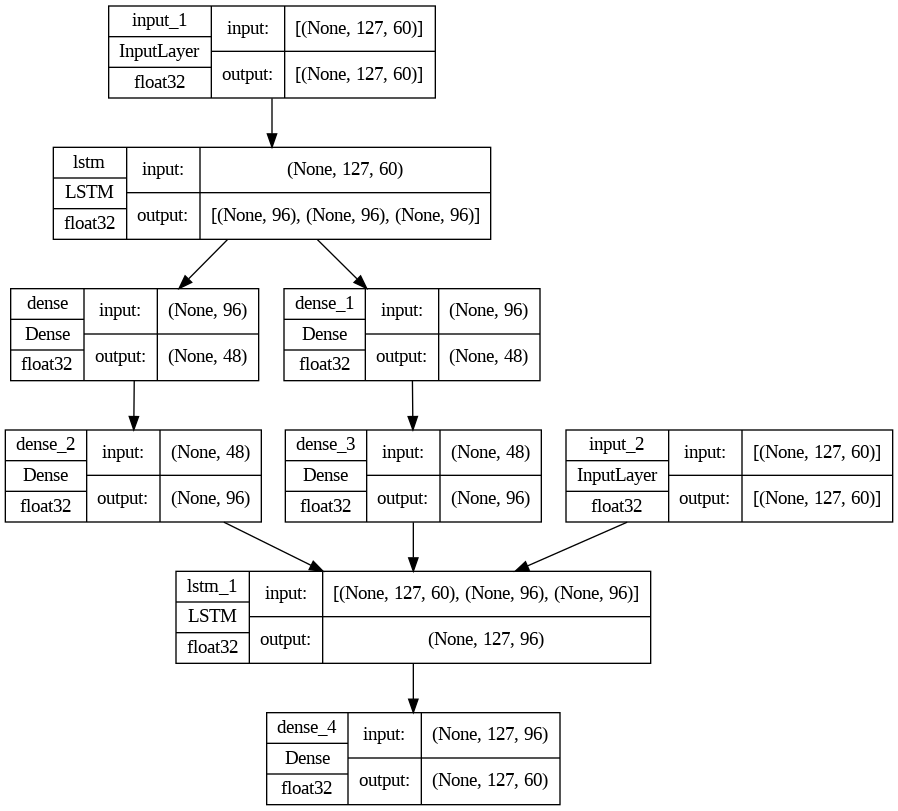

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [ ]:
# fit the model
nb_epochs = 250
validation_steps = len(X_val) // batch_size
history = model.fit(training_generator, steps_per_epoch=steps_per_epoch, epochs=nb_epochs, verbose=1,
                              validation_data=validation_generator, validation_steps=validation_steps,
                             use_multiprocessing=False, shuffle=True, callbacks=[])

Epoch 1/250
61/61 [==============================] - 26s 341ms/step - loss: 0.2335 - acc: 0.5668 - f1: 0.0530 - recall: 0.0524 - precision: 0.5441 - npv: 0.0535 - val_loss: 0.0474 - val_acc: 0.5922 - val_f1: 0.5969 - val_recall: 0.5922 - val_precision: 0.6017 - val_npv: 0.6017
Epoch 2/250
61/61 [==============================] - 9s 142ms/step - loss: 0.0457 - acc: 0.5684 - f1: 0.5708 - recall: 0.5684 - precision: 0.5732 - npv: 0.5732 - val_loss: 0.0425 - val_acc: 0.5922 - val_f1: 0.5945 - val_recall: 0.5922 - val_precision: 0.5969 - val_npv: 0.5969
Epoch 3/250
61/61 [==============================] - 7s 122ms/step - loss: 0.0428 - acc: 0.5684 - f1: 0.5708 - recall: 0.5683 - precision: 0.5732 - npv: 0.5732 - val_loss: 0.0402 - val_acc: 0.5922 - val_f1: 0.5969 - val_recall: 0.5922 - val_precision: 0.6017 - val_npv: 0.6017
Epoch 4/250
61/61 [==============================] - 8s 131ms/step - loss: 0.0396 - acc: 0.5716 - f1: 0.6144 - recall: 0.5563 - precision: 0.6786 - npv: 0.6995 - val_lo

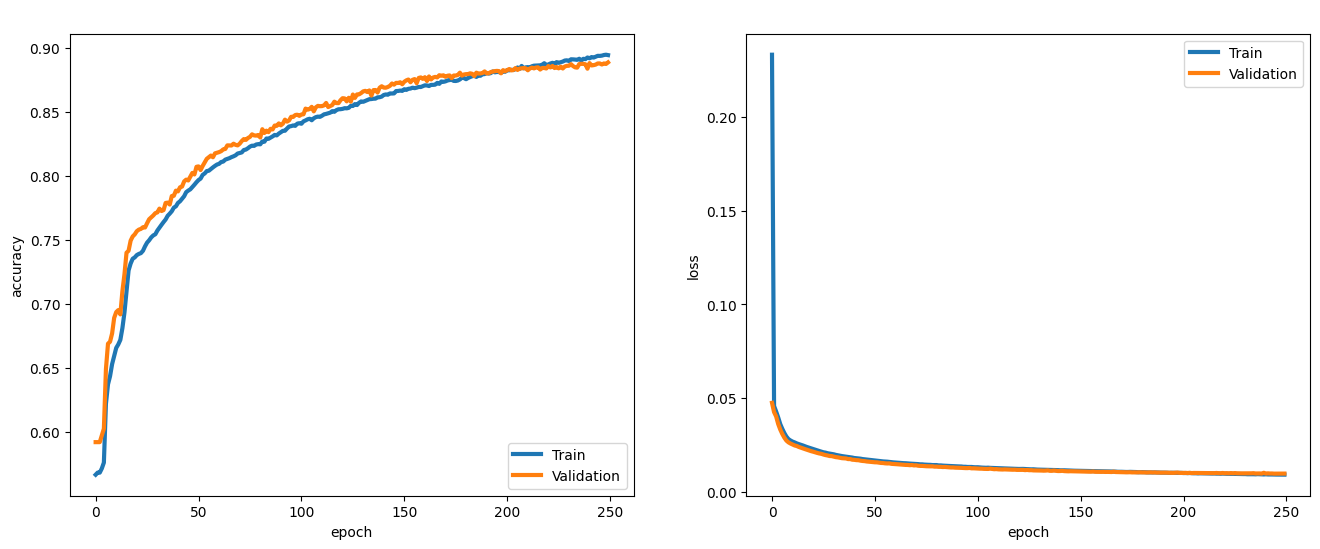

In [ ]:
# eğitilen lstm modelinin accuracy ve loss grafikleri

fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

axis1.plot(history.history["acc"], label='Train', linewidth=3)
axis1.plot(history.history["val_acc"], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16, color="white")
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='lower right')

axis2.plot(history.history["loss"], label='Train', linewidth=3)
axis2.plot(history.history["val_loss"], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16, color="white")
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [ ]:
encoder_model = Model(inputs=model.layers[0].input, outputs=model.layers[3].output)

In [ ]:
# encoder modelden gelen hidden state ve cell state değerlerini input olarak alıp sonraki decoder modele input olarak verecek olan model

latent_input = Input(shape=(48, ))
state_h = model.layers[5](latent_input)
state_c = model.layers[6](latent_input)
latent_to_states_model = Model(latent_input, [state_h, state_c])

In [ ]:
# ilaç üretecek olan kısım burası burada input katmanının 1,1,54 olması
# bu modelin çıktı olarak 54 feature'ı olan bir smiles vereceği anlamına gelir
decoder_inputs = Input(batch_shape=(1, 1, 60))
decoder_lstm = LSTM(96, return_sequences=True, stateful=True)(decoder_inputs)
decoder_outputs = Dense(60, activation='softmax')(decoder_lstm)
gen_model = Model(decoder_inputs, decoder_outputs)
for i in range(1,3):
    gen_model.layers[i].set_weights(model.layers[i+6].get_weights())

In [ ]:
# bu fonksiyonda kendi softmax fonskiyonumuzu yazıyoruz bu şekilde bir latent space oluşturabileceğiz
def sample_with_temp(preds, sampling_temp):
    streched = np.log(preds) / sampling_temp
    streched_probs = np.exp(streched) / np.sum(np.exp(streched))
    return np.random.choice(range(len(streched)), p=streched_probs)

In [ ]:
# Oluşan latent space'den sample smiles değerleri almak için fonksiyon
# oluşan latent space'i veriyoruz feature saıyısını veriyouz ve aktivasyon fonksiyonunun parametresini veriyoruz
def sample_smiles(latent, n_vocab, sampling_temp):
    states = latent_to_states_model.predict(latent)
    gen_model.layers[1].reset_states(states=[states[0], states[1]])

    startidx = char_to_int["$"]
    samplevec = np.zeros((1,1,n_vocab))
    samplevec[0,0,startidx] = 1
    sequence = ""

    for i in range(101):
        preds = gen_model.predict(samplevec)[0][-1]
        if sampling_temp == 1.0:
          sampleidx = np.argmax(preds)
        else:
          sampleidx = sample_with_temp(preds, sampling_temp)
        samplechar = int_to_char[str(sampleidx)]
        if samplechar != "X":
            sequence += samplechar
            samplevec = np.zeros((1,1,n_vocab))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return sequence

In [ ]:
# latent space etrafında smiles generationu yapıyoruz
def generate(latent_seed, sampling_temp, scale, quant):
  samples, mols = [], []
  i = 0
  while i < quant:
    latent_vec = latent_seed + scale*(np.random.randn(latent_seed.shape[1]))
    out = sample_smiles(latent_vec, n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(out)
    print(out, mol, i)
    if mol:

      try:
        RotBonds = Chem.Descriptors.NumRotatableBonds(mol)
        PSA = Chem.Descriptors.TPSA(mol)
        hDonorNum = Chem.Lipinski.NumHDonors(mol)
        hAcceptorNum = Chem.Lipinski.NumHAcceptors(mol)
        logp = Descriptors.MolLogP(mol)
        mol_weight = Descriptors.MolWt(mol)
        print(f'donor: {hDonorNum}, acceptor: {hAcceptorNum}, logp: {logp}, molweight: {mol_weight}')
        if hDonorNum <=5 and hAcceptorNum <= 10 and mol_weight <500 and logp <=5 and PSA <= 140 and RotBonds <= 10:
          i +=1
          mols.append(mol)
          samples.append(out)
      except:
        print('başaramadık')
  return mols, samples

In [ ]:
latent_space = encoder_model.predict(X_train)
latent_seed = latent_space[50:51]
sampling_temp = 0.75
scale = 0.5
quantity = 50
t_mols, t_smiles = generate(latent_seed, sampling_temp, scale, quantity)


1/1 [==============================] - 0s 17ms/step
Cc1cc(NS(=O)(=O)c2ccc(S(=O)(=O)O)cc2c2c1 None 0
1/1 [==============================] - 0s 17ms/step


[14:59:08] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(NS(=O)(=O)c2ccc(S(=O)(=O)O)cc2c2c1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(-c2ccc(NC(=O)OC)cc2)ccc1C(=O)OC)C1 None 0
1/1 [==============================] - 0s 16ms/step


[14:59:10] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(NC(=O)OC)cc2)ccc1C(=O)OC)C1
[14:59:10] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(NC(=O)OC)cc2)ccc1C(=O)OC)C1' for input: 'Cc1cc(-c2ccc(NC(=O)OC)cc2)ccc1C(=O)OC)C1'


1/1 [==============================] - 0s 15ms/step
Cc1cc(Cl)ccc1C(=O)SCc1ccccc1S(=O)(=O)O)c1 None 0
1/1 [==============================] - 0s 27ms/step


[14:59:12] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cl)ccc1C(=O)SCc1ccccc1S(=O)(=O)O)c1
[14:59:12] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cl)ccc1C(=O)SCc1ccccc1S(=O)(=O)O)c1' for input: 'Cc1cc(Cl)ccc1C(=O)SCc1ccccc1S(=O)(=O)O)c1'


1/1 [==============================] - 0s 25ms/step
Cc1cc(C(=O)Nc2cccnc3n2CCCN(C)C)c(Cl)cc1 None 0
1/1 [==============================] - 0s 16ms/step


[14:59:14] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2cccnc3n2CCCN(C)C)c(Cl)cc1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(NC(=O)c2ccccc2)c(c2[nH]c(=O)cn2)c1 None 0
1/1 [==============================] - 0s 17ms/step


[14:59:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 13 20


1/1 [==============================] - 0s 27ms/step
C1c2ccccc2c1c2ccccc2NC(=O)c2ccccc2)cc1 None 0
1/1 [==============================] - 0s 35ms/step


[14:59:19] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2c1c2ccccc2NC(=O)c2ccccc2)cc1
[14:59:19] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2c1c2ccccc2NC(=O)c2ccccc2)cc1' for input: 'C1c2ccccc2c1c2ccccc2NC(=O)c2ccccc2)cc1'


1/1 [==============================] - 0s 16ms/step
Cc1c(N)cc(C(=O)OC)c(Cl)c(C(=O)O)c2ccccc1 None 0
1/1 [==============================] - 0s 16ms/step


[14:59:22] SMILES Parse Error: unclosed ring for input: 'Cc1c(N)cc(C(=O)OC)c(Cl)c(C(=O)O)c2ccccc1'


1/1 [==============================] - 0s 16ms/step
C=C(O)c1cc(C(=O)NC(=O)Nc2ccccc2NC1CCCC2 None 0
1/1 [==============================] - 0s 17ms/step


[14:59:24] SMILES Parse Error: extra open parentheses for input: 'C=C(O)c1cc(C(=O)NC(=O)Nc2ccccc2NC1CCCC2'


1/1 [==============================] - 0s 16ms/step
Cc1cc(C(=O)Nc2ccc(C)cc2O)c(C(=O)OC)c1SC1 None 0
1/1 [==============================] - 0s 15ms/step


[14:59:26] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccc(C)cc2O)c(C(=O)OC)c1SC1'


1/1 [==============================] - 0s 16ms/step
Cc1ccc(O)c2c1C(=O)CN1C(=O)c2ccccc2)cc1O None 0
1/1 [==============================] - 0s 22ms/step


[14:59:29] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(O)c2c1C(=O)CN1C(=O)c2ccccc2)cc1O
[14:59:29] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(O)c2c1C(=O)CN1C(=O)c2ccccc2)cc1O' for input: 'Cc1ccc(O)c2c1C(=O)CN1C(=O)c2ccccc2)cc1O'


1/1 [==============================] - 0s 24ms/step
Cc1c(O)cccc2O)c1C(c1ccc(CCc2ccccc2)c2c1 None 0
1/1 [==============================] - 0s 23ms/step


[14:59:31] SMILES Parse Error: extra close parentheses while parsing: Cc1c(O)cccc2O)c1C(c1ccc(CCc2ccccc2)c2c1
[14:59:31] SMILES Parse Error: Failed parsing SMILES 'Cc1c(O)cccc2O)c1C(c1ccc(CCc2ccccc2)c2c1' for input: 'Cc1c(O)cccc2O)c1C(c1ccc(CCc2ccccc2)c2c1'


1/1 [==============================] - 0s 20ms/step
C=C1C(OC)C2C(C)C(O)C(O)C(O)C(O)C1OCCCC1 None 0
1/1 [==============================] - 0s 15ms/step


[14:59:34] SMILES Parse Error: unclosed ring for input: 'C=C1C(OC)C2C(C)C(O)C(O)C(O)C(O)C1OCCCC1'


1/1 [==============================] - 0s 19ms/step
Cc1cc(CSCC(O)C(=O)OC2CCCCCC(C)(C)C(C)C1 None 0
1/1 [==============================] - 0s 20ms/step


[14:59:36] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(CSCC(O)C(=O)OC2CCCCCC(C)(C)C(C)C1'


1/1 [==============================] - 0s 16ms/step
COc1cc(C(=O)CCCCCCCCCCCCCCCCCCO)c(=O)o1 None 0
1/1 [==============================] - 0s 16ms/step


[14:59:38] Can't kekulize mol.  Unkekulized atoms: 2 3 4


1/1 [==============================] - 0s 17ms/step
Cc1cc(Cl)c(O)c(S(=O)(=O)O)c2ccccc2c1=O)O None 0
1/1 [==============================] - 0s 16ms/step


[14:59:40] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cl)c(O)c(S(=O)(=O)O)c2ccccc2c1=O)O
[14:59:40] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cl)c(O)c(S(=O)(=O)O)c2ccccc2c1=O)O' for input: 'Cc1cc(Cl)c(O)c(S(=O)(=O)O)c2ccccc2c1=O)O'


1/1 [==============================] - 0s 18ms/step
Cc1cc(C(=O)Nc2cnccc3c1-c1ccccc1)c1ccccc1 None 0
1/1 [==============================] - 0s 16ms/step


[14:59:43] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2cnccc3c1-c1ccccc1)c1ccccc1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(NC(=C(S)c2)cc(Cl)c(S(=O)(=O)O)c2c1.[NaH] None 0
1/1 [==============================] - 0s 20ms/step


[14:59:46] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(NC(=C(S)c2)cc(Cl)c(S(=O)(=O)O)c2c1.[NaH]'


1/1 [==============================] - 0s 16ms/step
Cc1cc(S(=O)(=O)Nc2ccccc2)n2cc(C)c(S)ccc1Cl None 0
1/1 [==============================] - 0s 22ms/step


[14:59:49] SMILES Parse Error: unclosed ring for input: 'Cc1cc(S(=O)(=O)Nc2ccccc2)n2cc(C)c(S)ccc1Cl'


1/1 [==============================] - 0s 16ms/step
Cc1cc(n2C(C)(COC(CO)O2)c(=O)[nH]c2ccccc12 None 0
1/1 [==============================] - 0s 16ms/step


[14:59:51] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(n2C(C)(COC(CO)O2)c(=O)[nH]c2ccccc12'


1/1 [==============================] - 0s 16ms/step
Cc1cc(O)cc2c(O)cc(C)c2O)cc1C(=O)OC)C(=O)O None 0
1/1 [==============================] - 0s 16ms/step


[14:59:53] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc2c(O)cc(C)c2O)cc1C(=O)OC)C(=O)O
[14:59:53] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc2c(O)cc(C)c2O)cc1C(=O)OC)C(=O)O' for input: 'Cc1cc(O)cc2c(O)cc(C)c2O)cc1C(=O)OC)C(=O)O'


1/1 [==============================] - 0s 17ms/step
Cc1cc2ccccc2n1C(C)C(=O)c1ccccc1)c1ccccc1 None 0
1/1 [==============================] - 0s 16ms/step


[14:59:55] SMILES Parse Error: extra close parentheses while parsing: Cc1cc2ccccc2n1C(C)C(=O)c1ccccc1)c1ccccc1
[14:59:55] SMILES Parse Error: Failed parsing SMILES 'Cc1cc2ccccc2n1C(C)C(=O)c1ccccc1)c1ccccc1' for input: 'Cc1cc2ccccc2n1C(C)C(=O)c1ccccc1)c1ccccc1'


1/1 [==============================] - 0s 28ms/step
COC(=O)Cc1ccc(Cl)c(OC)c2c(c1)c1ccccc1)c1 None 0
1/1 [==============================] - 0s 17ms/step


[14:59:59] SMILES Parse Error: extra close parentheses while parsing: COC(=O)Cc1ccc(Cl)c(OC)c2c(c1)c1ccccc1)c1
[14:59:59] SMILES Parse Error: Failed parsing SMILES 'COC(=O)Cc1ccc(Cl)c(OC)c2c(c1)c1ccccc1)c1' for input: 'COC(=O)Cc1ccc(Cl)c(OC)c2c(c1)c1ccccc1)c1'


1/1 [==============================] - 0s 15ms/step
C=C(O)C1CCCCOC(=O)NC(C#N)C(=O)OC(C)=O)C1 None 0
1/1 [==============================] - 0s 17ms/step


[15:00:01] SMILES Parse Error: extra close parentheses while parsing: C=C(O)C1CCCCOC(=O)NC(C#N)C(=O)OC(C)=O)C1
[15:00:01] SMILES Parse Error: Failed parsing SMILES 'C=C(O)C1CCCCOC(=O)NC(C#N)C(=O)OC(C)=O)C1' for input: 'C=C(O)C1CCCCOC(=O)NC(C#N)C(=O)OC(C)=O)C1'


1/1 [==============================] - 0s 16ms/step
Cc1c(O)ccccc1N=Nc1cc(O)c(C(=O)O)c2ccccc1 None 0
1/1 [==============================] - 0s 16ms/step


[15:00:03] SMILES Parse Error: unclosed ring for input: 'Cc1c(O)ccccc1N=Nc1cc(O)c(C(=O)O)c2ccccc1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(Cl)cc1C(=S)N1CCCN1CC(C)NCCC(=O)OC None 0
1/1 [==============================] - 0s 16ms/step


[15:00:06] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6


1/1 [==============================] - 0s 20ms/step
=C(O)c1cc(=O)c(O)c(F)cFC(c1cccccc1)Cc1cc None 0
1/1 [==============================] - 0s 16ms/step


[15:00:08] SMILES Parse Error: syntax error while parsing: =C(O)c1cc(=O)c(O)c(F)cFC(c1cccccc1)Cc1cc
[15:00:08] SMILES Parse Error: Failed parsing SMILES '=C(O)c1cc(=O)c(O)c(F)cFC(c1cccccc1)Cc1cc' for input: '=C(O)c1cc(=O)c(O)c(F)cFC(c1cccccc1)Cc1cc'


1/1 [==============================] - 0s 23ms/step
Cc1cc(-c2ccc(OC)cc2)cn1C(=O)Nc1ccccc12.C None 0
1/1 [==============================] - 0s 22ms/step


[15:00:11] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(OC)cc2)cn1C(=O)Nc1ccccc12.C'


1/1 [==============================] - 0s 22ms/step
Cc1cc(O)c3c(cc(O)c(Br)cc2C(=O)O)c2cccc1 None 0
1/1 [==============================] - 0s 25ms/step


[15:00:14] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)c3c(cc(O)c(Br)cc2C(=O)O)c2cccc1'


1/1 [==============================] - 0s 20ms/step
Cc1cc(Nc2cc(S(=O)(=O)O)ccc2)c(N)c(S(=O)(=O None 0
1/1 [==============================] - 0s 18ms/step


[15:00:17] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(Nc2cc(S(=O)(=O)O)ccc2)c(N)c(S(=O)(=O'


1/1 [==============================] - 0s 19ms/step
Cc1c(O)cccc(O)c(O)c2c1C(=O)OC)c1ccccc12 None 0
1/1 [==============================] - 0s 20ms/step


[15:00:19] SMILES Parse Error: extra close parentheses while parsing: Cc1c(O)cccc(O)c(O)c2c1C(=O)OC)c1ccccc12
[15:00:19] SMILES Parse Error: Failed parsing SMILES 'Cc1c(O)cccc(O)c(O)c2c1C(=O)OC)c1ccccc12' for input: 'Cc1c(O)cccc(O)c(O)c2c1C(=O)OC)c1ccccc12'


1/1 [==============================] - 0s 23ms/step
Cc1cc(-c2ccc(C)c(O)c2cc1)c1ccc(O)cc2c1=O.[NaH] None 0
1/1 [==============================] - 0s 27ms/step


[15:00:22] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(C)c(O)c2cc1)c1ccc(O)cc2c1=O.[NaH]'


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(C)c(O)c(C(=O)O)c2)c(S)cc1O None 0
1/1 [==============================] - 0s 17ms/step


[15:00:25] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 9 11 15


1/1 [==============================] - 0s 18ms/step
Cc1cc(n2C(=O)C(=O)c2ccccc2n2n1)C(c1cccc1 None 0
1/1 [==============================] - 0s 16ms/step


[15:00:27] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(n2C(=O)C(=O)c2ccccc2n2n1)C(c1cccc1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(Nc2ccc(C)c(CCCCCN=N=N2)cc(S(=O)=O1 None 0
1/1 [==============================] - 0s 18ms/step


[15:00:30] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(Nc2ccc(C)c(CCCCCN=N=N2)cc(S(=O)=O1'


1/1 [==============================] - 0s 19ms/step
Cc1cc(Nc2ccccc2)n(COC(=O)c2ccccc2)c(=O)n1 <rdkit.Chem.rdchem.Mol object at 0x7f397a916730> 0
donor: 1, acceptor: 6, logp: 3.109820000000001, molweight: 335.36300000000006
1/1 [==============================] - 0s 33ms/step
Cc1cc(-c2ccc(C)c(N)nc3n2)ccc1C(=O)NCCCC1 None 1
1/1 [==============================] - 0s 24ms/step


[15:00:34] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(C)c(N)nc3n2)ccc1C(=O)NCCCC1'


1/1 [==============================] - 0s 18ms/step
Cc1c(O)ccc(C(=O)N2CCC(C)CCC2)c(=O)[nH]c1=O None 1
1/1 [==============================] - 0s 23ms/step


[15:00:38] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6


1/1 [==============================] - 0s 18ms/step
Cc1cc(C)c(NC(=O)NC(=O)NC(=O)OCCCCCCCCCC1 None 1
1/1 [==============================] - 0s 19ms/step


[15:00:40] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C)c(NC(=O)NC(=O)NC(=O)OCCCCCCCCCC1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(Nc2cc(S(=O)(=O)Nc3ccccc2)c2ccccc1 None 1
1/1 [==============================] - 0s 15ms/step


[15:00:42] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(Nc2cc(S(=O)(=O)Nc3ccccc2)c2ccccc1'


1/1 [==============================] - 0s 19ms/step
Cc1cc(-c2ccc(C(=O)NN3)cc2)ccc1)c1cccc1 None 1
1/1 [==============================] - 0s 17ms/step


[15:00:44] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(C(=O)NN3)cc2)ccc1)c1cccc1
[15:00:44] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(C(=O)NN3)cc2)ccc1)c1cccc1' for input: 'Cc1cc(-c2ccc(C(=O)NN3)cc2)ccc1)c1cccc1'


1/1 [==============================] - 0s 19ms/step
C=C(=O)C1CCC(OC(=O)OC)C(=O)OC(C)C)(C)C1 None 1
1/1 [==============================] - 0s 20ms/step


[15:00:47] SMILES Parse Error: extra close parentheses while parsing: C=C(=O)C1CCC(OC(=O)OC)C(=O)OC(C)C)(C)C1
[15:00:47] SMILES Parse Error: Failed parsing SMILES 'C=C(=O)C1CCC(OC(=O)OC)C(=O)OC(C)C)(C)C1' for input: 'C=C(=O)C1CCC(OC(=O)OC)C(=O)OC(C)C)(C)C1'


1/1 [==============================] - 0s 27ms/step
Cc1cc(N=Nc2ccc(S(=O)(=O)O)cc2)ccc1N=Nc1 None 1
1/1 [==============================] - 0s 27ms/step


[15:00:49] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2ccc(S(=O)(=O)O)cc2)ccc1N=Nc1'


1/1 [==============================] - 0s 20ms/step
COc1cc2c(c1)OCC(c1cccoc1NC1=O)NC(=O)NC(=O None 1
1/1 [==============================] - 0s 17ms/step


[15:00:52] SMILES Parse Error: extra open parentheses for input: 'COc1cc2c(c1)OCC(c1cccoc1NC1=O)NC(=O)NC(=O'


1/1 [==============================] - 0s 16ms/step
C1c2ccccc2c(O)c1C(=O)Nc1ccc(Cl)cc1C2=O.N None 1
1/1 [==============================] - 0s 21ms/step


[15:00:54] SMILES Parse Error: unclosed ring for input: 'C1c2ccccc2c(O)c1C(=O)Nc1ccc(Cl)cc1C2=O.N'


1/1 [==============================] - 0s 17ms/step
Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2C)cc1C(=O)O.[NaH] None 1
1/1 [==============================] - 0s 17ms/step


[15:00:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 16 17


1/1 [==============================] - 0s 18ms/step
Cc1cc(N)c(O)c(S)c1OC(O)(C)C(O)C1CCC(C)C None 1
1/1 [==============================] - 0s 16ms/step


[15:00:59] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N)c(O)c(S)c1OC(O)(C)C(O)C1CCC(C)C'


1/1 [==============================] - 0s 25ms/step
Cc1cc(N)c(SSc2ccc(C)cc2S)c1C(=O)Nc1ccc1 None 1
1/1 [==============================] - 0s 27ms/step


[15:01:02] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 16


1/1 [==============================] - 0s 21ms/step
C1(C)OC2C3(C)(C)C(=O)C(C)(C)C(O)C(C)C)O None 1
1/1 [==============================] - 0s 22ms/step


[15:01:05] SMILES Parse Error: extra close parentheses while parsing: C1(C)OC2C3(C)(C)C(=O)C(C)(C)C(O)C(C)C)O
[15:01:05] SMILES Parse Error: Failed parsing SMILES 'C1(C)OC2C3(C)(C)C(=O)C(C)(C)C(O)C(C)C)O' for input: 'C1(C)OC2C3(C)(C)C(=O)C(C)(C)C(O)C(C)C)O'


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(C)c(N)c(C)c23)C(N)CC2C)cc1 None 1
1/1 [==============================] - 0s 17ms/step


[15:01:07] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(C)c(N)c(C)c23)C(N)CC2C)cc1
[15:01:07] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(C)c(N)c(C)c23)C(N)CC2C)cc1' for input: 'Cc1cc(-c2ccc(C)c(N)c(C)c23)C(N)CC2C)cc1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(c2n(C)C(CO)C3O2)c(=O)[nH]c(=O)[n1-] None 1
1/1 [==============================] - 0s 16ms/step


[15:01:10] SMILES Parse Error: syntax error while parsing: Cc1cc(c2n(C)C(CO)C3O2)c(=O)[nH]c(=O)[n1-]
[15:01:10] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(c2n(C)C(CO)C3O2)c(=O)[nH]c(=O)[n1-]' for input: 'Cc1cc(c2n(C)C(CO)C3O2)c(=O)[nH]c(=O)[n1-]'


1/1 [==============================] - 0s 17ms/step
Cc1cc(NC(=O)c2ccccc3c2n(C)C(=O)c2ccccc21 None 1
1/1 [==============================] - 0s 16ms/step


[15:01:12] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(NC(=O)c2ccccc3c2n(C)C(=O)c2ccccc21'


1/1 [==============================] - 0s 32ms/step
Cc1cc(Cl)cc(C1CC1SC2CCC(C)(C)C)CCCC(C)C None 1
1/1 [==============================] - 0s 31ms/step


[15:01:15] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Cl)cc(C1CC1SC2CCC(C)(C)C)CCCC(C)C'


1/1 [==============================] - 0s 21ms/step
n1[nH]c(=O)n(C2CC(CO)O2)c(=O)[nH]c1=O)c1O None 1
1/1 [==============================] - 0s 24ms/step


[15:01:18] SMILES Parse Error: extra close parentheses while parsing: n1[nH]c(=O)n(C2CC(CO)O2)c(=O)[nH]c1=O)c1O
[15:01:18] SMILES Parse Error: Failed parsing SMILES 'n1[nH]c(=O)n(C2CC(CO)O2)c(=O)[nH]c1=O)c1O' for input: 'n1[nH]c(=O)n(C2CC(CO)O2)c(=O)[nH]c1=O)c1O'


1/1 [==============================] - 0s 25ms/step
Cc1cc(Nc2ccccc3)c2c1)c1ccccc1)c1ccccc1F None 1
1/1 [==============================] - 0s 26ms/step


[15:01:21] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Nc2ccccc3)c2c1)c1ccccc1)c1ccccc1F
[15:01:21] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Nc2ccccc3)c2c1)c1ccccc1)c1ccccc1F' for input: 'Cc1cc(Nc2ccccc3)c2c1)c1ccccc1)c1ccccc1F'


1/1 [==============================] - 0s 19ms/step
Cc1cc(C(=O)C2CCC(CO)c2ccccc2)c(=O)[nH]c1 None 1
1/1 [==============================] - 0s 18ms/step


[15:01:23] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)C2CCC(CO)c2ccccc2)c(=O)[nH]c1'


1/1 [==============================] - 0s 22ms/step
Cc1cc(O)cc(O)c2c1C(=O)Nc1ccc(N=Nc2ccccc1 None 1
1/1 [==============================] - 0s 17ms/step


[15:01:26] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(O)cc(O)c2c1C(=O)Nc1ccc(N=Nc2ccccc1'


1/1 [==============================] - 0s 27ms/step
Cc1cc(-c2ccc(C)c(C(=O)O)c2)cc2cc(cc3cccc1 None 1
1/1 [==============================] - 0s 28ms/step


[15:01:29] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(C)c(C(=O)O)c2)cc2cc(cc3cccc1'


1/1 [==============================] - 0s 17ms/step
COc1ccc(OC2CCC(C)C(COC(=O)O)c2)c(=O)[nH]1 <rdkit.Chem.rdchem.Mol object at 0x7f3951930c80> 1
donor: 2, acceptor: 5, logp: 2.2617000000000003, molweight: 311.334
1/1 [==============================] - 0s 16ms/step
Cc1c(S)cc(O)c1OC)C(O)c1ccc(S(=O)(=O)O)cc1 None 2
1/1 [==============================] - 0s 16ms/step


[15:01:34] SMILES Parse Error: extra close parentheses while parsing: Cc1c(S)cc(O)c1OC)C(O)c1ccc(S(=O)(=O)O)cc1
[15:01:34] SMILES Parse Error: Failed parsing SMILES 'Cc1c(S)cc(O)c1OC)C(O)c1ccc(S(=O)(=O)O)cc1' for input: 'Cc1c(S)cc(O)c1OC)C(O)c1ccc(S(=O)(=O)O)cc1'


1/1 [==============================] - 0s 21ms/step
Nc1ccccc1C(=O)c1cc(S(=O)(=O)O)c2ccccc21.[NaH] None 2
1/1 [==============================] - 0s 19ms/step


[15:01:37] Can't kekulize mol.  Unkekulized atoms: 9 10 11 16 17 18 19 20 21


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(O)cc(C)c2-c3ccccc2)c(=O)[nH]1 None 2
1/1 [==============================] - 0s 16ms/step


[15:01:39] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(O)cc(C)c2-c3ccccc2)c(=O)[nH]1'


1/1 [==============================] - 0s 24ms/step
n1c2nc(C)ccc1N=Nc1cc(Cl)c(O)c(C(=O)OC)c1 None 2
1/1 [==============================] - 0s 28ms/step


[15:01:42] SMILES Parse Error: unclosed ring for input: 'n1c2nc(C)ccc1N=Nc1cc(Cl)c(O)c(C(=O)OC)c1'


1/1 [==============================] - 0s 20ms/step
Cc1cc(S)cc1C(=O)N(CC=CNc1ccccc1)NC(=O)OC None 2
1/1 [==============================] - 0s 17ms/step


[15:01:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6


1/1 [==============================] - 0s 19ms/step
Cc1cc(NC(=O)c2ccccc2[N+](=O)[O-])cc2c1=O None 2
1/1 [==============================] - 0s 17ms/step


[15:01:47] SMILES Parse Error: unclosed ring for input: 'Cc1cc(NC(=O)c2ccccc2[N+](=O)[O-])cc2c1=O'


1/1 [==============================] - 0s 21ms/step
Cc1cc(N)c(C#N)c2c1nc2ccccc3n[nH]2)c(=O)o1 None 2
1/1 [==============================] - 0s 16ms/step


[15:01:50] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N)c(C#N)c2c1nc2ccccc3n[nH]2)c(=O)o1
[15:01:50] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N)c(C#N)c2c1nc2ccccc3n[nH]2)c(=O)o1' for input: 'Cc1cc(N)c(C#N)c2c1nc2ccccc3n[nH]2)c(=O)o1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(=O)oc2c(=O)c2c(C(=O)O)c2)cc1C(=O)O.[NaH] None 2
1/1 [==============================] - 0s 16ms/step


[15:01:52] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(=O)oc2c(=O)c2c(C(=O)O)c2)cc1C(=O)O.[NaH]
[15:01:52] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(=O)oc2c(=O)c2c(C(=O)O)c2)cc1C(=O)O.[NaH]' for input: 'Cc1cc(=O)oc2c(=O)c2c(C(=O)O)c2)cc1C(=O)O.[NaH]'


1/1 [==============================] - 0s 25ms/step
C1(CO)C2C3(C)C(C)C3O)C(O)C1(C)C)C1CCC1=O None 2
1/1 [==============================] - 0s 25ms/step


[15:01:56] SMILES Parse Error: extra close parentheses while parsing: C1(CO)C2C3(C)C(C)C3O)C(O)C1(C)C)C1CCC1=O
[15:01:56] SMILES Parse Error: Failed parsing SMILES 'C1(CO)C2C3(C)C(C)C3O)C(O)C1(C)C)C1CCC1=O' for input: 'C1(CO)C2C3(C)C(C)C3O)C(O)C1(C)C)C1CCC1=O'


1/1 [==============================] - 0s 16ms/step
Cc1ccc(N=Nc2c(O)cc(Cl)cc2)c2ccccc21.CCCC <rdkit.Chem.rdchem.Mol object at 0x7f3908da2180> 2
donor: 1, acceptor: 3, logp: 7.7290200000000056, molweight: 354.8810000000002
1/1 [==============================] - 0s 17ms/step
Cc1c(O)cccc(C1CCN1C(=O)N(C)C(=O)NC(=O)OC None 2
1/1 [==============================] - 0s 16ms/step


[15:02:00] SMILES Parse Error: extra open parentheses for input: 'Cc1c(O)cccc(C1CCN1C(=O)N(C)C(=O)NC(=O)OC'


1/1 [==============================] - 0s 22ms/step
n1c(O)ccccc1C=Cc1cc(N)c(O)c(O)cc2ccccc1 None 2
1/1 [==============================] - 0s 17ms/step


[15:02:03] SMILES Parse Error: unclosed ring for input: 'n1c(O)ccccc1C=Cc1cc(N)c(O)c(O)cc2ccccc1'


1/1 [==============================] - 0s 16ms/step
COc1cc(C(=O)CC2CCCCCCCCCCCCCCCCCCCCCCO1)O None 2
1/1 [==============================] - 0s 16ms/step


[15:02:05] SMILES Parse Error: unclosed ring for input: 'COc1cc(C(=O)CC2CCCCCCCCCCCCCCCCCCCCCCO1)O'


1/1 [==============================] - 0s 27ms/step
COP(=O)(O)C1CCCC(C)OCC12CCC(C)(C(=O)O)C1 None 2
1/1 [==============================] - 0s 25ms/step


[15:02:08] SMILES Parse Error: unclosed ring for input: 'COP(=O)(O)C1CCCC(C)OCC12CCC(C)(C(=O)O)C1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(O)c(O)c(C(=O)O)c2)ccc1Cl.[NaH] None 2
1/1 [==============================] - 0s 17ms/step


[15:02:11] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 9 11 15


1/1 [==============================] - 0s 16ms/step
n1c(O)ccccc1N=Nc1cc(C)c(=O)c1N2)c1ccccc1 None 2
1/1 [==============================] - 0s 21ms/step


[15:02:14] SMILES Parse Error: extra close parentheses while parsing: n1c(O)ccccc1N=Nc1cc(C)c(=O)c1N2)c1ccccc1
[15:02:14] SMILES Parse Error: Failed parsing SMILES 'n1c(O)ccccc1N=Nc1cc(C)c(=O)c1N2)c1ccccc1' for input: 'n1c(O)ccccc1N=Nc1cc(C)c(=O)c1N2)c1ccccc1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(NC(=O)C(=O)c2ccccc2)cc1C(=O)NC(C)=O None 2
1/1 [==============================] - 0s 28ms/step


[15:02:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 15 16


1/1 [==============================] - 0s 16ms/step
Cc1c(C)ccc1C(=O)N(C)C(=O)c1cccc(S(=O)(=O)O None 2
1/1 [==============================] - 0s 20ms/step


[15:02:19] SMILES Parse Error: extra open parentheses for input: 'Cc1c(C)ccc1C(=O)N(C)C(=O)c1cccc(S(=O)(=O)O'


1/1 [==============================] - 0s 26ms/step
C1c2c3ccccc2C(=O)Nc2ccc(S(=O)(=O)O)cc2c1 None 2
1/1 [==============================] - 0s 67ms/step


[15:02:22] SMILES Parse Error: unclosed ring for input: 'C1c2c3ccccc2C(=O)Nc2ccc(S(=O)(=O)O)cc2c1'


1/1 [==============================] - 0s 17ms/step
Cc1ccc(S(=O)(=O)NCC2=NNN2)c(=O)[nH]c(=O)o1 <rdkit.Chem.rdchem.Mol object at 0x7f3908832500> 2
donor: 4, acceptor: 6, logp: -0.7887000000000002, molweight: 301.28400000000005
1/1 [==============================] - 0s 16ms/step
Cc1cc(C(=O)CC2CCC(CO)O2)c(O)c(=O)[nH]c1=O <rdkit.Chem.rdchem.Mol object at 0x7f39086e6500> 2
donor: 3, acceptor: 6, logp: -0.13818000000000003, molweight: 295.291
1/1 [==============================] - 0s 21ms/step
Cc1cc(Cl)cc1C(=O)CC1CCCCCC(N)C(C)C(C)C2 None 3
1/1 [==============================] - 0s 22ms/step


[15:02:30] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Cl)cc1C(=O)CC1CCCCCC(N)C(C)C(C)C2'


1/1 [==============================] - 0s 27ms/step
Cc1cc(N)cc2n(C(=O)CC(=O)NC(=N)C)c(S(=O)H] None 3
1/1 [==============================] - 0s 32ms/step


[15:02:33] SMILES Parse Error: syntax error while parsing: Cc1cc(N)cc2n(C(=O)CC(=O)NC(=N)C)c(S(=O)H]
[15:02:33] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N)cc2n(C(=O)CC(=O)NC(=N)C)c(S(=O)H]' for input: 'Cc1cc(N)cc2n(C(=O)CC(=O)NC(=N)C)c(S(=O)H]'


1/1 [==============================] - 0s 16ms/step
n1[nH]c(=O)oc2c1)c1ccccc1CCSCc1ccccc1Cl) None 3
1/1 [==============================] - 0s 17ms/step


[15:02:36] SMILES Parse Error: extra close parentheses while parsing: n1[nH]c(=O)oc2c1)c1ccccc1CCSCc1ccccc1Cl)
[15:02:36] SMILES Parse Error: Failed parsing SMILES 'n1[nH]c(=O)oc2c1)c1ccccc1CCSCc1ccccc1Cl)' for input: 'n1[nH]c(=O)oc2c1)c1ccccc1CCSCc1ccccc1Cl)'


1/1 [==============================] - 0s 20ms/step
Cc1cc(-c2ccc(Cl)ccc1)OCC1)C(C)=C(C)C(=O)O None 3
1/1 [==============================] - 0s 17ms/step


[15:02:39] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)ccc1)OCC1)C(C)=C(C)C(=O)O
[15:02:39] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)ccc1)OCC1)C(C)=C(C)C(=O)O' for input: 'Cc1cc(-c2ccc(Cl)ccc1)OCC1)C(C)=C(C)C(=O)O'


1/1 [==============================] - 0s 19ms/step
Cc1cc(C(=O)Nc2ccc(C)c(C)c2C(=O)OC)cc1Cl None 3
1/1 [==============================] - 0s 17ms/step


[15:02:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 19 20


1/1 [==============================] - 0s 16ms/step
Cc1cc(C(=O)Nc2ccc(C)cc2C1CCC(N)C(=O)CC1F None 3
1/1 [==============================] - 0s 17ms/step


[15:02:43] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C(=O)Nc2ccc(C)cc2C1CCC(N)C(=O)CC1F'


1/1 [==============================] - 0s 29ms/step
Cc1cc(N=Nc2cc(C(=O)O)ccccc21.[N+](=O)[O-] None 3
1/1 [==============================] - 0s 30ms/step


[15:02:46] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(N=Nc2cc(C(=O)O)ccccc21.[N+](=O)[O-]'


1/1 [==============================] - 0s 16ms/step
Cc1cc(O)cc2c(=O)c(Cl)c1)c1ccc(Cl)cc1)O1 None 3
1/1 [==============================] - 0s 25ms/step


[15:02:49] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc2c(=O)c(Cl)c1)c1ccc(Cl)cc1)O1
[15:02:49] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc2c(=O)c(Cl)c1)c1ccc(Cl)cc1)O1' for input: 'Cc1cc(O)cc2c(=O)c(Cl)c1)c1ccc(Cl)cc1)O1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(NS(=O)(=O)c2ccc(-c3ccccc32)c(S)cc1 None 3
1/1 [==============================] - 0s 21ms/step


[15:02:52] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(NS(=O)(=O)c2ccc(-c3ccccc32)c(S)cc1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(NC(=O)c2ccccc2[N+](=O)[O-])cc1)c1 None 3
1/1 [==============================] - 0s 16ms/step


[15:02:54] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NC(=O)c2ccccc2[N+](=O)[O-])cc1)c1
[15:02:54] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NC(=O)c2ccccc2[N+](=O)[O-])cc1)c1' for input: 'Cc1cc(NC(=O)c2ccccc2[N+](=O)[O-])cc1)c1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(-c2ccc(F)c(C)c(C)c2=O)c1ccccc1C2=O None 3
1/1 [==============================] - 0s 16ms/step


[15:02:56] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(F)c(C)c(C)c2=O)c1ccccc1C2=O'


1/1 [==============================] - 0s 21ms/step
C1c2c(O)cccc2c1=O)C1CN=C2OC(C)(C)C)CCC12 None 3
1/1 [==============================] - 0s 28ms/step


[15:02:59] SMILES Parse Error: extra close parentheses while parsing: C1c2c(O)cccc2c1=O)C1CN=C2OC(C)(C)C)CCC12
[15:02:59] SMILES Parse Error: Failed parsing SMILES 'C1c2c(O)cccc2c1=O)C1CN=C2OC(C)(C)C)CCC12' for input: 'C1c2c(O)cccc2c1=O)C1CN=C2OC(C)(C)C)CCC12'


1/1 [==============================] - 0s 26ms/step
Cc1cc(C(=O)Nc2nc(C)c(S)cc1)C(=O)c1ccccc1 None 3
1/1 [==============================] - 0s 16ms/step


[15:03:02] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2nc(C)c(S)cc1)C(=O)c1ccccc1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(C(=O)CN2CCC(N=C2CCCC=CCC(=O)O)C1=O None 3
1/1 [==============================] - 0s 16ms/step


[15:03:05] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C(=O)CN2CCC(N=C2CCCC=CCC(=O)O)C1=O'


1/1 [==============================] - 0s 16ms/step
COc1cc(-c2cc(Cl)c(O)c(Cl)c2)c(c2)c(=O)n1 None 3
1/1 [==============================] - 0s 17ms/step


[15:03:07] SMILES Parse Error: unclosed ring for input: 'COc1cc(-c2cc(Cl)c(O)c(Cl)c2)c(c2)c(=O)n1'


1/1 [==============================] - 0s 16ms/step
C1c(O)ccccc1)[n1c2ccccc12)c1ccccc1C2O)CC1 None 3
1/1 [==============================] - 0s 16ms/step


[15:03:09] SMILES Parse Error: extra close parentheses while parsing: C1c(O)ccccc1)[n1c2ccccc12)c1ccccc1C2O)CC1
[15:03:09] SMILES Parse Error: Failed parsing SMILES 'C1c(O)ccccc1)[n1c2ccccc12)c1ccccc1C2O)CC1' for input: 'C1c(O)ccccc1)[n1c2ccccc12)c1ccccc1C2O)CC1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(C=Cc2c(O)c(O)cc(C(=O)O)cc12)C(=O)O <rdkit.Chem.rdchem.Mol object at 0x7f39088a27a0> 3
donor: 4, acceptor: 4, logp: 2.1622999999999997, molweight: 288.255
1/1 [==============================] - 0s 35ms/step
C=C(O)C1C(=O)C(=O)NNC(=S)C2(C)C)(C)C21 None 4
1/1 [==============================] - 0s 27ms/step


[15:03:15] SMILES Parse Error: extra close parentheses while parsing: C=C(O)C1C(=O)C(=O)NNC(=S)C2(C)C)(C)C21
[15:03:15] SMILES Parse Error: Failed parsing SMILES 'C=C(O)C1C(=O)C(=O)NNC(=S)C2(C)C)(C)C21' for input: 'C=C(O)C1C(=O)C(=O)NNC(=S)C2(C)C)(C)C21'


1/1 [==============================] - 0s 17ms/step
Cc1cc(NC(=O)c2ccc(-c3ccccc3)c2)cc1C(=O)OC None 4
1/1 [==============================] - 0s 16ms/step


[15:03:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 18 19


1/1 [==============================] - 0s 23ms/step
Cc1cc(OC)c(O)cc1C(=O)Nc1ccc(Cl)c(C)c2c1 None 4
1/1 [==============================] - 0s 17ms/step


[15:03:20] SMILES Parse Error: unclosed ring for input: 'Cc1cc(OC)c(O)cc1C(=O)Nc1ccc(Cl)c(C)c2c1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(=O)oc2c1nccc1C(=O)Nc1ccc(NC(=O)OC1 None 4
1/1 [==============================] - 0s 15ms/step


[15:03:22] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(=O)oc2c1nccc1C(=O)Nc1ccc(NC(=O)OC1'


1/1 [==============================] - 0s 22ms/step
COc1cc(-c2ccc(-c3ccc(O)c2)c(O)ccc1)C(=O) None 4
1/1 [==============================] - 0s 16ms/step


[15:03:25] SMILES Parse Error: unclosed ring for input: 'COc1cc(-c2ccc(-c3ccc(O)c2)c(O)ccc1)C(=O)'


1/1 [==============================] - 0s 45ms/step
Cc1cc(NS(=O)(=O)N2CC(C)(Cl)C1CCCC(C)(C)I None 4
1/1 [==============================] - 0s 28ms/step


[15:03:28] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(NS(=O)(=O)N2CC(C)(Cl)C1CCCC(C)(C)I'


1/1 [==============================] - 0s 16ms/step
Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc([N+](=O)[O None 4
1/1 [==============================] - 0s 17ms/step


[15:03:30] SMILES Parse Error: syntax error while parsing: Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc([N+](=O)[O
[15:03:30] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc([N+](=O)[O' for input: 'Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc([N+](=O)[O'


1/1 [==============================] - 0s 26ms/step
Cc1cc(-c2ccc(O)c(C)cc4c3O)cc2c1N=Cc1ccc1 None 4
1/1 [==============================] - 0s 17ms/step


[15:03:33] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(O)c(C)cc4c3O)cc2c1N=Cc1ccc1'


1/1 [==============================] - 0s 20ms/step
C=C(O)c1cc(OC)c(OC)C(O)c1ccccc2c1c2cccc1 None 4
1/1 [==============================] - 0s 16ms/step


[15:03:35] Can't kekulize mol.  Unkekulized atoms: 3 4 5 8 13


1/1 [==============================] - 0s 20ms/step
Cc1cc(-c2ccc(Cl)c(O)cc(O)c2)ccc1)c1cccc1 None 4
1/1 [==============================] - 0s 21ms/step


[15:03:38] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)c(O)cc(O)c2)ccc1)c1cccc1
[15:03:38] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)c(O)cc(O)c2)ccc1)c1cccc1' for input: 'Cc1cc(-c2ccc(Cl)c(O)cc(O)c2)ccc1)c1cccc1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(-c2ccc(O)c(C(=O)O)c2)cc2ccccc2c1=O <rdkit.Chem.rdchem.Mol object at 0x7f39088246d0> 4
donor: 2, acceptor: 3, logp: 3.579220000000002, molweight: 306.31700000000006
1/1 [==============================] - 0s 20ms/step
[C+]1([O-])C(C(=O)OCCCCCCCCCCCCCCCC)O)O1 None 5
1/1 [==============================] - 0s 22ms/step


[15:03:44] SMILES Parse Error: extra close parentheses while parsing: [C+]1([O-])C(C(=O)OCCCCCCCCCCCCCCCC)O)O1
[15:03:44] SMILES Parse Error: Failed parsing SMILES '[C+]1([O-])C(C(=O)OCCCCCCCCCCCCCCCC)O)O1' for input: '[C+]1([O-])C(C(=O)OCCCCCCCCCCCCCCCC)O)O1'


1/1 [==============================] - 0s 19ms/step
Cc1cc(C(=O)Nc2ccccc1)C(=O)NC(=O)c1cccc1 None 5
1/1 [==============================] - 0s 21ms/step


[15:03:47] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccccc1)C(=O)NC(=O)c1cccc1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(O)c(CO)c2)ccc1C(=O)NCCCSC1=O None 5
1/1 [==============================] - 0s 16ms/step


[15:03:49] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(O)c(CO)c2)ccc1C(=O)NCCCSC1=O'


1/1 [==============================] - 0s 17ms/step
Cc1cc(S(=O)(=O)Nc2nc(C)c(C)c(=O)n(C)c3=O2 None 5
1/1 [==============================] - 0s 24ms/step


[15:03:51] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(S(=O)(=O)Nc2nc(C)c(C)c(=O)n(C)c3=O2'


1/1 [==============================] - 0s 21ms/step
Cc1cc(O)cc2c(=O)c(C(=O)O)cc2c1)c1ccccc1N None 5
1/1 [==============================] - 0s 16ms/step


[15:03:55] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc2c(=O)c(C(=O)O)cc2c1)c1ccccc1N
[15:03:55] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc2c(=O)c(C(=O)O)cc2c1)c1ccccc1N' for input: 'Cc1cc(O)cc2c(=O)c(C(=O)O)cc2c1)c1ccccc1N'


1/1 [==============================] - 0s 19ms/step
COc1cc(C(=O)CC2OC(CO)c2)c(=O)[nH]c1=O)c1 None 5
1/1 [==============================] - 0s 17ms/step


[15:03:57] SMILES Parse Error: extra close parentheses while parsing: COc1cc(C(=O)CC2OC(CO)c2)c(=O)[nH]c1=O)c1
[15:03:57] SMILES Parse Error: Failed parsing SMILES 'COc1cc(C(=O)CC2OC(CO)c2)c(=O)[nH]c1=O)c1' for input: 'COc1cc(C(=O)CC2OC(CO)c2)c(=O)[nH]c1=O)c1'


1/1 [==============================] - 0s 20ms/step
Cc1cc(N)c(O)c2cc(S(=O)(=O)O)cc2ccccc12.[NaH] None 5
1/1 [==============================] - 0s 17ms/step


[15:04:00] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N)c(O)c2cc(S(=O)(=O)O)cc2ccccc12.[NaH]'


1/1 [==============================] - 0s 16ms/step
COc1cc(C(=O)Cc2ccccc2)c2cc(O)ccc12)C(=O) None 5
1/1 [==============================] - 0s 16ms/step


[15:04:02] SMILES Parse Error: extra close parentheses while parsing: COc1cc(C(=O)Cc2ccccc2)c2cc(O)ccc12)C(=O)
[15:04:02] SMILES Parse Error: Failed parsing SMILES 'COc1cc(C(=O)Cc2ccccc2)c2cc(O)ccc12)C(=O)' for input: 'COc1cc(C(=O)Cc2ccccc2)c2cc(O)ccc12)C(=O)'


1/1 [==============================] - 0s 27ms/step
C=C(O)C1CCCCCOC(=O)Nc1ccc(Cl)c(C(=O)O)c1 None 5
1/1 [==============================] - 0s 37ms/step


[15:04:05] SMILES Parse Error: unclosed ring for input: 'C=C(O)C1CCCCCOC(=O)Nc1ccc(Cl)c(C(=O)O)c1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(Nc2ccc(C)cc2O)cc1C(=O)Nc1ccccc1Cl None 5
1/1 [==============================] - 0s 17ms/step


[15:04:08] Can't kekulize mol.  Unkekulized atoms: 1 2 3 13 14


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(F)c(S)cc1)CCC(=O)O)c1cccc1 None 5
1/1 [==============================] - 0s 15ms/step


[15:04:10] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(F)c(S)cc1)CCC(=O)O)c1cccc1
[15:04:10] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(F)c(S)cc1)CCC(=O)O)c1cccc1' for input: 'Cc1cc(-c2ccc(F)c(S)cc1)CCC(=O)O)c1cccc1'


1/1 [==============================] - 0s 22ms/step
C1(COC)C(C)S(=O)(=O)c1ccccc1)(Cl)OCCCC1C None 5
1/1 [==============================] - 0s 17ms/step


[15:04:13] SMILES Parse Error: extra close parentheses while parsing: C1(COC)C(C)S(=O)(=O)c1ccccc1)(Cl)OCCCC1C
[15:04:13] SMILES Parse Error: Failed parsing SMILES 'C1(COC)C(C)S(=O)(=O)c1ccccc1)(Cl)OCCCC1C' for input: 'C1(COC)C(C)S(=O)(=O)c1ccccc1)(Cl)OCCCC1C'


1/1 [==============================] - 0s 18ms/step
Cc1c(O)cccc(S(=O)(=O)c2ccccc2o1)CCC(C)F <rdkit.Chem.rdchem.Mol object at 0x7f390915a3b0> 5
donor: 1, acceptor: 4, logp: 4.220500000000004, molweight: 338.4000000000001
1/1 [==============================] - 0s 16ms/step
Cc1cc(O)cc(C(=O)N=SC(=O)O)c2ccccc2c1Cl)s None 6
1/1 [==============================] - 0s 15ms/step


[15:04:18] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(C(=O)N=SC(=O)O)c2ccccc2c1Cl)s
[15:04:18] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(C(=O)N=SC(=O)O)c2ccccc2c1Cl)s' for input: 'Cc1cc(O)cc(C(=O)N=SC(=O)O)c2ccccc2c1Cl)s'


1/1 [==============================] - 0s 41ms/step
C1(C)CCCC2CCC(C)(C)C(O)C(O)C1(C)C)C(=O)O None 6
1/1 [==============================] - 0s 25ms/step


[15:04:21] SMILES Parse Error: extra close parentheses while parsing: C1(C)CCCC2CCC(C)(C)C(O)C(O)C1(C)C)C(=O)O
[15:04:21] SMILES Parse Error: Failed parsing SMILES 'C1(C)CCCC2CCC(C)(C)C(O)C(O)C1(C)C)C(=O)O' for input: 'C1(C)CCCC2CCC(C)(C)C(O)C(O)C1(C)C)C(=O)O'


1/1 [==============================] - 0s 17ms/step
=C(O)OC1C(C)C=C(C(=O)Nc1ccccc1)SC(=O)OC1 None 6
1/1 [==============================] - 0s 16ms/step


[15:04:23] SMILES Parse Error: syntax error while parsing: =C(O)OC1C(C)C=C(C(=O)Nc1ccccc1)SC(=O)OC1
[15:04:23] SMILES Parse Error: Failed parsing SMILES '=C(O)OC1C(C)C=C(C(=O)Nc1ccccc1)SC(=O)OC1' for input: '=C(O)OC1C(C)C=C(C(=O)Nc1ccccc1)SC(=O)OC1'


1/1 [==============================] - 0s 20ms/step
Cc1cc(Nc2ccc(C(=O)O)cc23)cc2ccccc2S(=O)( None 6
1/1 [==============================] - 0s 17ms/step


[15:04:26] SMILES Parse Error: syntax error while parsing: Cc1cc(Nc2ccc(C(=O)O)cc23)cc2ccccc2S(=O)(
[15:04:26] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Nc2ccc(C(=O)O)cc23)cc2ccccc2S(=O)(' for input: 'Cc1cc(Nc2ccc(C(=O)O)cc23)cc2ccccc2S(=O)('


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(OC)c2)c(c1)OCCNN[N+](=O)[O-] None 6
1/1 [==============================] - ETA: 0s

[15:04:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 11 12


1/1 [==============================] - 0s 15ms/step
C1(C)OC1CC(O)C(O)C(O)C1OC(=O)O1)C(O)C1OC None 6
1/1 [==============================] - 0s 21ms/step


[15:04:30] SMILES Parse Error: extra close parentheses while parsing: C1(C)OC1CC(O)C(O)C(O)C1OC(=O)O1)C(O)C1OC
[15:04:30] SMILES Parse Error: Failed parsing SMILES 'C1(C)OC1CC(O)C(O)C(O)C1OC(=O)O1)C(O)C1OC' for input: 'C1(C)OC1CC(O)C(O)C(O)C1OC(=O)O1)C(O)C1OC'


1/1 [==============================] - 0s 24ms/step
Cc1cc2ccc(Cl)cc1)NCCC1Nc2ccc(Cl)cc2O)cc1 None 6
1/1 [==============================] - 0s 49ms/step


[15:04:34] SMILES Parse Error: extra close parentheses while parsing: Cc1cc2ccc(Cl)cc1)NCCC1Nc2ccc(Cl)cc2O)cc1
[15:04:34] SMILES Parse Error: Failed parsing SMILES 'Cc1cc2ccc(Cl)cc1)NCCC1Nc2ccc(Cl)cc2O)cc1' for input: 'Cc1cc2ccc(Cl)cc1)NCCC1Nc2ccc(Cl)cc2O)cc1'


1/1 [==============================] - 0s 17ms/step
=C1CCCCCCCC(CCCC=C(CO)O2)C(C)C1(C)C)Cl None 6
1/1 [==============================] - 0s 18ms/step


[15:04:36] SMILES Parse Error: syntax error while parsing: =C1CCCCCCCC(CCCC=C(CO)O2)C(C)C1(C)C)Cl
[15:04:36] SMILES Parse Error: Failed parsing SMILES '=C1CCCCCCCC(CCCC=C(CO)O2)C(C)C1(C)C)Cl' for input: '=C1CCCCCCCC(CCCC=C(CO)O2)C(C)C1(C)C)Cl'


1/1 [==============================] - 0s 16ms/step
C1=C(CO)C(=O)N(C#N)C(=O)OCC(O)OC(C)C)C None 6
1/1 [==============================] - 0s 21ms/step


[15:04:38] SMILES Parse Error: extra close parentheses while parsing: C1=C(CO)C(=O)N(C#N)C(=O)OCC(O)OC(C)C)C
[15:04:38] SMILES Parse Error: Failed parsing SMILES 'C1=C(CO)C(=O)N(C#N)C(=O)OCC(O)OC(C)C)C' for input: 'C1=C(CO)C(=O)N(C#N)C(=O)OCC(O)OC(C)C)C'


1/1 [==============================] - 0s 16ms/step
Cc1cc(O)c(O)c(N)c(CO)c(O)cc1C2O)C(C)C(C)I None 6
1/1 [==============================] - 0s 16ms/step


[15:04:41] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(N)c(CO)c(O)cc1C2O)C(C)C(C)I
[15:04:41] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(N)c(CO)c(O)cc1C2O)C(C)C(C)I' for input: 'Cc1cc(O)c(O)c(N)c(CO)c(O)cc1C2O)C(C)C(C)I'


1/1 [==============================] - 0s 17ms/step
Cc1cc(-c2ccc(NC(=O)Nc(N)ccc3O)cc2ccccc12 None 6
1/1 [==============================] - 0s 16ms/step


[15:04:43] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(NC(=O)Nc(N)ccc3O)cc2ccccc12'


1/1 [==============================] - 0s 28ms/step
Cc1cc(O)cc(C(=O)CC=CC(=O)O)c2ccccc2)cc1 None 6
1/1 [==============================] - 0s 32ms/step


[15:04:47] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(C(=O)CC=CC(=O)O)c2ccccc2)cc1
[15:04:47] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(C(=O)CC=CC(=O)O)c2ccccc2)cc1' for input: 'Cc1cc(O)cc(C(=O)CC=CC(=O)O)c2ccccc2)cc1'


1/1 [==============================] - 0s 26ms/step
Cc1cc(Cl)cc(S(=O)(=O)c2ccccc2n2)c(=O)[nH]1 None 6
1/1 [==============================] - 0s 20ms/step


[15:04:50] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Cl)cc(S(=O)(=O)c2ccccc2n2)c(=O)[nH]1'


1/1 [==============================] - 0s 18ms/step
C1c1ccccc1[nH]c1ccc1C(=O)Nc1ccc(Nc2ccccc1 None 6
1/1 [==============================] - 0s 18ms/step


[15:04:52] SMILES Parse Error: extra open parentheses for input: 'C1c1ccccc1[nH]c1ccc1C(=O)Nc1ccc(Nc2ccccc1'


1/1 [==============================] - 0s 17ms/step
COc1ccc(C(=O)C(=O)N2CCC(N)C(C)C)cc1)CCCS None 6
1/1 [==============================] - 0s 16ms/step


[15:04:55] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(C(=O)C(=O)N2CCC(N)C(C)C)cc1)CCCS
[15:04:55] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(C(=O)C(=O)N2CCC(N)C(C)C)cc1)CCCS' for input: 'COc1ccc(C(=O)C(=O)N2CCC(N)C(C)C)cc1)CCCS'


1/1 [==============================] - 0s 25ms/step
Cc1cc2ccccc1)c1ccccc1N=Cc1ccc(Cl)c2ccc1 None 6
1/1 [==============================] - 0s 24ms/step


[15:04:57] SMILES Parse Error: extra close parentheses while parsing: Cc1cc2ccccc1)c1ccccc1N=Cc1ccc(Cl)c2ccc1
[15:04:57] SMILES Parse Error: Failed parsing SMILES 'Cc1cc2ccccc1)c1ccccc1N=Cc1ccc(Cl)c2ccc1' for input: 'Cc1cc2ccccc1)c1ccccc1N=Cc1ccc(Cl)c2ccc1'


1/1 [==============================] - 0s 19ms/step
Cn1ccccc1[nH]cnc1nn1C(c1ccccc2c1ccccc1 None 6
1/1 [==============================] - 0s 16ms/step


[15:05:00] SMILES Parse Error: extra open parentheses for input: 'Cn1ccccc1[nH]cnc1nn1C(c1ccccc2c1ccccc1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(CSC(=O)CN2C(O)C(O)C(C)C(O)C(C)=O)1 None 6
1/1 [==============================] - 0s 16ms/step


[15:05:03] SMILES Parse Error: unclosed ring for input: 'Cc1cc(CSC(=O)CN2C(O)C(O)C(C)C(O)C(C)=O)1'


1/1 [==============================] - 0s 21ms/step
C1c2ccccc2c(C)c1OC(C)(C)C1CC1c2ccccc2)1.[NaH] None 6
1/1 [==============================] - 0s 17ms/step


[15:05:06] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2c(C)c1OC(C)(C)C1CC1c2ccccc2)1.[NaH]
[15:05:06] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2c(C)c1OC(C)(C)C1CC1c2ccccc2)1.[NaH]' for input: 'C1c2ccccc2c(C)c1OC(C)(C)C1CC1c2ccccc2)1.[NaH]'


1/1 [==============================] - 0s 16ms/step
Cc1cc(Cc2cc(Cl)cc2)c(O)c(Nc3ccccc2)cc1C None 6
1/1 [==============================] - 0s 16ms/step


[15:05:08] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Cc2cc(Cl)cc2)c(O)c(Nc3ccccc2)cc1C'


1/1 [==============================] - 0s 35ms/step
C1(COC)C(=O)Nc2ccc(Cl)c(C(=O)O)c2)cc(Cl)c1 None 6
1/1 [==============================] - 0s 24ms/step


[15:05:11] SMILES Parse Error: extra close parentheses while parsing: C1(COC)C(=O)Nc2ccc(Cl)c(C(=O)O)c2)cc(Cl)c1
[15:05:11] SMILES Parse Error: Failed parsing SMILES 'C1(COC)C(=O)Nc2ccc(Cl)c(C(=O)O)c2)cc(Cl)c1' for input: 'C1(COC)C(=O)Nc2ccc(Cl)c(C(=O)O)c2)cc(Cl)c1'


1/1 [==============================] - 0s 17ms/step
Cc1c(C)cccn1C(=O)Nc1ccc(OC)c(S(=O)(=O)O None 6
1/1 [==============================] - 0s 18ms/step


[15:05:14] SMILES Parse Error: extra open parentheses for input: 'Cc1c(C)cccn1C(=O)Nc1ccc(OC)c(S(=O)(=O)O'


1/1 [==============================] - 0s 16ms/step
Cc1cc(NC(=O)c2ccc(O)c(C(=O)O)cc2)ccc1C=C1 None 6
1/1 [==============================] - 0s 16ms/step


[15:05:17] SMILES Parse Error: unclosed ring for input: 'Cc1cc(NC(=O)c2ccc(O)c(C(=O)O)cc2)ccc1C=C1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(NC(=O)Nc2ccc(Cl)cc2)c2ccccc2N2)c1 None 6
1/1 [==============================] - 0s 16ms/step


[15:05:19] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NC(=O)Nc2ccc(Cl)cc2)c2ccccc2N2)c1
[15:05:19] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NC(=O)Nc2ccc(Cl)cc2)c2ccccc2N2)c1' for input: 'Cc1cc(NC(=O)Nc2ccc(Cl)cc2)c2ccccc2N2)c1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(C(=O)C2=CC3C(=O)C3=CCC2)c(=O)[nH]c1 <rdkit.Chem.rdchem.Mol object at 0x7f39094b2810> 6
donor: 1, acceptor: 3, logp: 1.71152, molweight: 255.27299999999997
1/1 [==============================] - 0s 17ms/step
Cc1cc(O)ccc1S(=O)(=O)c1ccccc1Cl)c1cccc1 None 7
1/1 [==============================] - 0s 28ms/step


[15:05:23] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)ccc1S(=O)(=O)c1ccccc1Cl)c1cccc1
[15:05:23] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)ccc1S(=O)(=O)c1ccccc1Cl)c1cccc1' for input: 'Cc1cc(O)ccc1S(=O)(=O)c1ccccc1Cl)c1cccc1'


1/1 [==============================] - 0s 27ms/step
C1c(O)ccccc1)SCc1ccc(NC(=O)NC=Cc2ccccc21 None 7
1/1 [==============================] - 0s 16ms/step


[15:05:27] SMILES Parse Error: extra close parentheses while parsing: C1c(O)ccccc1)SCc1ccc(NC(=O)NC=Cc2ccccc21
[15:05:27] SMILES Parse Error: Failed parsing SMILES 'C1c(O)ccccc1)SCc1ccc(NC(=O)NC=Cc2ccccc21' for input: 'C1c(O)ccccc1)SCc1ccc(NC(=O)NC=Cc2ccccc21'


1/1 [==============================] - 0s 16ms/step
Cc1cc(=O)nn2c(O)c(C(=O)O)cc2)cc1Cl)c1ccc None 7
1/1 [==============================] - 0s 16ms/step


[15:05:29] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(=O)nn2c(O)c(C(=O)O)cc2)cc1Cl)c1ccc
[15:05:29] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(=O)nn2c(O)c(C(=O)O)cc2)cc1Cl)c1ccc' for input: 'Cc1cc(=O)nn2c(O)c(C(=O)O)cc2)cc1Cl)c1ccc'


1/1 [==============================] - 0s 15ms/step
C=C(O)c1ccc(-c2ccc(C)c(OC)c2)ccc1Cl)c1cc None 7
1/1 [==============================] - 0s 20ms/step


[15:05:32] SMILES Parse Error: extra close parentheses while parsing: C=C(O)c1ccc(-c2ccc(C)c(OC)c2)ccc1Cl)c1cc
[15:05:32] SMILES Parse Error: Failed parsing SMILES 'C=C(O)c1ccc(-c2ccc(C)c(OC)c2)ccc1Cl)c1cc' for input: 'C=C(O)c1ccc(-c2ccc(C)c(OC)c2)ccc1Cl)c1cc'


1/1 [==============================] - 0s 16ms/step
COc1cc(C(=O)Cc2cc(Cl)cc(C#N)c2O)c(Cl)c1OC None 7
1/1 [==============================] - 0s 18ms/step


[15:05:34] Can't kekulize mol.  Unkekulized atoms: 2 3 4 18 20


1/1 [==============================] - 0s 16ms/step
Cc1cc(N=Nc2cc(C)c(O)c(C(=O)O)cc2)cc(Cl)c1 None 7
1/1 [==============================] - 0s 15ms/step


[15:05:36] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 12 16 17


1/1 [==============================] - 0s 28ms/step
COc1cc(C(=O)CC2n2c(C)cc(Cl)cc2)cc1)c1cc None 7
1/1 [==============================] - 0s 26ms/step


[15:05:39] SMILES Parse Error: extra close parentheses while parsing: COc1cc(C(=O)CC2n2c(C)cc(Cl)cc2)cc1)c1cc
[15:05:39] SMILES Parse Error: Failed parsing SMILES 'COc1cc(C(=O)CC2n2c(C)cc(Cl)cc2)cc1)c1cc' for input: 'COc1cc(C(=O)CC2n2c(C)cc(Cl)cc2)cc1)c1cc'


1/1 [==============================] - 0s 15ms/step
C1c2ccccc2c(O)c(O)c2c(N=Nc3ccccc4c3=O)c1O None 7
1/1 [==============================] - 0s 16ms/step


[15:05:42] SMILES Parse Error: unclosed ring for input: 'C1c2ccccc2c(O)c(O)c2c(N=Nc3ccccc4c3=O)c1O'


1/1 [==============================] - 0s 16ms/step
C1c(O)ccccc1)c1ccc(Cl)c1C(=O)NC(=O)CC1C None 7
1/1 [==============================] - 0s 16ms/step


[15:05:44] SMILES Parse Error: extra close parentheses while parsing: C1c(O)ccccc1)c1ccc(Cl)c1C(=O)NC(=O)CC1C
[15:05:44] SMILES Parse Error: Failed parsing SMILES 'C1c(O)ccccc1)c1ccc(Cl)c1C(=O)NC(=O)CC1C' for input: 'C1c(O)ccccc1)c1ccc(Cl)c1C(=O)NC(=O)CC1C'


1/1 [==============================] - 0s 21ms/step
Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1NC(=O)OC None 7
1/1 [==============================] - 0s 16ms/step


[15:05:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 15 16


1/1 [==============================] - 0s 15ms/step
Cc1c(C)cc(O)c(C(=O)NC(=O)C#N)c(S)cc1Cl)O None 7
1/1 [==============================] - 0s 17ms/step


[15:05:49] SMILES Parse Error: extra close parentheses while parsing: Cc1c(C)cc(O)c(C(=O)NC(=O)C#N)c(S)cc1Cl)O
[15:05:49] SMILES Parse Error: Failed parsing SMILES 'Cc1c(C)cc(O)c(C(=O)NC(=O)C#N)c(S)cc1Cl)O' for input: 'Cc1c(C)cc(O)c(C(=O)NC(=O)C#N)c(S)cc1Cl)O'


1/1 [==============================] - 0s 30ms/step
C1(C)CCC(=O)Nc2ccc(Cl)cc(C(=O)O)c2)cc1 None 7
1/1 [==============================] - 0s 22ms/step


[15:05:52] SMILES Parse Error: extra close parentheses while parsing: C1(C)CCC(=O)Nc2ccc(Cl)cc(C(=O)O)c2)cc1
[15:05:52] SMILES Parse Error: Failed parsing SMILES 'C1(C)CCC(=O)Nc2ccc(Cl)cc(C(=O)O)c2)cc1' for input: 'C1(C)CCC(=O)Nc2ccc(Cl)cc(C(=O)O)c2)cc1'


1/1 [==============================] - 0s 22ms/step
Cc1cc(Nc2ccccc2)n(C)cc1C(=O)OC(C)C(=O)OC None 7
1/1 [==============================] - 0s 15ms/step


[15:05:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 13 14


1/1 [==============================] - 0s 20ms/step
Cc1c(O)ccccc1S(=O)(=O)c1ccccc1)c1ccccc1 None 7
1/1 [==============================] - 0s 27ms/step


[15:05:58] SMILES Parse Error: extra close parentheses while parsing: Cc1c(O)ccccc1S(=O)(=O)c1ccccc1)c1ccccc1
[15:05:58] SMILES Parse Error: Failed parsing SMILES 'Cc1c(O)ccccc1S(=O)(=O)c1ccccc1)c1ccccc1' for input: 'Cc1c(O)ccccc1S(=O)(=O)c1ccccc1)c1ccccc1'


1/1 [==============================] - 0s 21ms/step
C1c2ccccc2c(O)c(C(=O)O)cc1O)c1ccccc1N=NC None 7
1/1 [==============================] - 0s 19ms/step


[15:06:00] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2c(O)c(C(=O)O)cc1O)c1ccccc1N=NC
[15:06:00] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2c(O)c(C(=O)O)cc1O)c1ccccc1N=NC' for input: 'C1c2ccccc2c(O)c(C(=O)O)cc1O)c1ccccc1N=NC'


1/1 [==============================] - 0s 21ms/step
Cc1cc([N+](=O)[O-])c(O)c2[nH]cccc2)cc2c1 None 7
1/1 [==============================] - 0s 16ms/step


[15:06:03] SMILES Parse Error: extra close parentheses while parsing: Cc1cc([N+](=O)[O-])c(O)c2[nH]cccc2)cc2c1
[15:06:03] SMILES Parse Error: Failed parsing SMILES 'Cc1cc([N+](=O)[O-])c(O)c2[nH]cccc2)cc2c1' for input: 'Cc1cc([N+](=O)[O-])c(O)c2[nH]cccc2)cc2c1'


1/1 [==============================] - 0s 26ms/step
Cc1cc(-c2ccc(Cl)cc2)cc1nc1ccccc1C2=O)CC None 7
1/1 [==============================] - 0s 24ms/step


[15:06:06] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)cc2)cc1nc1ccccc1C2=O)CC
[15:06:06] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)cc2)cc1nc1ccccc1C2=O)CC' for input: 'Cc1cc(-c2ccc(Cl)cc2)cc1nc1ccccc1C2=O)CC'


1/1 [==============================] - 0s 16ms/step
Cc1cc(C=Cc2ccc(Cl)c(O)c(C(=O)O)c2)ccc1N=O None 7
1/1 [==============================] - 0s 15ms/step


[15:06:08] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 17


1/1 [==============================] - 0s 19ms/step
Cc1cc(c2)c(S)c(O)c1C(=O)Nc1ccc(Cl)cc1C2 None 7
1/1 [==============================] - 0s 15ms/step


[15:06:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 9 13 14 15 16 18 19


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(Cl)cc2)n2cc(Cl)cc2)ccc1Cl)c1 None 7
1/1 [==============================] - 0s 16ms/step


[15:06:13] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)cc2)n2cc(Cl)cc2)ccc1Cl)c1
[15:06:13] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)cc2)n2cc(Cl)cc2)ccc1Cl)c1' for input: 'Cc1cc(-c2ccc(Cl)cc2)n2cc(Cl)cc2)ccc1Cl)c1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(O)cc(OCCC(=O)OC)cc2sc(Cl)ccc12)OC None 7
1/1 [==============================] - 0s 17ms/step


[15:06:16] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(OCCC(=O)OC)cc2sc(Cl)ccc12)OC
[15:06:16] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(OCCC(=O)OC)cc2sc(Cl)ccc12)OC' for input: 'Cc1cc(O)cc(OCCC(=O)OC)cc2sc(Cl)ccc12)OC'


1/1 [==============================] - 0s 22ms/step
Nc1cc(S(=O)(=O)N2CC(C)CCC(C)C)cc(C2=O)O1 None 7
1/1 [==============================] - 0s 22ms/step


[15:06:18] Can't kekulize mol.  Unkekulized atoms: 1 2 3 16 17


1/1 [==============================] - 0s 17ms/step
Cc1cc(Nc2nc(N)c(S)c3c(=O)c2c3c2ccccc221 None 7
1/1 [==============================] - 0s 16ms/step


[15:06:21] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(Nc2nc(N)c(S)c3c(=O)c2c3c2ccccc221'


1/1 [==============================] - 0s 23ms/step
Cc1cc(N=Nc2cc(C)c(O)c(C)c2)ccc1)SCCCC1Br None 7
1/1 [==============================] - 0s 16ms/step


[15:06:24] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2cc(C)c(O)c(C)c2)ccc1)SCCCC1Br
[15:06:24] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2cc(C)c(O)c(C)c2)ccc1)SCCCC1Br' for input: 'Cc1cc(N=Nc2cc(C)c(O)c(C)c2)ccc1)SCCCC1Br'


1/1 [==============================] - 0s 16ms/step
Cc1cc(O)cc1)c1cc(N)c(S)cn1C2CCCCCCN2C.[Cl-] None 7
1/1 [==============================] - ETA: 0s

[15:06:26] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc1)c1cc(N)c(S)cn1C2CCCCCCN2C.[Cl-]
[15:06:26] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc1)c1cc(N)c(S)cn1C2CCCCCCN2C.[Cl-]' for input: 'Cc1cc(O)cc1)c1cc(N)c(S)cn1C2CCCCCCN2C.[Cl-]'


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(O)c(Cl)cc2C(=O)OC(C)C)c2)c1 None 7
1/1 [==============================] - 0s 26ms/step


[15:06:29] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(Cl)cc2C(=O)OC(C)C)c2)c1
[15:06:29] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(Cl)cc2C(=O)OC(C)C)c2)c1' for input: 'Cc1cc(-c2ccc(O)c(Cl)cc2C(=O)OC(C)C)c2)c1'


1/1 [==============================] - 0s 26ms/step
Cc1cc(-c2ccc(C(=O)OC)c(O)c2)c(=O)[nH]c1=O None 7
1/1 [==============================] - 0s 27ms/step


[15:06:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3


1/1 [==============================] - 0s 16ms/step
Cc1cc(C(=O)Cc2ccc(O)cc2)ccc1C(=O)OC)C(=O) None 7
1/1 [==============================] - 0s 16ms/step


[15:06:34] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)Cc2ccc(O)cc2)ccc1C(=O)OC)C(=O)
[15:06:34] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)Cc2ccc(O)cc2)ccc1C(=O)OC)C(=O)' for input: 'Cc1cc(C(=O)Cc2ccc(O)cc2)ccc1C(=O)OC)C(=O)'


1/1 [==============================] - 0s 17ms/step
=C(O)CC1CCC(O)C(COP(=O)(O)OCC1OC(C)(CO)O None 7
1/1 [==============================] - 0s 16ms/step


[15:06:37] SMILES Parse Error: syntax error while parsing: =C(O)CC1CCC(O)C(COP(=O)(O)OCC1OC(C)(CO)O
[15:06:37] SMILES Parse Error: Failed parsing SMILES '=C(O)CC1CCC(O)C(COP(=O)(O)OCC1OC(C)(CO)O' for input: '=C(O)CC1CCC(O)C(COP(=O)(O)OCC1OC(C)(CO)O'


1/1 [==============================] - 0s 16ms/step
COc1cc(C(=O)C(=O)N2C(=O)O2)c(=O)[nH]c1=O None 7
1/1 [==============================] - 0s 16ms/step


[15:06:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4


1/1 [==============================] - 0s 26ms/step
COc1cc(-c2ccc(O)c(O)cc(O)c(CO)c2)cc1OC.[NaH] None 7
1/1 [==============================] - 0s 16ms/step


[15:06:42] Can't kekulize mol.  Unkekulized atoms: 2 3 4 19 20


1/1 [==============================] - 0s 25ms/step
Cc1cc(-c2ccc(O)c(C)c2)ccc1C=CC(C)(C)C)CC None 7
1/1 [==============================] - 0s 29ms/step


[15:06:44] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(C)c2)ccc1C=CC(C)(C)C)CC
[15:06:44] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(C)c2)ccc1C=CC(C)(C)C)CC' for input: 'Cc1cc(-c2ccc(O)c(C)c2)ccc1C=CC(C)(C)C)CC'


1/1 [==============================] - 0s 15ms/step
Cc1cc(C(=O)Nc2ccccc2)c(O)c(C)c(Cl)cc2s1 None 7
1/1 [==============================] - 0s 16ms/step


[15:06:48] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccccc2)c(O)c(C)c(Cl)cc2s1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(CC=SC(=O)NC(=O)N3CCO)cc2)cc1 None 7
1/1 [==============================] - 0s 18ms/step


[15:06:50] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(CC=SC(=O)NC(=O)N3CCO)cc2)cc1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(C(=O)Nc2ccccc2)sc1C2O)C(O)CC(C)C None 7
1/1 [==============================] - 0s 16ms/step


[15:06:52] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)Nc2ccccc2)sc1C2O)C(O)CC(C)C
[15:06:52] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)Nc2ccccc2)sc1C2O)C(O)CC(C)C' for input: 'Cc1cc(C(=O)Nc2ccccc2)sc1C2O)C(O)CC(C)C'


1/1 [==============================] - 0s 23ms/step
Cc1ccc(C#N)c(c1)N(Cc1ccccc2n1C(C)C(=O)OC None 7
1/1 [==============================] - 0s 19ms/step


[15:06:55] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(C#N)c(c1)N(Cc1ccccc2n1C(C)C(=O)OC'


1/1 [==============================] - 0s 17ms/step
Cc1cc(Cl)cc(C(=O)CCN=C(C)C(=O)OC(C)C)cc1 None 7
1/1 [==============================] - 0s 17ms/step


[15:06:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 20 21


1/1 [==============================] - 0s 31ms/step
Cc1cc(=O)[nH]c(=O)c(c2S(=O)(=O)O)cc1C(=O) None 7
1/1 [==============================] - 0s 27ms/step


[15:07:00] SMILES Parse Error: unclosed ring for input: 'Cc1cc(=O)[nH]c(=O)c(c2S(=O)(=O)O)cc1C(=O)'


1/1 [==============================] - 0s 16ms/step
Cc1cc(C)c(n2c(O)c(O)cc(C(=O)O)c2)ccc1O.[NaH] None 7
1/1 [==============================] - 0s 18ms/step


[15:07:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 17 18 19


1/1 [==============================] - 0s 21ms/step
Cc1cc(O)c(O)c(=O)n2[N+](=O)[O-])cc1)c1cc None 7
1/1 [==============================] - 0s 22ms/step


[15:07:06] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(=O)n2[N+](=O)[O-])cc1)c1cc
[15:07:06] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(=O)n2[N+](=O)[O-])cc1)c1cc' for input: 'Cc1cc(O)c(O)c(=O)n2[N+](=O)[O-])cc1)c1cc'


1/1 [==============================] - 0s 27ms/step
C1c3c(C)cc(S(=O)(=O)O)c2ccccc2c12)c1ccc None 7
1/1 [==============================] - 0s 23ms/step


[15:07:09] SMILES Parse Error: extra close parentheses while parsing: C1c3c(C)cc(S(=O)(=O)O)c2ccccc2c12)c1ccc
[15:07:09] SMILES Parse Error: Failed parsing SMILES 'C1c3c(C)cc(S(=O)(=O)O)c2ccccc2c12)c1ccc' for input: 'C1c3c(C)cc(S(=O)(=O)O)c2ccccc2c12)c1ccc'


1/1 [==============================] - 0s 45ms/step
Cc1cc(N=Nc2ccc(C)c(C(=O)O)cc3C2=O)c2cccc1 None 7
1/1 [==============================] - 0s 27ms/step


[15:07:12] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2ccc(C)c(C(=O)O)cc3C2=O)c2cccc1'


1/1 [==============================] - 0s 22ms/step
Cc1cc(-c2ccc(-c3ccccc3n2[n+]2)cccc1F)CCC1 None 7
1/1 [==============================] - 0s 19ms/step


[15:07:15] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(-c3ccccc3n2[n+]2)cccc1F)CCC1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1)N1CCCC2 None 7
1/1 [==============================] - 0s 17ms/step


[15:07:18] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1)N1CCCC2
[15:07:18] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1)N1CCCC2' for input: 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1)N1CCCC2'


1/1 [==============================] - 0s 18ms/step
Cc1cc(CSc2ccccc2)c(NC(=O)CC=Cc2ccccc2)c1C None 7
1/1 [==============================] - ETA: 0s

[15:07:21] Can't kekulize mol.  Unkekulized atoms: 1 2 3 12 25


1/1 [==============================] - 0s 17ms/step
C1c(O)ccccc1)c1cc(O)c(O)c1)c1ccccc1C(=O)O None 7
1/1 [==============================] - 0s 17ms/step


[15:07:23] SMILES Parse Error: extra close parentheses while parsing: C1c(O)ccccc1)c1cc(O)c(O)c1)c1ccccc1C(=O)O
[15:07:23] SMILES Parse Error: Failed parsing SMILES 'C1c(O)ccccc1)c1cc(O)c(O)c1)c1ccccc1C(=O)O' for input: 'C1c(O)ccccc1)c1cc(O)c(O)c1)c1ccccc1C(=O)O'


1/1 [==============================] - 0s 24ms/step
Cc1c(C(=O)Cc2ccc(O)c(C(=O)O)c2)cc(Cl)c1O None 7
1/1 [==============================] - 0s 22ms/step


[15:07:26] Can't kekulize mol.  Unkekulized atoms: 1 2 16 17 19


1/1 [==============================] - 0s 23ms/step
C=C(NC=CCc1ccc(NC(=O)OC=Cc2ccccc2)csc1=O None 7
1/1 [==============================] - 0s 20ms/step


[15:07:29] SMILES Parse Error: extra open parentheses for input: 'C=C(NC=CCc1ccc(NC(=O)OC=Cc2ccccc2)csc1=O'


1/1 [==============================] - 0s 16ms/step
COc1cc(C2CCC(=O)OCCCOCCCC)O2)c(=O)[nH]c1=O None 7
1/1 [==============================] - 0s 18ms/step


[15:07:32] SMILES Parse Error: extra close parentheses while parsing: COc1cc(C2CCC(=O)OCCCOCCCC)O2)c(=O)[nH]c1=O
[15:07:32] SMILES Parse Error: Failed parsing SMILES 'COc1cc(C2CCC(=O)OCCCOCCCC)O2)c(=O)[nH]c1=O' for input: 'COc1cc(C2CCC(=O)OCCCOCCCC)O2)c(=O)[nH]c1=O'


1/1 [==============================] - 0s 23ms/step
n1c2cccccc3c1N=Nc1ccc(Cl)c1OC)C(=O)CCCCC None 7
1/1 [==============================] - 0s 18ms/step


[15:07:35] SMILES Parse Error: extra close parentheses while parsing: n1c2cccccc3c1N=Nc1ccc(Cl)c1OC)C(=O)CCCCC
[15:07:35] SMILES Parse Error: Failed parsing SMILES 'n1c2cccccc3c1N=Nc1ccc(Cl)c1OC)C(=O)CCCCC' for input: 'n1c2cccccc3c1N=Nc1ccc(Cl)c1OC)C(=O)CCCCC'


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2cc(C)c(OC)c(C(=O)O)cc2C)cc1C(=O)O None 7
1/1 [==============================] - 0s 22ms/step


[15:07:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 18 19


1/1 [==============================] - 0s 25ms/step
Cc1c(Cl)cccn[nH]c(=O)cc1S(=O)(=O)c1cccc1 None 7
1/1 [==============================] - 0s 31ms/step


[15:07:41] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20


1/1 [==============================] - 0s 21ms/step
Cc1cc(-c2ccc(N)c(O)c(C(=O)O)c2)ccc1Cl)c1 None 7
1/1 [==============================] - 0s 17ms/step


[15:07:44] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(N)c(O)c(C(=O)O)c2)ccc1Cl)c1
[15:07:44] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(N)c(O)c(C(=O)O)c2)ccc1Cl)c1' for input: 'Cc1cc(-c2ccc(N)c(O)c(C(=O)O)c2)ccc1Cl)c1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(O)cc(O)c(O)c1N=Nc1cc(Cl)cc1)C(C)=O None 7
1/1 [==============================] - 0s 17ms/step


[15:07:46] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(O)c(O)c1N=Nc1cc(Cl)cc1)C(C)=O
[15:07:46] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(O)c(O)c1N=Nc1cc(Cl)cc1)C(C)=O' for input: 'Cc1cc(O)cc(O)c(O)c1N=Nc1cc(Cl)cc1)C(C)=O'


1/1 [==============================] - 0s 19ms/step
Cc1cc(NC(=O)C(=O)CNc2ccccc23)c(S)cc(Cl)c1 None 7
1/1 [==============================] - 0s 16ms/step


[15:07:49] SMILES Parse Error: unclosed ring for input: 'Cc1cc(NC(=O)C(=O)CNc2ccccc23)c(S)cc(Cl)c1'


1/1 [==============================] - 0s 19ms/step
COc1ccc(C(=O)CC2=O)c(O)c(C(=O)O)c(Cl)c1 None 7
1/1 [==============================] - 0s 16ms/step


[15:07:51] SMILES Parse Error: unclosed ring for input: 'COc1ccc(C(=O)CC2=O)c(O)c(C(=O)O)c(Cl)c1'


1/1 [==============================] - 0s 25ms/step
Cc1cc(O)cc(C(=O)NN=Cc2ccccc2)c(c2)cccc1N.[NaH] None 7
1/1 [==============================] - 0s 28ms/step


[15:07:55] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)cc(C(=O)NN=Cc2ccccc2)c(c2)cccc1N.[NaH]'


1/1 [==============================] - 0s 16ms/step
Cc1cc(NC(=O)c2ccccc2)cc1C(=O)NC(C)(C)C None 7
1/1 [==============================] - 0s 21ms/step


[15:07:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 13 14


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(Cl)cc2)[n+]1Cc1ccccc1)OCCC1 None 7
1/1 [==============================] - 0s 17ms/step


[15:08:00] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)cc2)[n+]1Cc1ccccc1)OCCC1
[15:08:00] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)cc2)[n+]1Cc1ccccc1)OCCC1' for input: 'Cc1cc(-c2ccc(Cl)cc2)[n+]1Cc1ccccc1)OCCC1'


1/1 [==============================] - 0s 16ms/step
C=C(O)NC1OC(n2cc(C)ccc3n2C)c(C(=O)O)c1 None 7
1/1 [==============================] - 0s 24ms/step


[15:08:03] SMILES Parse Error: unclosed ring for input: 'C=C(O)NC1OC(n2cc(C)ccc3n2C)c(C(=O)O)c1'


1/1 [==============================] - 0s 23ms/step
Nc1cccc(S(=O)(=O)Nc2ccc(OC)c2)ccc2c1=O)O None 7
1/1 [==============================] - 0s 18ms/step


[15:08:05] SMILES Parse Error: extra close parentheses while parsing: Nc1cccc(S(=O)(=O)Nc2ccc(OC)c2)ccc2c1=O)O
[15:08:05] SMILES Parse Error: Failed parsing SMILES 'Nc1cccc(S(=O)(=O)Nc2ccc(OC)c2)ccc2c1=O)O' for input: 'Nc1cccc(S(=O)(=O)Nc2ccc(OC)c2)ccc2c1=O)O'


1/1 [==============================] - 0s 26ms/step
Cc1cc(C(=O)C2=CN(C3C(O)C(C)C)=C2)c(=O)n1 None 7
1/1 [==============================] - 0s 25ms/step


[15:08:09] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)C2=CN(C3C(O)C(C)C)=C2)c(=O)n1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(O)c(C(=O)Cc2ccccc2)c2cccnc3c2=O)cc1 None 7
1/1 [==============================] - 0s 21ms/step


[15:08:12] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(C(=O)Cc2ccccc2)c2cccnc3c2=O)cc1
[15:08:12] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(C(=O)Cc2ccccc2)c2cccnc3c2=O)cc1' for input: 'Cc1cc(O)c(C(=O)Cc2ccccc2)c2cccnc3c2=O)cc1'


1/1 [==============================] - 0s 16ms/step
C=C(O)c1ccc(C2CCCN=[N+]=[N-])c2ccccc2)O1 None 7
1/1 [==============================] - 0s 17ms/step


[15:08:14] SMILES Parse Error: extra close parentheses while parsing: C=C(O)c1ccc(C2CCCN=[N+]=[N-])c2ccccc2)O1
[15:08:14] SMILES Parse Error: Failed parsing SMILES 'C=C(O)c1ccc(C2CCCN=[N+]=[N-])c2ccccc2)O1' for input: 'C=C(O)c1ccc(C2CCCN=[N+]=[N-])c2ccccc2)O1'


1/1 [==============================] - 0s 19ms/step
Cc1cc(Nc2ccccc3n(C)c2)cc1C(=O)OC(=O)c1cc None 7
1/1 [==============================] - 0s 17ms/step


[15:08:17] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Nc2ccccc3n(C)c2)cc1C(=O)OC(=O)c1cc'


1/1 [==============================] - 0s 17ms/step
COc1cc(O)cc(COC(=O)c2ccccc3c2=O)ccc1)CC1 None 7
1/1 [==============================] - 0s 17ms/step


[15:08:19] SMILES Parse Error: extra close parentheses while parsing: COc1cc(O)cc(COC(=O)c2ccccc3c2=O)ccc1)CC1
[15:08:19] SMILES Parse Error: Failed parsing SMILES 'COc1cc(O)cc(COC(=O)c2ccccc3c2=O)ccc1)CC1' for input: 'COc1cc(O)cc(COC(=O)c2ccccc3c2=O)ccc1)CC1'


1/1 [==============================] - 0s 36ms/step
Cc1cc(Nc2ccc(O)c(C)c2)ccc1N=Nc1ccccc12 None 7
1/1 [==============================] - 0s 22ms/step


[15:08:24] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Nc2ccc(O)c(C)c2)ccc1N=Nc1ccccc12'


1/1 [==============================] - 0s 21ms/step
COc1ccc(-c2cc(C)c(S)c(O)c(C(=O)O)c2)cc1O None 7
1/1 [==============================] - 0s 24ms/step


[15:08:26] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 12 14 18


1/1 [==============================] - 0s 24ms/step
Cc1cc(O)c(O)cc2c(O)ccc1)NC(=O)NC(=O)Nc1c None 7
1/1 [==============================] - 0s 18ms/step


[15:08:29] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)cc2c(O)ccc1)NC(=O)NC(=O)Nc1c
[15:08:29] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)cc2c(O)ccc1)NC(=O)NC(=O)Nc1c' for input: 'Cc1cc(O)c(O)cc2c(O)ccc1)NC(=O)NC(=O)Nc1c'


1/1 [==============================] - 0s 20ms/step
Cc1cc(N=Nc2ccc(C)cc(S(=O)(=O)O)cc3c2)c1O None 7
1/1 [==============================] - 0s 16ms/step


[15:08:32] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2ccc(C)cc(S(=O)(=O)O)cc3c2)c1O'


1/1 [==============================] - 0s 26ms/step
Cc1cc(Nc2ccc(N)cc2)c(Cc3ccc(C)cc3C2=O)C1 None 7
1/1 [==============================] - 0s 35ms/step


[15:08:35] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Nc2ccc(N)cc2)c(Cc3ccc(C)cc3C2=O)C1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(C(=O)C2=NCCCC(C)C(=O)c2)c(Cl)c(O)c1 <rdkit.Chem.rdchem.Mol object at 0x7f39088a3990> 7
donor: 1, acceptor: 4, logp: 3.3668200000000024, molweight: 307.777
1/1 [==============================] - 0s 17ms/step
Cc1cc(-c2ccc(NC(=O)c3ccccc4)cc2)c(Cl)c1 None 8
1/1 [==============================] - 0s 16ms/step


[15:08:40] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(NC(=O)c3ccccc4)cc2)c(Cl)c1'


1/1 [==============================] - 0s 19ms/step
Cc1ccc(-c2ccc(C)c(C(=O)O)c2)ccc1Cl)c1cc1 None 8
1/1 [==============================] - 0s 16ms/step


[15:08:43] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(-c2ccc(C)c(C(=O)O)c2)ccc1Cl)c1cc1
[15:08:43] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(-c2ccc(C)c(C(=O)O)c2)ccc1Cl)c1cc1' for input: 'Cc1ccc(-c2ccc(C)c(C(=O)O)c2)ccc1Cl)c1cc1'


1/1 [==============================] - 0s 16ms/step
C1c(O)ccccc1C1CSSC(=O)Nc1ccc(Cl)cc2cccc1 None 8
1/1 [==============================] - 0s 17ms/step


[15:08:45] SMILES Parse Error: unclosed ring for input: 'C1c(O)ccccc1C1CSSC(=O)Nc1ccc(Cl)cc2cccc1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(C)cc(S(=O)(=O)c2ccccc2[nH]2)c(N)c1 None 8
1/1 [==============================] - ETA: 0s

[15:08:48] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C)cc(S(=O)(=O)c2ccccc2[nH]2)c(N)c1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(N)c(S(=O)(=O)O)c2ccccc2c1C(=O)OC.[NaH] None 8
1/1 [==============================] - 0s 20ms/step


[15:08:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 10 11 12 13 14 15 16


1/1 [==============================] - 0s 18ms/step
Cc1cc(Nc2ccc4ccccc3nc3ccc3c2ccc(C)cc2S)c1 None 8
1/1 [==============================] - 0s 19ms/step


[15:08:54] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Nc2ccc4ccccc3nc3ccc3c2ccc(C)cc2S)c1'


1/1 [==============================] - 0s 23ms/step
C1c2ccccc2c1C(=O)Nc1ccc(NC(=O)c2ccccc2C1 None 8
1/1 [==============================] - 0s 17ms/step


[15:08:57] SMILES Parse Error: extra open parentheses for input: 'C1c2ccccc2c1C(=O)Nc1ccc(NC(=O)c2ccccc2C1'


1/1 [==============================] - 0s 17ms/step
Cn1c2nc(O)cc(C(=O)O)c(N=Nc3ccc(C3=O)c23 None 8
1/1 [==============================] - 0s 16ms/step


[15:08:59] SMILES Parse Error: extra open parentheses for input: 'Cn1c2nc(O)cc(C(=O)O)c(N=Nc3ccc(C3=O)c23'


1/1 [==============================] - 0s 25ms/step
Cc1cc(O)c(O)c(C)c(O)c(C(=O)O)c2)cc(Cl)c1 None 8
1/1 [==============================] - 0s 24ms/step


[15:09:02] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(C)c(O)c(C(=O)O)c2)cc(Cl)c1
[15:09:02] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(C)c(O)c(C(=O)O)c2)cc(Cl)c1' for input: 'Cc1cc(O)c(O)c(C)c(O)c(C(=O)O)c2)cc(Cl)c1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(O)c2ccc(c3c2c(O)c(C(=O)O)cc2ccc1O None 8
1/1 [==============================] - 0s 16ms/step


[15:09:05] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(O)c2ccc(c3c2c(O)c(C(=O)O)cc2ccc1O'


1/1 [==============================] - 0s 25ms/step
Cc1cc([N+](=O)[O-])c(O)c1C(=O)OC)C(=O)c1 None 8
1/1 [==============================] - 0s 16ms/step


[15:09:08] SMILES Parse Error: extra close parentheses while parsing: Cc1cc([N+](=O)[O-])c(O)c1C(=O)OC)C(=O)c1
[15:09:08] SMILES Parse Error: Failed parsing SMILES 'Cc1cc([N+](=O)[O-])c(O)c1C(=O)OC)C(=O)c1' for input: 'Cc1cc([N+](=O)[O-])c(O)c1C(=O)OC)C(=O)c1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(-c2ccc(NC(=O)c4ccccc6[n+]4)ccc4s3)s1 None 8
1/1 [==============================] - 0s 18ms/step


[15:09:10] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(NC(=O)c4ccccc6[n+]4)ccc4s3)s1'


1/1 [==============================] - 0s 17ms/step
=C(O)OCC1CCCCCC2(C)C)C(O)C1(C)C(C)C)=O None 8
1/1 [==============================] - 0s 17ms/step


[15:09:13] SMILES Parse Error: syntax error while parsing: =C(O)OCC1CCCCCC2(C)C)C(O)C1(C)C(C)C)=O
[15:09:13] SMILES Parse Error: Failed parsing SMILES '=C(O)OCC1CCCCCC2(C)C)C(O)C1(C)C(C)C)=O' for input: '=C(O)OCC1CCCCCC2(C)C)C(O)C1(C)C(C)C)=O'


1/1 [==============================] - 0s 24ms/step
Cn1cc(-c2ccc(Cl)cc2)c2ccccc12)C(=O)CCC2=N None 8
1/1 [==============================] - 0s 25ms/step


[15:09:16] SMILES Parse Error: extra close parentheses while parsing: Cn1cc(-c2ccc(Cl)cc2)c2ccccc12)C(=O)CCC2=N
[15:09:16] SMILES Parse Error: Failed parsing SMILES 'Cn1cc(-c2ccc(Cl)cc2)c2ccccc12)C(=O)CCC2=N' for input: 'Cn1cc(-c2ccc(Cl)cc2)c2ccccc12)C(=O)CCC2=N'


1/1 [==============================] - 0s 18ms/step
Cc1cc(-c2ccc(Cl)c(C)c2=O)c2ccccc21)C(C)C None 8
1/1 [==============================] - 0s 22ms/step


[15:09:19] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)c(C)c2=O)c2ccccc21)C(C)C
[15:09:19] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)c(C)c2=O)c2ccccc21)C(C)C' for input: 'Cc1cc(-c2ccc(Cl)c(C)c2=O)c2ccccc21)C(C)C'


1/1 [==============================] - 0s 19ms/step
Cc1cc(N=Nc2ccc(O)cc(C=Cc3ccccc2)c(=O)[nH]1 None 8
1/1 [==============================] - 0s 16ms/step


[15:09:22] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(N=Nc2ccc(O)cc(C=Cc3ccccc2)c(=O)[nH]1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(OC)ccc1C1=Cc1ccccc1S(=O)(=O)O)c1cc1 None 8
1/1 [==============================] - 0s 17ms/step


[15:09:25] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(OC)ccc1C1=Cc1ccccc1S(=O)(=O)O)c1cc1
[15:09:25] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(OC)ccc1C1=Cc1ccccc1S(=O)(=O)O)c1cc1' for input: 'Cc1cc(OC)ccc1C1=Cc1ccccc1S(=O)(=O)O)c1cc1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(Cc2ccc(Cl)cc2)c1nc(c2)c1N=Nc1cccc1 None 8
1/1 [==============================] - 0s 18ms/step


[15:09:27] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Cc2ccc(Cl)cc2)c1nc(c2)c1N=Nc1cccc1'


1/1 [==============================] - 0s 26ms/step
Cn1c2ccccc2cc2ccccc2c1C(=O)OC)C(C)C(=O)O None 8
1/1 [==============================] - 0s 35ms/step


[15:09:31] SMILES Parse Error: extra close parentheses while parsing: Cn1c2ccccc2cc2ccccc2c1C(=O)OC)C(C)C(=O)O
[15:09:31] SMILES Parse Error: Failed parsing SMILES 'Cn1c2ccccc2cc2ccccc2c1C(=O)OC)C(C)C(=O)O' for input: 'Cn1c2ccccc2cc2ccccc2c1C(=O)OC)C(C)C(=O)O'


1/1 [==============================] - 0s 17ms/step
Cn1c2ccccc(Cl)c2S(=O)(=O)O)cc1S(=O)(=O)O.[NaH] None 8
1/1 [==============================] - 0s 17ms/step


[15:09:34] SMILES Parse Error: extra close parentheses while parsing: Cn1c2ccccc(Cl)c2S(=O)(=O)O)cc1S(=O)(=O)O.[NaH]
[15:09:34] SMILES Parse Error: Failed parsing SMILES 'Cn1c2ccccc(Cl)c2S(=O)(=O)O)cc1S(=O)(=O)O.[NaH]' for input: 'Cn1c2ccccc(Cl)c2S(=O)(=O)O)cc1S(=O)(=O)O.[NaH]'


1/1 [==============================] - 0s 24ms/step
Cc1cc(C(=O)Nc2ccc(NC(=O)NC(=O)O)c2ccccc1 None 8
1/1 [==============================] - 0s 24ms/step


[15:09:37] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C(=O)Nc2ccc(NC(=O)NC(=O)O)c2ccccc1'


1/1 [==============================] - 0s 24ms/step
C1=C(OCCC(=O)Nc2ccccc2)cc1C(=O)OC)C(=O)O None 8
1/1 [==============================] - 0s 24ms/step


[15:09:40] SMILES Parse Error: extra close parentheses while parsing: C1=C(OCCC(=O)Nc2ccccc2)cc1C(=O)OC)C(=O)O
[15:09:40] SMILES Parse Error: Failed parsing SMILES 'C1=C(OCCC(=O)Nc2ccccc2)cc1C(=O)OC)C(=O)O' for input: 'C1=C(OCCC(=O)Nc2ccccc2)cc1C(=O)OC)C(=O)O'


1/1 [==============================] - 0s 27ms/step
Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1C(=O)O)c1 None 8
1/1 [==============================] - 0s 26ms/step


[15:09:44] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1C(=O)O)c1
[15:09:44] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1C(=O)O)c1' for input: 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1C(=O)O)c1'


1/1 [==============================] - 0s 20ms/step
Cc1cc(Cl)cc2c1nc1ccccc1O)c1ccccc1C2S)c1 None 8
1/1 [==============================] - 0s 21ms/step


[15:09:47] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cl)cc2c1nc1ccccc1O)c1ccccc1C2S)c1
[15:09:47] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cl)cc2c1nc1ccccc1O)c1ccccc1C2S)c1' for input: 'Cc1cc(Cl)cc2c1nc1ccccc1O)c1ccccc1C2S)c1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(N=Nc2ccn3C(c3ccccc23)c(N=Nc2ccccc1 None 8
1/1 [==============================] - 0s 17ms/step


[15:09:50] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(N=Nc2ccn3C(c3ccccc23)c(N=Nc2ccccc1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(O)c(O)c(OC(C)CCCC)c(O)c(C)c(=O)[nH]1 None 8
1/1 [==============================] - 0s 18ms/step


[15:09:53] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 7 15 17


1/1 [==============================] - 0s 19ms/step
C1(C)OC(C)Cc2ccccc2)c2c(O)ccc2ccccc21.[NaH] None 8
1/1 [==============================] - 0s 17ms/step


[15:09:56] SMILES Parse Error: extra close parentheses while parsing: C1(C)OC(C)Cc2ccccc2)c2c(O)ccc2ccccc21.[NaH]
[15:09:56] SMILES Parse Error: Failed parsing SMILES 'C1(C)OC(C)Cc2ccccc2)c2c(O)ccc2ccccc21.[NaH]' for input: 'C1(C)OC(C)Cc2ccccc2)c2c(O)ccc2ccccc21.[NaH]'


1/1 [==============================] - 0s 31ms/step
Cc1ccc(-c2c(O)cc(C)c2)n(C)c(C(=O)O)c2ccc1 None 8
1/1 [==============================] - 0s 32ms/step


[15:09:59] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2c(O)cc(C)c2)n(C)c(C(=O)O)c2ccc1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(-c2ccc(C)c(C)c(O)cc2)ccc1N=Nc1ccc1 <rdkit.Chem.rdchem.Mol object at 0x7f3908902490> 8
donor: 1, acceptor: 3, logp: 6.263920000000005, molweight: 316.40400000000005
1/1 [==============================] - 0s 18ms/step
Cc1c(O)cccc1C(=O)C(C)S(=O)(=O)O)OCC1CCC None 8
1/1 [==============================] - 0s 18ms/step


[15:10:05] SMILES Parse Error: extra close parentheses while parsing: Cc1c(O)cccc1C(=O)C(C)S(=O)(=O)O)OCC1CCC
[15:10:05] SMILES Parse Error: Failed parsing SMILES 'Cc1c(O)cccc1C(=O)C(C)S(=O)(=O)O)OCC1CCC' for input: 'Cc1c(O)cccc1C(=O)C(C)S(=O)(=O)O)OCC1CCC'


1/1 [==============================] - 0s 17ms/step
Cc1cc(C)cc(C)c1N=Nc1cc(C(=O)O)ccc1C2=O)O1 None 8
1/1 [==============================] - 0s 17ms/step


[15:10:08] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C)cc(C)c1N=Nc1cc(C(=O)O)ccc1C2=O)O1
[15:10:08] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C)cc(C)c1N=Nc1cc(C(=O)O)ccc1C2=O)O1' for input: 'Cc1cc(C)cc(C)c1N=Nc1cc(C(=O)O)ccc1C2=O)O1'


1/1 [==============================] - 0s 27ms/step
C=CC(Nc1ccc(F)cc1C(=O)Nc1ccc(O)ccc1N=S)O None 8
1/1 [==============================] - 0s 31ms/step


[15:10:10] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 19 20 21


1/1 [==============================] - 0s 23ms/step
C1(C)Oc2ccccc2c1n2c3ccccc3c2O)ccc1Cl)c1 None 8
1/1 [==============================] - 0s 18ms/step


[15:10:14] SMILES Parse Error: extra close parentheses while parsing: C1(C)Oc2ccccc2c1n2c3ccccc3c2O)ccc1Cl)c1
[15:10:14] SMILES Parse Error: Failed parsing SMILES 'C1(C)Oc2ccccc2c1n2c3ccccc3c2O)ccc1Cl)c1' for input: 'C1(C)Oc2ccccc2c1n2c3ccccc3c2O)ccc1Cl)c1'


1/1 [==============================] - 0s 17ms/step
COc1cc(C(=O)Cc2ccc(OC)c(C(=O)O)c2)ccc1C <rdkit.Chem.rdchem.Mol object at 0x7f39094b26c0> 8
donor: 1, acceptor: 4, logp: 3.1358200000000007, molweight: 314.33700000000005
1/1 [==============================] - 0s 21ms/step
Cc1cc(O)cc(C(C)C(=O)O)c(O)c(C)c1OC)C(C) None 9
1/1 [==============================] - 0s 16ms/step


[15:10:19] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(C(C)C(=O)O)c(O)c(C)c1OC)C(C)
[15:10:19] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(C(C)C(=O)O)c(O)c(C)c1OC)C(C)' for input: 'Cc1cc(O)cc(C(C)C(=O)O)c(O)c(C)c1OC)C(C)'


1/1 [==============================] - 0s 16ms/step
Cc1cc(NC(=S)c2ccccc3[nH]c2=O)c(c2)ccc1Cl None 9
1/1 [==============================] - 0s 16ms/step


[15:10:21] SMILES Parse Error: unclosed ring for input: 'Cc1cc(NC(=S)c2ccccc3[nH]c2=O)c(c2)ccc1Cl'


1/1 [==============================] - 0s 23ms/step
Cc1cc(C(=O)Nc2cnnc(NC(=O)NCC=NN3)cc2)cc1C None 9
1/1 [==============================] - 0s 26ms/step


[15:10:24] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2cnnc(NC(=O)NCC=NN3)cc2)cc1C'


1/1 [==============================] - 0s 21ms/step
C=C(NC1CCC(O)CC(O)C2(C)C)NC(C)(C)C(O)C1 None 9
1/1 [==============================] - 0s 20ms/step


[15:10:28] SMILES Parse Error: unclosed ring for input: 'C=C(NC1CCC(O)CC(O)C2(C)C)NC(C)(C)C(O)C1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(-c2ccc(NC(=O)c3ccccc3)n2C)c(=O)c1=O None 9
1/1 [==============================] - 0s 18ms/step


[15:10:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3


1/1 [==============================] - 0s 17ms/step
C1c2ccccc2n(C)c1)c1cc(NC(=O)c2ccccc2)c1 None 9
1/1 [==============================] - 0s 20ms/step


[15:10:33] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2n(C)c1)c1cc(NC(=O)c2ccccc2)c1
[15:10:33] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2n(C)c1)c1cc(NC(=O)c2ccccc2)c1' for input: 'C1c2ccccc2n(C)c1)c1cc(NC(=O)c2ccccc2)c1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(C(=O)C(=O)OC(CO)N2CCC(C)C)c(=O)[nH]1 None 9
1/1 [==============================] - 0s 16ms/step


[15:10:35] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)C(=O)OC(CO)N2CCC(C)C)c(=O)[nH]1'


1/1 [==============================] - 0s 32ms/step
Cc1cc(N=Nc2ccc(O)c(C)c2)ccc1N=Nc1ccccc1 <rdkit.Chem.rdchem.Mol object at 0x7f3908b52a40> 9
donor: 1, acceptor: 5, logp: 6.839840000000006, molweight: 330.3910000000001
1/1 [==============================] - 0s 38ms/step
Cc1cc(C2CCC(=O)CCCCCCCCCCCCCCC)O)[nH]c2=O None 9
1/1 [==============================] - 0s 26ms/step


[15:10:41] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C2CCC(=O)CCCCCCCCCCCCCCC)O)[nH]c2=O
[15:10:41] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C2CCC(=O)CCCCCCCCCCCCCCC)O)[nH]c2=O' for input: 'Cc1cc(C2CCC(=O)CCCCCCCCCCCCCCC)O)[nH]c2=O'


1/1 [==============================] - 0s 16ms/step
C1c3ccccc2)c1C(=O)Nc1ccc(N)cc2c1=O)c1cc None 9
1/1 [==============================] - 0s 17ms/step


[15:10:44] SMILES Parse Error: extra close parentheses while parsing: C1c3ccccc2)c1C(=O)Nc1ccc(N)cc2c1=O)c1cc
[15:10:44] SMILES Parse Error: Failed parsing SMILES 'C1c3ccccc2)c1C(=O)Nc1ccc(N)cc2c1=O)c1cc' for input: 'C1c3ccccc2)c1C(=O)Nc1ccc(N)cc2c1=O)c1cc'


1/1 [==============================] - 0s 18ms/step
Cc1cc(C2CCCC3N=CC2O)c(=O)[nH]c1=O)cccc1 None 9
1/1 [==============================] - 0s 17ms/step


[15:10:46] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C2CCCC3N=CC2O)c(=O)[nH]c1=O)cccc1
[15:10:46] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C2CCCC3N=CC2O)c(=O)[nH]c1=O)cccc1' for input: 'Cc1cc(C2CCCC3N=CC2O)c(=O)[nH]c1=O)cccc1'


1/1 [==============================] - 0s 17ms/step
COc1ccc(C2CCCC(CO)C(O)C(O)C(F)(O)C(C)C)n1 None 9
1/1 [==============================] - 0s 16ms/step


[15:10:49] SMILES Parse Error: unclosed ring for input: 'COc1ccc(C2CCCC(CO)C(O)C(O)C(F)(O)C(C)C)n1'


1/1 [==============================] - 0s 36ms/step
C=C(OC1Cc1ccccc1)OC(=O)N(C)C(=O)OCCC(=O)O None 9
1/1 [==============================] - ETA: 0s

[15:10:52] SMILES Parse Error: unclosed ring for input: 'C=C(OC1Cc1ccccc1)OC(=O)N(C)C(=O)OCCC(=O)O'


1/1 [==============================] - 0s 20ms/step
Cc1cc(-c2ccc(O)c(C3=O)c2)cc2ccccc2c12)c1 None 9
1/1 [==============================] - 0s 20ms/step


[15:10:56] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(C3=O)c2)cc2ccccc2c12)c1
[15:10:56] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(C3=O)c2)cc2ccccc2c12)c1' for input: 'Cc1cc(-c2ccc(O)c(C3=O)c2)cc2ccccc2c12)c1'


1/1 [==============================] - 0s 16ms/step
Cn1c(O)ccccc1C(=O)N1C(C)(C)C(C)N2)C(C)C1=O None 9
1/1 [==============================] - 0s 17ms/step


[15:10:59] SMILES Parse Error: extra close parentheses while parsing: Cn1c(O)ccccc1C(=O)N1C(C)(C)C(C)N2)C(C)C1=O
[15:10:59] SMILES Parse Error: Failed parsing SMILES 'Cn1c(O)ccccc1C(=O)N1C(C)(C)C(C)N2)C(C)C1=O' for input: 'Cn1c(O)ccccc1C(=O)N1C(C)(C)C(C)N2)C(C)C1=O'


1/1 [==============================] - 0s 16ms/step
CS(=O)(=O)c1ccccc1C(=O)Nc1ccccc21.CCCC1 None 9
1/1 [==============================] - 0s 20ms/step


[15:11:02] SMILES Parse Error: unclosed ring for input: 'CS(=O)(=O)c1ccccc1C(=O)Nc1ccccc21.CCCC1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(C(=O)CN2C(=O)c4ccccc2)c(Cl)c2cccc1 None 9
1/1 [==============================] - 0s 17ms/step


[15:11:04] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)CN2C(=O)c4ccccc2)c(Cl)c2cccc1'


1/1 [==============================] - 0s 27ms/step
Cc1cc(-c2ccc(Cl)cc(S(=O)(=O)O)cc2c1)cc1 None 9
1/1 [==============================] - 0s 30ms/step


[15:11:07] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(Cl)cc(S(=O)(=O)O)cc2c1)cc1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(Nc2nc(O)cc(O)c4ccccc3N2)c(=O)oc1=O None 9
1/1 [==============================] - 0s 16ms/step


[15:11:10] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Nc2nc(O)cc(O)c4ccccc3N2)c(=O)oc1=O'


1/1 [==============================] - 0s 16ms/step
Cc1c(O)cc(O)c(O)c(O)c(C(=O)O)cc2c1CCCCC1 None 9
1/1 [==============================] - 0s 16ms/step


[15:11:13] SMILES Parse Error: unclosed ring for input: 'Cc1c(O)cc(O)c(O)c(O)c(C(=O)O)cc2c1CCCCC1'


1/1 [==============================] - 0s 16ms/step
Cc1c(C(=O)Nc2ccc(O)c(Cl)c2)ccc1C2=O)CC1 None 9
1/1 [==============================] - 0s 16ms/step


[15:11:15] SMILES Parse Error: extra close parentheses while parsing: Cc1c(C(=O)Nc2ccc(O)c(Cl)c2)ccc1C2=O)CC1
[15:11:15] SMILES Parse Error: Failed parsing SMILES 'Cc1c(C(=O)Nc2ccc(O)c(Cl)c2)ccc1C2=O)CC1' for input: 'Cc1c(C(=O)Nc2ccc(O)c(Cl)c2)ccc1C2=O)CC1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(S(=O)(=O)O)c(O)c(S(=O)(=O)O)ccc1O <rdkit.Chem.rdchem.Mol object at 0x7f39088a0d60> 9
donor: 4, acceptor: 6, logp: 0.8173000000000001, molweight: 310.305
1/1 [==============================] - 0s 23ms/step
C=C(O)c1cc(C(=O)C(C)C(=O)Cc2ccccc3)cc1Cl None 9
1/1 [==============================] - 0s 29ms/step


[15:11:21] SMILES Parse Error: unclosed ring for input: 'C=C(O)c1cc(C(=O)C(C)C(=O)Cc2ccccc3)cc1Cl'


1/1 [==============================] - 0s 15ms/step
Cc1cc(O)c(OC)c(O)cc(C(=O)O)cc2c1C(=O)O.[NaH] None 9
1/1 [==============================] - 0s 17ms/step


[15:11:24] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)c(OC)c(O)cc(C(=O)O)cc2c1C(=O)O.[NaH]'


1/1 [==============================] - 0s 19ms/step
C(C)OCC1CCC(C2CCC4(C)C(C)C(=O)OC(C)C)CC1 None 9
1/1 [==============================] - 0s 16ms/step


[15:11:27] SMILES Parse Error: unclosed ring for input: 'C(C)OCC1CCC(C2CCC4(C)C(C)C(=O)OC(C)C)CC1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(N)c(F)c(Cl)c(S(=O)(=O)O)cc(S(=O)(=O None 9
1/1 [==============================] - 0s 16ms/step


[15:11:29] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(N)c(F)c(Cl)c(S(=O)(=O)O)cc(S(=O)(=O'


1/1 [==============================] - 0s 17ms/step
COc1cc(N=Nc2cc(C(=O)O)cc2S(=O)(=O)O)cc1 None 9
1/1 [==============================] - 0s 17ms/step


[15:11:32] Can't kekulize mol.  Unkekulized atoms: 2 3 4 19 20


1/1 [==============================] - 0s 32ms/step
Cc1cc(Cl)cc(C(C)C(=O)C(C)=O)c(=O)[nH]c1=O None 9
1/1 [==============================] - 0s 28ms/step


[15:11:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6


1/1 [==============================] - 0s 17ms/step
COc1ccc(C2CCN=Cc2ccc(Cl)cc23)cc2c1C)c1c None 9
1/1 [==============================] - 0s 16ms/step


[15:11:38] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(C2CCN=Cc2ccc(Cl)cc23)cc2c1C)c1c
[15:11:38] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(C2CCN=Cc2ccc(Cl)cc23)cc2c1C)c1c' for input: 'COc1ccc(C2CCN=Cc2ccc(Cl)cc23)cc2c1C)c1c'


1/1 [==============================] - 0s 23ms/step
Cc1cc(Cl)cc(S(=O)(=O)c2ccccc21)C(C)(C)C None 9
1/1 [==============================] - 0s 16ms/step


[15:11:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 10 11 12 13 14 15


1/1 [==============================] - 0s 16ms/step
Cc1cc(Cl)cc(C(=O)CCN=C(S)c(=O)[nH]c1=O)C None 9
1/1 [==============================] - 0s 16ms/step


[15:11:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6


1/1 [==============================] - 0s 17ms/step
Cc1cc(O)c(O)c(O)c(C(=O)O)cc1)OC(C)(C)C1O None 9
1/1 [==============================] - 0s 19ms/step


[15:11:46] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(O)c(C(=O)O)cc1)OC(C)(C)C1O
[15:11:46] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(O)c(C(=O)O)cc1)OC(C)(C)C1O' for input: 'Cc1cc(O)c(O)c(O)c(C(=O)O)cc1)OC(C)(C)C1O'


1/1 [==============================] - 0s 23ms/step
Cc1cc(Cl)cc1C(=O)NC(C)C(=O)OCCCCCCCCCCCC None 9
1/1 [==============================] - 0s 30ms/step


[15:11:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(Cl)c(S)cc1S(=O)(=O)O)c1cc None 9
1/1 [==============================] - 0s 17ms/step


[15:11:52] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(Cl)c(S)cc1S(=O)(=O)O)c1cc'


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccccc3c2C(=O)NC(=O)NCCCC(=O)OC1 None 9
1/1 [==============================] - 0s 16ms/step


[15:11:54] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccccc3c2C(=O)NC(=O)NCCCC(=O)OC1'


1/1 [==============================] - 0s 15ms/step
Cc1cc(N=Nc2cc(O)c(C(=O)O)cc2C)cc1)c1ccc1 None 9
1/1 [==============================] - 0s 19ms/step


[15:11:57] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2cc(O)c(C(=O)O)cc2C)cc1)c1ccc1
[15:11:57] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2cc(O)c(C(=O)O)cc2C)cc1)c1ccc1' for input: 'Cc1cc(N=Nc2cc(O)c(C(=O)O)cc2C)cc1)c1ccc1'


1/1 [==============================] - 0s 18ms/step
C=C(O)c1ccc(Cl)c(O)c1C(=O)NC(=O)CC1CCC2CC None 9
1/1 [==============================] - 0s 17ms/step


[15:12:00] SMILES Parse Error: unclosed ring for input: 'C=C(O)c1ccc(Cl)c(O)c1C(=O)NC(=O)CC1CCC2CC'


1/1 [==============================] - 0s 22ms/step
Cc1cc(C2CC(COC(=O)CCCCCC)O2)c(=O)[nH]c1=O None 9
1/1 [==============================] - 0s 26ms/step


[15:12:03] Can't kekulize mol.  Unkekulized atoms: 1 2 3


1/1 [==============================] - 0s 22ms/step
C=C(O)C1CCC(n2cc(Cl)cc2)ccc1NCCCC(C)(C)C None 9
1/1 [==============================] - 0s 22ms/step


[15:12:06] Can't kekulize mol.  Unkekulized atoms: 13 14 15


1/1 [==============================] - 0s 20ms/step
Cc1cc(n2c(O)cc(Cl)c2)c2ccccc21SCc1ccccc1 <rdkit.Chem.rdchem.Mol object at 0x7f39086e6ff0> 9
donor: 1, acceptor: 3, logp: 5.8163000000000045, molweight: 367.9010000000001
1/1 [==============================] - 0s 17ms/step
C(O)C1OC(CO)C(=O)CC(C)(CCC1CCC3(C)C)(C)C None 9
1/1 [==============================] - 0s 17ms/step


[15:12:12] SMILES Parse Error: unclosed ring for input: 'C(O)C1OC(CO)C(=O)CC(C)(CCC1CCC3(C)C)(C)C'


1/1 [==============================] - 0s 15ms/step
Cc1cc(NC(=O)c2ccccc3n2C(=O)CC(C)(C)C)c1O None 9
1/1 [==============================] - 0s 20ms/step


[15:12:15] SMILES Parse Error: unclosed ring for input: 'Cc1cc(NC(=O)c2ccccc3n2C(=O)CC(C)(C)C)c1O'


1/1 [==============================] - 0s 25ms/step
Cc1c(-c2ccc(C)c(O)c(C)c(N)cc3O)cc1)C(=O) None 9
1/1 [==============================] - 0s 31ms/step


[15:12:18] SMILES Parse Error: extra close parentheses while parsing: Cc1c(-c2ccc(C)c(O)c(C)c(N)cc3O)cc1)C(=O)
[15:12:18] SMILES Parse Error: Failed parsing SMILES 'Cc1c(-c2ccc(C)c(O)c(C)c(N)cc3O)cc1)C(=O)' for input: 'Cc1c(-c2ccc(C)c(O)c(C)c(N)cc3O)cc1)C(=O)'


1/1 [==============================] - 0s 16ms/step
Cc1cc(C(=O)Nc2ccc(O)cc(C#N)c2c(C(=O)O)c1 None 9
1/1 [==============================] - 0s 18ms/step


[15:12:21] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C(=O)Nc2ccc(O)cc(C#N)c2c(C(=O)O)c1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(-c2ccc(NC(=O)CCCCc3ccccc3)cc2)cc1 None 9
1/1 [==============================] - 0s 17ms/step


[15:12:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 23 24


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(NC(=O)c4ccccc5)cc2)ccc1Cl None 9
1/1 [==============================] - 0s 16ms/step


[15:12:26] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(NC(=O)c4ccccc5)cc2)ccc1Cl'


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2ccc(Cl)cc(C#N)c2c2=O)c1F)c(c12 None 9
1/1 [==============================] - 0s 18ms/step


[15:12:29] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)cc(C#N)c2c2=O)c1F)c(c12
[15:12:29] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)cc(C#N)c2c2=O)c1F)c(c12' for input: 'Cc1cc(-c2ccc(Cl)cc(C#N)c2c2=O)c1F)c(c12'


1/1 [==============================] - 0s 32ms/step
Cc1cc(N)cc2c1n1ccc1C(=O)Nc1ccc(Cl)cc1Cl None 9
1/1 [==============================] - 0s 41ms/step


[15:12:32] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N)cc2c1n1ccc1C(=O)Nc1ccc(Cl)cc1Cl'


1/1 [==============================] - 0s 17ms/step
Cc1cc(=O)n(C2CCC(=O)N2CC(C)C)c(C)c(=O)n1O None 9
1/1 [==============================] - 0s 19ms/step


[15:12:35] Can't kekulize mol.  Unkekulized atoms: 1 2 16


1/1 [==============================] - 0s 17ms/step
C=C(COC(=O)c1ccc(Cl)c(O)c1C2CC(C)C)c2c1 None 9
1/1 [==============================] - 0s 17ms/step


[15:12:37] SMILES Parse Error: unclosed ring for input: 'C=C(COC(=O)c1ccc(Cl)c(O)c1C2CC(C)C)c2c1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(OC)c(OCc2ccc(O)cc3S(=O)(=O)O)cc12 None 9
1/1 [==============================] - 0s 17ms/step


[15:12:40] SMILES Parse Error: unclosed ring for input: 'Cc1cc(OC)c(OCc2ccc(O)cc3S(=O)(=O)O)cc12'


1/1 [==============================] - 0s 18ms/step
C1=C(OC(=O)C(=O)N2CCC(C)C(C)C(C)C(C)CC1 None 9
1/1 [==============================] - 0s 17ms/step


[15:12:43] SMILES Parse Error: extra open parentheses for input: 'C1=C(OC(=O)C(=O)N2CCC(C)C(C)C(C)C(C)CC1'


1/1 [==============================] - 0s 26ms/step
C1(COC)OC2C(O)C(O)C(O)C(O)C2(C)C)C(C)C2=O None 9
1/1 [==============================] - 0s 28ms/step


[15:12:46] SMILES Parse Error: extra close parentheses while parsing: C1(COC)OC2C(O)C(O)C(O)C(O)C2(C)C)C(C)C2=O
[15:12:46] SMILES Parse Error: Failed parsing SMILES 'C1(COC)OC2C(O)C(O)C(O)C(O)C2(C)C)C(C)C2=O' for input: 'C1(COC)OC2C(O)C(O)C(O)C(O)C2(C)C)C(C)C2=O'


1/1 [==============================] - 0s 19ms/step
C1c(O)ccccc1C(=O)NC(=O)c1ccccc1)c1cccc1 None 9
1/1 [==============================] - 0s 23ms/step


[15:12:49] SMILES Parse Error: extra close parentheses while parsing: C1c(O)ccccc1C(=O)NC(=O)c1ccccc1)c1cccc1
[15:12:49] SMILES Parse Error: Failed parsing SMILES 'C1c(O)ccccc1C(=O)NC(=O)c1ccccc1)c1cccc1' for input: 'C1c(O)ccccc1C(=O)NC(=O)c1ccccc1)c1cccc1'


1/1 [==============================] - 0s 16ms/step
COc1ccc(O)cc2c(=O)c1S(=O)(=O)O)c1ccccc1C None 9
1/1 [==============================] - 0s 15ms/step


[15:12:51] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(O)cc2c(=O)c1S(=O)(=O)O)c1ccccc1C
[15:12:51] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(O)cc2c(=O)c1S(=O)(=O)O)c1ccccc1C' for input: 'COc1ccc(O)cc2c(=O)c1S(=O)(=O)O)c1ccccc1C'


1/1 [==============================] - 0s 16ms/step
CSc1nc(-c2ccc(Cl)cc2)n2cc(S(=O)(=O)O)cc1 None 9
1/1 [==============================] - 0s 16ms/step


[15:12:54] SMILES Parse Error: unclosed ring for input: 'CSc1nc(-c2ccc(Cl)cc2)n2cc(S(=O)(=O)O)cc1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(-c2ccc(-c2c4ccccc2)c2cc(c3)C(=O)OC1 None 9
1/1 [==============================] - 0s 21ms/step


[15:12:57] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(-c2c4ccccc2)c2cc(c3)C(=O)OC1'


1/1 [==============================] - 0s 25ms/step
Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1)c1cccc1 None 9
1/1 [==============================] - 0s 28ms/step


[15:13:00] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1)c1cccc1
[15:13:00] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1)c1cccc1' for input: 'Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1)c1cccc1'


1/1 [==============================] - 0s 16ms/step
COc1ccc(C(=O)CC=CN2)c2ccccc2)ccc1N=Nc1c None 9
1/1 [==============================] - 0s 18ms/step


[15:13:03] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(C(=O)CC=CN2)c2ccccc2)ccc1N=Nc1c
[15:13:03] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(C(=O)CC=CN2)c2ccccc2)ccc1N=Nc1c' for input: 'COc1ccc(C(=O)CC=CN2)c2ccccc2)ccc1N=Nc1c'


1/1 [==============================] - 0s 16ms/step
C1(O)OCc2ccccc2)c2c1C(=O)NC(=C)NCCCCC1 None 9
1/1 [==============================] - 0s 16ms/step


[15:13:05] SMILES Parse Error: extra close parentheses while parsing: C1(O)OCc2ccccc2)c2c1C(=O)NC(=C)NCCCCC1
[15:13:05] SMILES Parse Error: Failed parsing SMILES 'C1(O)OCc2ccccc2)c2c1C(=O)NC(=C)NCCCCC1' for input: 'C1(O)OCc2ccccc2)c2c1C(=O)NC(=C)NCCCCC1'


1/1 [==============================] - 0s 17ms/step
C1c2ccccc2C(=O)NCCCNNC(=O)c2ccccc2)ccc1C None 9
1/1 [==============================] - 0s 16ms/step


[15:13:08] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2C(=O)NCCCNNC(=O)c2ccccc2)ccc1C
[15:13:08] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2C(=O)NCCCNNC(=O)c2ccccc2)ccc1C' for input: 'C1c2ccccc2C(=O)NCCCNNC(=O)c2ccccc2)ccc1C'


1/1 [==============================] - 0s 21ms/step
Cc1c(-c2ccc(O)c(O)c(O)c3O)cc1C(=O)OCCCC1 None 9
1/1 [==============================] - 0s 20ms/step


[15:13:11] SMILES Parse Error: unclosed ring for input: 'Cc1c(-c2ccc(O)c(O)c(O)c3O)cc1C(=O)OCCCC1'


1/1 [==============================] - 0s 25ms/step
Cc1cc(N2CC(=O)CCCCCCCCCCCCCCCCCCCCCCCCBr)O None 9
1/1 [==============================] - 0s 24ms/step


[15:13:14] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N2CC(=O)CCCCCCCCCCCCCCCCCCCCCCCCBr)O'


1/1 [==============================] - 0s 20ms/step
Cc1cc(NS(=O)(=O)c2ccc(NC(=O)O)c(C)cc2c1N None 9
1/1 [==============================] - 0s 16ms/step


[15:13:17] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(NS(=O)(=O)c2ccc(NC(=O)O)c(C)cc2c1N'


1/1 [==============================] - 0s 19ms/step
C1c2ccccc2cc1C(C)C(=O)c1ccccc1)c1ccccc1S None 9
1/1 [==============================] - 0s 21ms/step


[15:13:20] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2cc1C(C)C(=O)c1ccccc1)c1ccccc1S
[15:13:20] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2cc1C(C)C(=O)c1ccccc1)c1ccccc1S' for input: 'C1c2ccccc2cc1C(C)C(=O)c1ccccc1)c1ccccc1S'


1/1 [==============================] - 0s 22ms/step
C=C(NC=Cc1ccc(Cl)c(OC)c1C(=O)OC)C(=O)C1 None 9
1/1 [==============================] - 0s 29ms/step


[15:13:23] SMILES Parse Error: unclosed ring for input: 'C=C(NC=Cc1ccc(Cl)c(OC)c1C(=O)OC)C(=O)C1'


1/1 [==============================] - 0s 31ms/step
Cc1cc(-c2ccc(F)c(O)c(C#N)c2c3c2cccccc31 None 9
1/1 [==============================] - 0s 41ms/step


[15:13:26] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(F)c(O)c(C#N)c2c3c2cccccc31'


1/1 [==============================] - 0s 19ms/step
Cc1cc(C(=O)Nc2ccc(C)cc(C(=O)O)c2)c(c1)Cl None 9
1/1 [==============================] - 0s 18ms/step


[15:13:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 18 19


1/1 [==============================] - 0s 16ms/step
C=C(O)c1ccc(O)cn1C(=O)c1ccc(S(=O)(=O)O)c1 None 9
1/1 [==============================] - 0s 17ms/step


[15:13:32] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8


1/1 [==============================] - 0s 23ms/step
Cc1cc(-c2ccc(O)c(C(=O)O)c2)cc1C(=O)OCCC1 None 9
1/1 [==============================] - 0s 19ms/step


[15:13:35] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)cc1C(=O)OCCC1'


1/1 [==============================] - 0s 17ms/step
C1(C)OC2C3(C)CCCC(C)(C(=O)O)O2)c1ccc(Cl)c1 None 9
1/1 [==============================] - 0s 19ms/step


[15:13:37] SMILES Parse Error: extra close parentheses while parsing: C1(C)OC2C3(C)CCCC(C)(C(=O)O)O2)c1ccc(Cl)c1
[15:13:37] SMILES Parse Error: Failed parsing SMILES 'C1(C)OC2C3(C)CCCC(C)(C(=O)O)O2)c1ccc(Cl)c1' for input: 'C1(C)OC2C3(C)CCCC(C)(C(=O)O)O2)c1ccc(Cl)c1'


1/1 [==============================] - 0s 29ms/step
Cc1cc(-c2ccc(Cc3cc5ccccc2)[n+]1C2(O)C(C)Br None 9
1/1 [==============================] - 0s 28ms/step


[15:13:41] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(Cc3cc5ccccc2)[n+]1C2(O)C(C)Br'


1/1 [==============================] - 0s 16ms/step
Cc1cc(C(=O)Cc2cc(Cl)ccc2n23)C(=O)CC1)CC1 None 9
1/1 [==============================] - 0s 16ms/step


[15:13:44] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)Cc2cc(Cl)ccc2n23)C(=O)CC1)CC1
[15:13:44] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)Cc2cc(Cl)ccc2n23)C(=O)CC1)CC1' for input: 'Cc1cc(C(=O)Cc2cc(Cl)ccc2n23)C(=O)CC1)CC1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(N)cc(C(=O)NN=Cc2ccccc2)cc2ccccc21.[NaH] <rdkit.Chem.rdchem.Mol object at 0x7f39094b3df0> 9
donor: 2, acceptor: 3, logp: 2.831300000000002, molweight: 353.40100000000007
1/1 [==============================] - 0s 18ms/step
Cc1cc(C(=O)Nc2ccccc3SCc2ccccc2)cc1C(=O)O None 10
1/1 [==============================] - 0s 17ms/step


[15:13:49] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccccc3SCc2ccccc2)cc1C(=O)O'


1/1 [==============================] - 0s 16ms/step
COc1cc(C(=O)C(=O)C(=O)c2ccccc2)c(C)cc1Cl <rdkit.Chem.rdchem.Mol object at 0x7f39088a38b0> 10
donor: 0, acceptor: 4, logp: 3.2917200000000024, molweight: 316.74
1/1 [==============================] - 0s 26ms/step
Cc1cc(NS(=O)(=O)c2ccccc21)N(C)C(=O)CCCC None 11
1/1 [==============================] - 0s 25ms/step


[15:13:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 8 9 10 11 12 13


1/1 [==============================] - 0s 18ms/step
Cc1cc(-c2ccc(N)c(C)c2n(C)c4ccccc2)cc1Cl None 11
1/1 [==============================] - 0s 18ms/step


[15:13:59] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(N)c(C)c2n(C)c4ccccc2)cc1Cl'


1/1 [==============================] - 0s 16ms/step
C1C(O)Cc1ccccc1)c1ccccc1S)c1ccccc1NCCCC None 11
1/1 [==============================] - 0s 17ms/step


[15:14:01] SMILES Parse Error: extra close parentheses while parsing: C1C(O)Cc1ccccc1)c1ccccc1S)c1ccccc1NCCCC
[15:14:01] SMILES Parse Error: Failed parsing SMILES 'C1C(O)Cc1ccccc1)c1ccccc1S)c1ccccc1NCCCC' for input: 'C1C(O)Cc1ccccc1)c1ccccc1S)c1ccccc1NCCCC'


1/1 [==============================] - 0s 18ms/step
Cc1cc(C(=O)c2ccccc2S(=O)(=O)O)cc1N=Nc1ccc1 None 11
1/1 [==============================] - 0s 16ms/step


[15:14:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 16 17


1/1 [==============================] - 0s 17ms/step
COc1cc(C(=O)C=Cc2ccccc2)cc2c1C(=O)NCCN1 None 11
1/1 [==============================] - 0s 20ms/step


[15:14:07] SMILES Parse Error: unclosed ring for input: 'COc1cc(C(=O)C=Cc2ccccc2)cc2c1C(=O)NCCN1'


1/1 [==============================] - 0s 31ms/step
C(O)C1CCCC(COP(=O)(O)O)OC(C)=O)CC(C)C1OC None 11
1/1 [==============================] - 0s 33ms/step


[15:14:10] SMILES Parse Error: extra close parentheses while parsing: C(O)C1CCCC(COP(=O)(O)O)OC(C)=O)CC(C)C1OC
[15:14:10] SMILES Parse Error: Failed parsing SMILES 'C(O)C1CCCC(COP(=O)(O)O)OC(C)=O)CC(C)C1OC' for input: 'C(O)C1CCCC(COP(=O)(O)O)OC(C)=O)CC(C)C1OC'


1/1 [==============================] - 0s 28ms/step
Cc1cc(-c2ccc(NC(=O)C(=O)O)ccc12)OC(=O)C1 None 11
1/1 [==============================] - 0s 20ms/step


[15:14:13] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(NC(=O)C(=O)O)ccc12)OC(=O)C1'


1/1 [==============================] - 0s 20ms/step
Cc1cc(NC(=O)c2cn(C)cc2)cc(Cl)c1S(=O)(=O)O <rdkit.Chem.rdchem.Mol object at 0x7f3908b30190> 11
donor: 2, acceptor: 4, logp: 2.48592, molweight: 328.77700000000004
1/1 [==============================] - 0s 19ms/step
Cc1cc(N2C(C)OC(C=CCOC2)N3CCC4(C)C)c1)Cl None 12
1/1 [==============================] - 0s 18ms/step


[15:14:19] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N2C(C)OC(C=CCOC2)N3CCC4(C)C)c1)Cl
[15:14:19] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N2C(C)OC(C=CCOC2)N3CCC4(C)C)c1)Cl' for input: 'Cc1cc(N2C(C)OC(C=CCOC2)N3CCC4(C)C)c1)Cl'


1/1 [==============================] - 0s 16ms/step
Cc1cc(-c2cc(C#N)c(S)c(O)c2)ccc1C=Cc1ccc1 <rdkit.Chem.rdchem.Mol object at 0x7f3908b33f40> 12
donor: 2, acceptor: 3, logp: 5.037400000000004, molweight: 317.41300000000007
1/1 [==============================] - 0s 27ms/step
Cc1c(nc(-c2ccc(C)c(NC(=O)O)cc(NC(=O)O)c1 None 12
1/1 [==============================] - 0s 34ms/step


[15:14:25] SMILES Parse Error: extra open parentheses for input: 'Cc1c(nc(-c2ccc(C)c(NC(=O)O)cc(NC(=O)O)c1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(=O)n(C2CC(N=[N+]=[N-])C(=O)OC)c1)O None 12
1/1 [==============================] - 0s 16ms/step


[15:14:28] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(=O)n(C2CC(N=[N+]=[N-])C(=O)OC)c1)O
[15:14:28] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(=O)n(C2CC(N=[N+]=[N-])C(=O)OC)c1)O' for input: 'Cc1cc(=O)n(C2CC(N=[N+]=[N-])C(=O)OC)c1)O'


1/1 [==============================] - 0s 17ms/step
Cc1ccc(-c2ccc(C3=CCCN=N=N4)cc(Br)cc3)N2 None 12
1/1 [==============================] - 0s 19ms/step


[15:14:31] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2ccc(C3=CCCN=N=N4)cc(Br)cc3)N2'


1/1 [==============================] - 0s 17ms/step
Cc1cc(NC(=O)c2ccc([N+](=O)[O-])cc2)c2ccc1 None 12
1/1 [==============================] - 0s 17ms/step


[15:14:33] SMILES Parse Error: unclosed ring for input: 'Cc1cc(NC(=O)c2ccc([N+](=O)[O-])cc2)c2ccc1'


1/1 [==============================] - 0s 17ms/step
C=C(O)C1OC(n2cc(C)c(C)c(C(=O)O)c2)ccc1N None 12
1/1 [==============================] - ETA: 0s

[15:14:36] Can't kekulize mol.  Unkekulized atoms: 17 18 19


1/1 [==============================] - 0s 34ms/step
C1(C)Oc2ccccc2c1nc1C(C)(C)C(=O)OC(C)C)C None 12
1/1 [==============================] - 0s 31ms/step


[15:14:40] SMILES Parse Error: extra close parentheses while parsing: C1(C)Oc2ccccc2c1nc1C(C)(C)C(=O)OC(C)C)C
[15:14:40] SMILES Parse Error: Failed parsing SMILES 'C1(C)Oc2ccccc2c1nc1C(C)(C)C(=O)OC(C)C)C' for input: 'C1(C)Oc2ccccc2c1nc1C(C)(C)C(=O)OC(C)C)C'


1/1 [==============================] - 0s 22ms/step
Cc1cc(-c2ccc(C)c(C(=O)O)cc2C)cc1C(=O)OC None 12
1/1 [==============================] - 0s 20ms/step


[15:14:43] Can't kekulize mol.  Unkekulized atoms: 1 2 3 16 17


1/1 [==============================] - 0s 20ms/step
C1c2ccccc2c(c12)C(=O)N1CCNc2ccccc2c1OC)O1 None 12
1/1 [==============================] - 0s 21ms/step


[15:14:46] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2c(c12)C(=O)N1CCNc2ccccc2c1OC)O1
[15:14:46] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2c(c12)C(=O)N1CCNc2ccccc2c1OC)O1' for input: 'C1c2ccccc2c(c12)C(=O)N1CCNc2ccccc2c1OC)O1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(O)c(O)cc1)c1cccnc12)CCC(=O)OC)C1=O None 12
1/1 [==============================] - 0s 18ms/step


[15:14:49] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)cc1)c1cccnc12)CCC(=O)OC)C1=O
[15:14:49] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)cc1)c1cccnc12)CCC(=O)OC)C1=O' for input: 'Cc1cc(O)c(O)cc1)c1cccnc12)CCC(=O)OC)C1=O'


1/1 [==============================] - 0s 33ms/step
C=C(O)c1cc(C)c(OC)c(C(=O)OC)cc1C(=O)OC)C1=O None 12
1/1 [==============================] - 0s 37ms/step


[15:14:53] SMILES Parse Error: extra close parentheses while parsing: C=C(O)c1cc(C)c(OC)c(C(=O)OC)cc1C(=O)OC)C1=O
[15:14:53] SMILES Parse Error: Failed parsing SMILES 'C=C(O)c1cc(C)c(OC)c(C(=O)OC)cc1C(=O)OC)C1=O' for input: 'C=C(O)c1cc(C)c(OC)c(C(=O)OC)cc1C(=O)OC)C1=O'


1/1 [==============================] - 0s 22ms/step
C1OC(O)Ccnc1C(c1ccc(Cl)cc1)SCC(=O)Nc1ccc None 12
1/1 [==============================] - 0s 28ms/step


[15:14:56] SMILES Parse Error: unclosed ring for input: 'C1OC(O)Ccnc1C(c1ccc(Cl)cc1)SCC(=O)Nc1ccc'


1/1 [==============================] - 0s 17ms/step
Cc1cc(C(=O)Nc2cc(C)c(O)c(Cl)cc2)cc2c1Cl None 12
1/1 [==============================] - 0s 17ms/step


[15:14:58] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2cc(C)c(O)c(Cl)cc2)cc2c1Cl'


1/1 [==============================] - 0s 16ms/step
C1cc(O)c(SC(=O)Nc2ccccc2)c(S)cc1Cl)c1cc None 12
1/1 [==============================] - 0s 17ms/step


[15:15:01] SMILES Parse Error: extra close parentheses while parsing: C1cc(O)c(SC(=O)Nc2ccccc2)c(S)cc1Cl)c1cc
[15:15:01] SMILES Parse Error: Failed parsing SMILES 'C1cc(O)c(SC(=O)Nc2ccccc2)c(S)cc1Cl)c1cc' for input: 'C1cc(O)c(SC(=O)Nc2ccccc2)c(S)cc1Cl)c1cc'


1/1 [==============================] - 0s 16ms/step
Cc1c(O)ccc(F)c(S)c1O)c1ccccc1C2=O)CC=C12 None 12
1/1 [==============================] - ETA: 0s

[15:15:04] SMILES Parse Error: extra close parentheses while parsing: Cc1c(O)ccc(F)c(S)c1O)c1ccccc1C2=O)CC=C12
[15:15:04] SMILES Parse Error: Failed parsing SMILES 'Cc1c(O)ccc(F)c(S)c1O)c1ccccc1C2=O)CC=C12' for input: 'Cc1c(O)ccc(F)c(S)c1O)c1ccccc1C2=O)CC=C12'


1/1 [==============================] - 0s 25ms/step
Cc1cc(N=Nc2cc(C(=O)O)cc(C)c2)ccc1N=Nc1cc None 12
1/1 [==============================] - 0s 30ms/step


[15:15:07] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2cc(C(=O)O)cc(C)c2)ccc1N=Nc1cc'


1/1 [==============================] - 0s 18ms/step
Cc1cc(O)c(C(=O)NC(=O)NC2=O)cc1Cl)c1ccccc1 None 12
1/1 [==============================] - 0s 17ms/step


[15:15:10] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(C(=O)NC(=O)NC2=O)cc1Cl)c1ccccc1
[15:15:10] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(C(=O)NC(=O)NC2=O)cc1Cl)c1ccccc1' for input: 'Cc1cc(O)c(C(=O)NC(=O)NC2=O)cc1Cl)c1ccccc1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(O)c(O)c(O)c(O)c2cc(Cl)cc3c2O)ccc1 None 12
1/1 [==============================] - 0s 16ms/step


[15:15:13] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(O)c(O)c2cc(Cl)cc3c2O)ccc1
[15:15:13] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(O)c(O)c2cc(Cl)cc3c2O)ccc1' for input: 'Cc1cc(O)c(O)c(O)c(O)c2cc(Cl)cc3c2O)ccc1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(NC(=O)c2ccc(O)cc2)cc1C(=O)NCCC1)C None 12
1/1 [==============================] - 0s 19ms/step


[15:15:15] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NC(=O)c2ccc(O)cc2)cc1C(=O)NCCC1)C
[15:15:15] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NC(=O)c2ccc(O)cc2)cc1C(=O)NCCC1)C' for input: 'Cc1cc(NC(=O)c2ccc(O)cc2)cc1C(=O)NCCC1)C'


1/1 [==============================] - 0s 15ms/step
C1c2cccccc1)c1ccc(Cl)c1S)c1ccccc12C)C21 None 12
1/1 [==============================] - 0s 19ms/step


[15:15:18] SMILES Parse Error: extra close parentheses while parsing: C1c2cccccc1)c1ccc(Cl)c1S)c1ccccc12C)C21
[15:15:18] SMILES Parse Error: Failed parsing SMILES 'C1c2cccccc1)c1ccc(Cl)c1S)c1ccccc12C)C21' for input: 'C1c2cccccc1)c1ccc(Cl)c1S)c1ccccc12C)C21'


1/1 [==============================] - 0s 25ms/step
CSc1c(O)ccc(O)c(C(=O)O)c1nc1ccc1C(=O)Nc1 None 12
1/1 [==============================] - 0s 23ms/step


[15:15:21] SMILES Parse Error: unclosed ring for input: 'CSc1c(O)ccc(O)c(C(=O)O)c1nc1ccc1C(=O)Nc1'


1/1 [==============================] - 0s 21ms/step
Cc1c(O)ccc(Cl)c(O)c(O)c1OC(C)(C)C)CCCC1 None 12
1/1 [==============================] - 0s 22ms/step


[15:15:25] SMILES Parse Error: extra close parentheses while parsing: Cc1c(O)ccc(Cl)c(O)c(O)c1OC(C)(C)C)CCCC1
[15:15:25] SMILES Parse Error: Failed parsing SMILES 'Cc1c(O)ccc(Cl)c(O)c(O)c1OC(C)(C)C)CCCC1' for input: 'Cc1c(O)ccc(Cl)c(O)c(O)c1OC(C)(C)C)CCCC1'


1/1 [==============================] - 0s 16ms/step
COc1ccc(NC(=O)C(=O)Nc2ccccc2)cc2c1Cl)c1O None 12
1/1 [==============================] - 0s 22ms/step


[15:15:27] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(NC(=O)C(=O)Nc2ccccc2)cc2c1Cl)c1O
[15:15:27] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(NC(=O)C(=O)Nc2ccccc2)cc2c1Cl)c1O' for input: 'COc1ccc(NC(=O)C(=O)Nc2ccccc2)cc2c1Cl)c1O'


1/1 [==============================] - 0s 17ms/step
Cc1cc(C)cc(C2CCC1N=Cc1ccccc1)C(=O)c1ccc1 None 12
1/1 [==============================] - 0s 18ms/step


[15:15:30] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C)cc(C2CCC1N=Cc1ccccc1)C(=O)c1ccc1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(-c2ccc(Cl)c(C)c2)c(c1)OC(C)C(C)C3 None 12
1/1 [==============================] - 0s 20ms/step


[15:15:32] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(Cl)c(C)c2)c(c1)OC(C)C(C)C3'


1/1 [==============================] - 0s 43ms/step
Cc1cc(c2c(O)cc(C)c3c2c1)c1ccccc1)c1ccc1 None 12
1/1 [==============================] - 0s 25ms/step


[15:15:36] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(c2c(O)cc(C)c3c2c1)c1ccccc1)c1ccc1
[15:15:36] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(c2c(O)cc(C)c3c2c1)c1ccccc1)c1ccc1' for input: 'Cc1cc(c2c(O)cc(C)c3c2c1)c1ccccc1)c1ccc1'


1/1 [==============================] - 0s 22ms/step
Cc1cc(Cl)cc1)c1cc(S(=O)(=O)O)c2ccccc21 None 12
1/1 [==============================] - 0s 28ms/step


[15:15:39] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cl)cc1)c1cc(S(=O)(=O)O)c2ccccc21
[15:15:39] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cl)cc1)c1cc(S(=O)(=O)O)c2ccccc21' for input: 'Cc1cc(Cl)cc1)c1cc(S(=O)(=O)O)c2ccccc21'


1/1 [==============================] - 0s 16ms/step
Cc1cc(O)cc(O)c(S)c1OC(O)S(=O)(O)OCC1OCC1 None 12
1/1 [==============================] - 0s 18ms/step


[15:15:41] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 8 10


1/1 [==============================] - 0s 16ms/step
COc1cc(N=Nc2ccc(Cl)c(C)c2)cc1O)c1ccccc12 None 12
1/1 [==============================] - 0s 16ms/step


[15:15:44] SMILES Parse Error: extra close parentheses while parsing: COc1cc(N=Nc2ccc(Cl)c(C)c2)cc1O)c1ccccc12
[15:15:44] SMILES Parse Error: Failed parsing SMILES 'COc1cc(N=Nc2ccc(Cl)c(C)c2)cc1O)c1ccccc12' for input: 'COc1cc(N=Nc2ccc(Cl)c(C)c2)cc1O)c1ccccc12'


1/1 [==============================] - 0s 18ms/step
CS(=O)(=O)c1ccccc1S(=O)(=O)c1ccccc1)c1cc None 12
1/1 [==============================] - 0s 16ms/step


[15:15:47] SMILES Parse Error: extra close parentheses while parsing: CS(=O)(=O)c1ccccc1S(=O)(=O)c1ccccc1)c1cc
[15:15:47] SMILES Parse Error: Failed parsing SMILES 'CS(=O)(=O)c1ccccc1S(=O)(=O)c1ccccc1)c1cc' for input: 'CS(=O)(=O)c1ccccc1S(=O)(=O)c1ccccc1)c1cc'


1/1 [==============================] - 0s 28ms/step
Cc1cc(NC(=O)c2c(c3c(c3c2ccccc2)c2ccccc12 None 12
1/1 [==============================] - 0s 25ms/step


[15:15:50] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(NC(=O)c2c(c3c(c3c2ccccc2)c2ccccc12'


1/1 [==============================] - 0s 17ms/step
Cc1cc(C(=O)Nc2cccnc3n2C2OC(C)C)cc(O)c1O.[NaH] None 12
1/1 [==============================] - 0s 19ms/step


[15:15:54] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2cccnc3n2C2OC(C)C)cc(O)c1O.[NaH]'


1/1 [==============================] - 0s 17ms/step
Cc1cc(N=Nc2cc(O)c(C(=O)O)cc2)cc1SC=C(N)C None 12
1/1 [==============================] - 0s 16ms/step


[15:15:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 16 17


1/1 [==============================] - 0s 21ms/step
Cc1cc(-c2ccc(O)c(C(=O)O)c3)c(O)cc(C2=O)O None 12
1/1 [==============================] - 0s 36ms/step


[15:16:00] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(O)c(C(=O)O)c3)c(O)cc(C2=O)O'


1/1 [==============================] - 0s 31ms/step
Cc1cc(-c2ccc(-c3ccc(F)c(C3CCCC2)cc(Cl)c1O None 12
1/1 [==============================] - 0s 28ms/step


[15:16:03] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(-c3ccc(F)c(C3CCCC2)cc(Cl)c1O'


1/1 [==============================] - 0s 18ms/step
C1c2ccccc2cn2ccccc21)c1ccccc1N=Nc1ccccc1 None 12
1/1 [==============================] - 0s 20ms/step


[15:16:07] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2cn2ccccc21)c1ccccc1N=Nc1ccccc1
[15:16:07] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2cn2ccccc21)c1ccccc1N=Nc1ccccc1' for input: 'C1c2ccccc2cn2ccccc21)c1ccccc1N=Nc1ccccc1'


1/1 [==============================] - 0s 19ms/step
COc1ccc(C1CCC(N=[N+]=[N-])C(=O)OCC1OCC1O None 12
1/1 [==============================] - 0s 16ms/step


[15:16:09] SMILES Parse Error: extra open parentheses for input: 'COc1ccc(C1CCC(N=[N+]=[N-])C(=O)OCC1OCC1O'


1/1 [==============================] - 0s 17ms/step
Cc1cc(S(=O)(=O)N2)c(S(=O)(=O)O)cc1)c1cc None 12
1/1 [==============================] - 0s 21ms/step


[15:16:12] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(S(=O)(=O)N2)c(S(=O)(=O)O)cc1)c1cc
[15:16:12] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(S(=O)(=O)N2)c(S(=O)(=O)O)cc1)c1cc' for input: 'Cc1cc(S(=O)(=O)N2)c(S(=O)(=O)O)cc1)c1cc'


1/1 [==============================] - 0s 16ms/step
n1c(O)Cc2ccccc2[nH]c2=O)c1cc(C(=O)O)cc1C None 12
1/1 [==============================] - 0s 20ms/step


[15:16:15] SMILES Parse Error: extra close parentheses while parsing: n1c(O)Cc2ccccc2[nH]c2=O)c1cc(C(=O)O)cc1C
[15:16:15] SMILES Parse Error: Failed parsing SMILES 'n1c(O)Cc2ccccc2[nH]c2=O)c1cc(C(=O)O)cc1C' for input: 'n1c(O)Cc2ccccc2[nH]c2=O)c1cc(C(=O)O)cc1C'


1/1 [==============================] - 0s 31ms/step
Cc1cc(O)ccc(C(=O)NNC(=O)c2ccccc2NC(=O)CC1 None 12
1/1 [==============================] - 0s 27ms/step


[15:16:18] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(O)ccc(C(=O)NNC(=O)c2ccccc2NC(=O)CC1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(C2C(=O)C(=O)C(=O)O2)c(=O)[nH]c1=O) None 12
1/1 [==============================] - 0s 16ms/step


[15:16:21] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C2C(=O)C(=O)C(=O)O2)c(=O)[nH]c1=O)
[15:16:21] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C2C(=O)C(=O)C(=O)O2)c(=O)[nH]c1=O)' for input: 'Cc1cc(C2C(=O)C(=O)C(=O)O2)c(=O)[nH]c1=O)'


1/1 [==============================] - 0s 23ms/step
Cc1cc(O)cc(OCCCN=Nc2ccc(S(=O)(=O)O)ccc12 None 12
1/1 [==============================] - 0s 16ms/step


[15:16:24] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(O)cc(OCCCN=Nc2ccc(S(=O)(=O)O)ccc12'


1/1 [==============================] - 0s 18ms/step
Cc1cc(Cc2ccc(O)cc4c4c3ccccc3O2)c2ccccc1 None 12
1/1 [==============================] - 0s 17ms/step


[15:16:26] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Cc2ccc(O)cc4c4c3ccccc3O2)c2ccccc1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(N=Nc2cc(Cl)c(O)c(C(=O)O)c2)ccc2c1=O None 12
1/1 [==============================] - 0s 17ms/step


[15:16:29] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2cc(Cl)c(O)c(C(=O)O)c2)ccc2c1=O'


1/1 [==============================] - 0s 25ms/step
Cn1c2ccccc2c(=O)c(O)c1C(=O)OC)C12CCC(C)C None 12
1/1 [==============================] - 0s 34ms/step


[15:16:33] SMILES Parse Error: extra close parentheses while parsing: Cn1c2ccccc2c(=O)c(O)c1C(=O)OC)C12CCC(C)C
[15:16:33] SMILES Parse Error: Failed parsing SMILES 'Cn1c2ccccc2c(=O)c(O)c1C(=O)OC)C12CCC(C)C' for input: 'Cn1c2ccccc2c(=O)c(O)c1C(=O)OC)C12CCC(C)C'


1/1 [==============================] - 0s 17ms/step
Cc1cc(Cl)cc(C(=O)NC(=O)Nc2ccccc2)c(O)c1 None 12
1/1 [==============================] - 0s 17ms/step


[15:16:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 19 21


1/1 [==============================] - 0s 16ms/step
COc1cc(-c2ccc(OC)c(CO)c(C(=O)O)c2)ccc1O None 12
1/1 [==============================] - 0s 16ms/step


[15:16:38] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 11 14 18


1/1 [==============================] - 0s 17ms/step
n1c(S)ncnc2c12)Nc1ccccc1SSCC(C)c1ccccc1 None 12
1/1 [==============================] - 0s 20ms/step


[15:16:41] SMILES Parse Error: extra close parentheses while parsing: n1c(S)ncnc2c12)Nc1ccccc1SSCC(C)c1ccccc1
[15:16:41] SMILES Parse Error: Failed parsing SMILES 'n1c(S)ncnc2c12)Nc1ccccc1SSCC(C)c1ccccc1' for input: 'n1c(S)ncnc2c12)Nc1ccccc1SSCC(C)c1ccccc1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(C(=O)Oc2ccc(Cl)c(O)c1C3(C)C)C(=O)O1 None 12
1/1 [==============================] - 0s 17ms/step


[15:16:44] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Oc2ccc(Cl)c(O)c1C3(C)C)C(=O)O1'


1/1 [==============================] - 0s 34ms/step
Cc1cc(C(=O)Nc2nc(-c2ccccc3)c2ccccc21)CC1 None 12
1/1 [==============================] - 0s 26ms/step


[15:16:47] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2nc(-c2ccccc3)c2ccccc21)CC1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(-c2ccc(O)c(COC(=O)O)c2)cccc1S(=O)(=O None 12
1/1 [==============================] - ETA: 0s

[15:16:51] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(O)c(COC(=O)O)c2)cccc1S(=O)(=O'


1/1 [==============================] - 0s 17ms/step
Cc1cc(C(=O)CC2CCC(=O)OC2CO)C(=O)OC)c(C)c1 None 12
1/1 [==============================] - 0s 17ms/step


[15:16:53] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)CC2CCC(=O)OC2CO)C(=O)OC)c(C)c1
[15:16:53] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)CC2CCC(=O)OC2CO)C(=O)OC)c(C)c1' for input: 'Cc1cc(C(=O)CC2CCC(=O)OC2CO)C(=O)OC)c(C)c1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(-c2ccc(O)cn5cccc3C(=O)OCc2ccccc21 None 12
1/1 [==============================] - 0s 16ms/step


[15:16:56] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(O)cn5cccc3C(=O)OCc2ccccc21'


1/1 [==============================] - 0s 23ms/step
Cc1cc(N=Nc2ccc(C=Nc3ccc(O)cc4)cc2)ccc1Cl None 12
1/1 [==============================] - 0s 23ms/step


[15:16:59] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2ccc(C=Nc3ccc(O)cc4)cc2)ccc1Cl'


1/1 [==============================] - 0s 37ms/step
Cc1cc(O)ccc1N=Nc1cc(O)c(C(=O)O)c2ccccc12 <rdkit.Chem.rdchem.Mol object at 0x7f390844ed50> 12
donor: 3, acceptor: 5, logp: 4.673020000000002, molweight: 322.32000000000005
1/1 [==============================] - 0s 19ms/step
Cc1cc(Nc2ccc(N3)c(S(=O)(=O)O)cc2C)cc1Cl) None 13
1/1 [==============================] - 0s 16ms/step


[15:17:05] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Nc2ccc(N3)c(S(=O)(=O)O)cc2C)cc1Cl)
[15:17:05] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Nc2ccc(N3)c(S(=O)(=O)O)cc2C)cc1Cl)' for input: 'Cc1cc(Nc2ccc(N3)c(S(=O)(=O)O)cc2C)cc1Cl)'


1/1 [==============================] - 0s 16ms/step
Cc1cc(N=Cc2ccc(Cl)cc2)c2cc(S(=O)(=O)O)cc1 None 13
1/1 [==============================] - 0s 17ms/step


[15:17:08] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Cc2ccc(Cl)cc2)c2cc(S(=O)(=O)O)cc1'


1/1 [==============================] - 0s 16ms/step
C1n2ccccc2c1C(=O)Nc1ccc(C=Nc2ccccc2)cc1 <rdkit.Chem.rdchem.Mol object at 0x7f3908ded8c0> 13
donor: 1, acceptor: 3, logp: 4.028900000000002, molweight: 327.38700000000006
1/1 [==============================] - 0s 23ms/step
Cc1c(C)ccc1C(=O)C1CCCCC2OC(C)(C)C(C)C(C)C None 14
1/1 [==============================] - 0s 37ms/step


[15:17:13] SMILES Parse Error: unclosed ring for input: 'Cc1c(C)ccc1C(=O)C1CCCCC2OC(C)(C)C(C)C(C)C'


1/1 [==============================] - 0s 21ms/step
COc1ccc(-c2ccc(N=Nc4ccc(O)c3)cc2)ccc1C2=O None 14
1/1 [==============================] - 0s 21ms/step


[15:17:18] SMILES Parse Error: unclosed ring for input: 'COc1ccc(-c2ccc(N=Nc4ccc(O)c3)cc2)ccc1C2=O'


1/1 [==============================] - 0s 22ms/step
C=C(O)c1ccc(C2CCN3CCC(C)C)c(O)c(Cl)c(O)c1 None 14
1/1 [==============================] - 0s 21ms/step


[15:17:21] SMILES Parse Error: unclosed ring for input: 'C=C(O)c1ccc(C2CCN3CCC(C)C)c(O)c(Cl)c(O)c1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(N=Nc2cc(C)c(O)c(O)c(C(=O)O)c2)cc1 None 14
1/1 [==============================] - 0s 18ms/step


[15:17:24] Can't kekulize mol.  Unkekulized atoms: 1 2 3 19 20


1/1 [==============================] - 0s 20ms/step
CSc1c(O)ccc(O)c(O)c1S(=O)(=O)OC)C(=O)NC None 14
1/1 [==============================] - 0s 25ms/step


[15:17:26] SMILES Parse Error: extra close parentheses while parsing: CSc1c(O)ccc(O)c(O)c1S(=O)(=O)OC)C(=O)NC
[15:17:26] SMILES Parse Error: Failed parsing SMILES 'CSc1c(O)ccc(O)c(O)c1S(=O)(=O)OC)C(=O)NC' for input: 'CSc1c(O)ccc(O)c(O)c1S(=O)(=O)OC)C(=O)NC'


1/1 [==============================] - 0s 26ms/step
Cc1cc(Cl)cc(C1CCC(N)C(=O)C(C)C(=O)OC)C(=O) None 14
1/1 [==============================] - 0s 23ms/step


[15:17:30] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6


1/1 [==============================] - 0s 16ms/step
C1c2ccccc2c(C)c1cc(C(=O)O)c2ccccc22)c1.[NaH] None 14
1/1 [==============================] - 0s 20ms/step


[15:17:34] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2c(C)c1cc(C(=O)O)c2ccccc22)c1.[NaH]
[15:17:34] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2c(C)c1cc(C(=O)O)c2ccccc22)c1.[NaH]' for input: 'C1c2ccccc2c(C)c1cc(C(=O)O)c2ccccc22)c1.[NaH]'


1/1 [==============================] - 0s 18ms/step
Cc1cc(-c2ccc(NC(=O)NCC=N)cc2)ccc1)c1ccc1 None 14
1/1 [==============================] - 0s 18ms/step


[15:17:36] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(NC(=O)NCC=N)cc2)ccc1)c1ccc1
[15:17:36] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(NC(=O)NCC=N)cc2)ccc1)c1ccc1' for input: 'Cc1cc(-c2ccc(NC(=O)NCC=N)cc2)ccc1)c1ccc1'


1/1 [==============================] - 0s 17ms/step
C=C(O)Cc1cc(C(=O)Nc2ccccc2)OC2(C)C)c(C)c1 None 14
1/1 [==============================] - 0s 19ms/step


[15:17:39] SMILES Parse Error: extra close parentheses while parsing: C=C(O)Cc1cc(C(=O)Nc2ccccc2)OC2(C)C)c(C)c1
[15:17:39] SMILES Parse Error: Failed parsing SMILES 'C=C(O)Cc1cc(C(=O)Nc2ccccc2)OC2(C)C)c(C)c1' for input: 'C=C(O)Cc1cc(C(=O)Nc2ccccc2)OC2(C)C)c(C)c1'


1/1 [==============================] - 0s 28ms/step
Cc1ccc(-c2ccc(O)c(C(=O)O)cc2C)cc1S(=O)(=O None 14
1/1 [==============================] - 0s 23ms/step


[15:17:42] SMILES Parse Error: extra open parentheses for input: 'Cc1ccc(-c2ccc(O)c(C(=O)O)cc2C)cc1S(=O)(=O'


1/1 [==============================] - 0s 30ms/step
=C1C2CCCC4CCC(C)(C(=O)O2)C(=O)O2)C(O)C1 None 14
1/1 [==============================] - 0s 34ms/step


[15:17:46] SMILES Parse Error: syntax error while parsing: =C1C2CCCC4CCC(C)(C(=O)O2)C(=O)O2)C(O)C1
[15:17:46] SMILES Parse Error: Failed parsing SMILES '=C1C2CCCC4CCC(C)(C(=O)O2)C(=O)O2)C(O)C1' for input: '=C1C2CCCC4CCC(C)(C(=O)O2)C(=O)O2)C(O)C1'


1/1 [==============================] - 0s 19ms/step
Cc1ccc(OC)c(S(=O)(=O)c2ccccc2)c(Cl)c2c1C None 14
1/1 [==============================] - 0s 16ms/step


[15:17:49] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(OC)c(S(=O)(=O)c2ccccc2)c(Cl)c2c1C'


1/1 [==============================] - 0s 18ms/step
Cc1cc(C(=O)Nc2nc(N)c(O)c(C)c2)ccc1Cl)c1c None 14
1/1 [==============================] - 0s 16ms/step


[15:17:51] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)Nc2nc(N)c(O)c(C)c2)ccc1Cl)c1c
[15:17:51] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)Nc2nc(N)c(O)c(C)c2)ccc1Cl)c1c' for input: 'Cc1cc(C(=O)Nc2nc(N)c(O)c(C)c2)ccc1Cl)c1c'


1/1 [==============================] - 0s 17ms/step
Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)ccc1N=Nc1c None 14
1/1 [==============================] - 0s 16ms/step


[15:17:54] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)ccc1N=Nc1c'


1/1 [==============================] - 0s 33ms/step
C[n+]1c(-c2ccccc2)c(S)c1C(=O)NC(=O)CCCCl <rdkit.Chem.rdchem.Mol object at 0x7f3908901230> 14
donor: 2, acceptor: 3, logp: 1.9347999999999996, molweight: 323.82500000000005
1/1 [==============================] - 0s 36ms/step
COC(=O)OCC1CCC(COP(=O)(O)O)OC(C)C(C)CO None 15
1/1 [==============================] - 0s 35ms/step


[15:18:01] SMILES Parse Error: unclosed ring for input: 'COC(=O)OCC1CCC(COP(=O)(O)O)OC(C)C(C)CO'


1/1 [==============================] - 0s 17ms/step
Cc1cc(NC(=O)c2ccccc2n(C)c(C(=O)O)c2ccc1 None 15
1/1 [==============================] - 0s 21ms/step


[15:18:04] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(NC(=O)c2ccccc2n(C)c(C(=O)O)c2ccc1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(O)c(O)c(C(=O)O)c2ccccc2)cc2c1OC.[NaH] None 15
1/1 [==============================] - 0s 22ms/step


[15:18:07] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(C(=O)O)c2ccccc2)cc2c1OC.[NaH]
[15:18:07] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(C(=O)O)c2ccccc2)cc2c1OC.[NaH]' for input: 'Cc1cc(O)c(O)c(C(=O)O)c2ccccc2)cc2c1OC.[NaH]'


1/1 [==============================] - 0s 21ms/step
Cc1cc(C(=O)CCCCCCCCCC4CCCCCCCCCCCCCCC1s1 None 15
1/1 [==============================] - 0s 19ms/step


[15:18:10] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C(=O)CCCCCCCCCC4CCCCCCCCCCCCCCC1s1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(N=Nc2ccc(C(=O)NC(=O)O)cc2)ccc1Cl <rdkit.Chem.rdchem.Mol object at 0x7f39088a1a10> 15
donor: 2, acceptor: 4, logp: 4.4716200000000015, molweight: 317.7320000000001
1/1 [==============================] - 0s 18ms/step
COc1cc(O)ccc1n(C)C1CC(O)C2(C)C)C3(C)C)c1 None 16
1/1 [==============================] - 0s 17ms/step


[15:18:16] SMILES Parse Error: extra close parentheses while parsing: COc1cc(O)ccc1n(C)C1CC(O)C2(C)C)C3(C)C)c1
[15:18:16] SMILES Parse Error: Failed parsing SMILES 'COc1cc(O)ccc1n(C)C1CC(O)C2(C)C)C3(C)C)c1' for input: 'COc1cc(O)ccc1n(C)C1CC(O)C2(C)C)C3(C)C)c1'


1/1 [==============================] - 0s 26ms/step
Cc1cc(Cl)cc(Cl)C(S)c1CCC(C)C(=O)OCC1CCC None 16
1/1 [==============================] - 0s 17ms/step


[15:18:19] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Cl)cc(Cl)C(S)c1CCC(C)C(=O)OCC1CCC'


1/1 [==============================] - 0s 16ms/step
COc1cc(C(=O)C2OC(CO)c2ccccc2)c(=O)[nH]c1=O None 16
1/1 [==============================] - 0s 24ms/step


[15:18:22] SMILES Parse Error: unclosed ring for input: 'COc1cc(C(=O)C2OC(CO)c2ccccc2)c(=O)[nH]c1=O'


1/1 [==============================] - 0s 20ms/step
Cc1cc(C(=O)C2CC(=O)CC(CO)O2)c(=O)[nH]c1=O None 16
1/1 [==============================] - 0s 25ms/step


[15:18:25] Can't kekulize mol.  Unkekulized atoms: 1 2 3


1/1 [==============================] - 0s 25ms/step
Cc1cc(N=Nc2cc(F)c(O)c(C(=O)O)cc3c2ccccc1 None 16
1/1 [==============================] - 0s 29ms/step


[15:18:28] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(N=Nc2cc(F)c(O)c(C(=O)O)cc3c2ccccc1'


1/1 [==============================] - 0s 19ms/step
Cc1cc(-c2ccc(-c3ccccc4c4c3O)cc2c1C(=O)N2 None 16
1/1 [==============================] - 0s 19ms/step


[15:18:31] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(-c3ccccc4c4c3O)cc2c1C(=O)N2'


1/1 [==============================] - 0s 18ms/step
Clc1cc(C(=O)c2ccc(Cl)cc2)c2ccccc2C1OCCCC None 16
1/1 [==============================] - 0s 18ms/step


[15:18:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 13 14 15 16 17 18


1/1 [==============================] - 0s 18ms/step
C1OC(O)C2C(COP(=O)(O)OC(=O)CCCCCCCCCCCCBr None 16


[15:18:37] SMILES Parse Error: extra open parentheses for input: 'C1OC(O)C2C(COP(=O)(O)OC(=O)CCCCCCCCCCCCBr'


1/1 [==============================] - 0s 42ms/step
Cn1c2cccccc1N=Nc1cc(Cl)c(O)cc1C2=O)C(=O)O None 16
1/1 [==============================] - 0s 30ms/step


[15:18:41] SMILES Parse Error: extra close parentheses while parsing: Cn1c2cccccc1N=Nc1cc(Cl)c(O)cc1C2=O)C(=O)O
[15:18:41] SMILES Parse Error: Failed parsing SMILES 'Cn1c2cccccc1N=Nc1cc(Cl)c(O)cc1C2=O)C(=O)O' for input: 'Cn1c2cccccc1N=Nc1cc(Cl)c(O)cc1C2=O)C(=O)O'


1/1 [==============================] - 0s 20ms/step
Cc1cc(C2CC(=O)CCCCCCCCCCCCCCCCC)O)c(=O)[nH]1 None 16
1/1 [==============================] - 0s 26ms/step


[15:18:45] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C2CC(=O)CCCCCCCCCCCCCCCCC)O)c(=O)[nH]1
[15:18:45] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C2CC(=O)CCCCCCCCCCCCCCCCC)O)c(=O)[nH]1' for input: 'Cc1cc(C2CC(=O)CCCCCCCCCCCCCCCCC)O)c(=O)[nH]1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(S(=O)(=O)Nc2ccccc2)s2)c(S)c(Cl)c1 None 16
1/1 [==============================] - 0s 19ms/step


[15:18:48] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(S(=O)(=O)Nc2ccccc2)s2)c(S)c(Cl)c1
[15:18:48] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(S(=O)(=O)Nc2ccccc2)s2)c(S)c(Cl)c1' for input: 'Cc1cc(S(=O)(=O)Nc2ccccc2)s2)c(S)c(Cl)c1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(O)c(O)c(O)c(=O)cc1S(=O)(=O)O)c1.[NaH] None 16
1/1 [==============================] - 0s 17ms/step


[15:18:51] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(O)c(=O)cc1S(=O)(=O)O)c1.[NaH]
[15:18:51] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(O)c(=O)cc1S(=O)(=O)O)c1.[NaH]' for input: 'Cc1cc(O)c(O)c(O)c(=O)cc1S(=O)(=O)O)c1.[NaH]'


1/1 [==============================] - 0s 17ms/step
C1C(O)C)C(=O)Nc1ccc(C(=O)OC)cc1)c1ccccc1 None 16
1/1 [==============================] - 0s 22ms/step


[15:18:54] SMILES Parse Error: extra close parentheses while parsing: C1C(O)C)C(=O)Nc1ccc(C(=O)OC)cc1)c1ccccc1
[15:18:54] SMILES Parse Error: Failed parsing SMILES 'C1C(O)C)C(=O)Nc1ccc(C(=O)OC)cc1)c1ccccc1' for input: 'C1C(O)C)C(=O)Nc1ccc(C(=O)OC)cc1)c1ccccc1'


1/1 [==============================] - 0s 39ms/step
COc1cc(-c2ccc(C)c(O)c(O)c2O)cc2ccccc21.[NaH] None 16
1/1 [==============================] - 0s 30ms/step


[15:18:58] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 12 14


1/1 [==============================] - 0s 22ms/step
Cc1cc(NC(=O)c2ccccc2S(=O)(=O)O)cc1C(=O)O None 16
1/1 [==============================] - 0s 17ms/step


[15:19:01] Can't kekulize mol.  Unkekulized atoms: 1 2 3 17 18


1/1 [==============================] - 0s 17ms/step
Cc1cc(OCc2ccc(Cl)cc2)[n+]1CCC(O)C(=O)OC.[NaH] <rdkit.Chem.rdchem.Mol object at 0x7f397a916ff0> 16
donor: 1, acceptor: 4, logp: 1.4604999999999995, molweight: 348.78200000000004
1/1 [==============================] - 0s 19ms/step
Cc1cc(C)c(S)cc1C(=O)Nc1ccc(NNC(=O)c2ccc1 None 17
1/1 [==============================] - 0s 22ms/step


[15:19:07] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C)c(S)cc1C(=O)Nc1ccc(NNC(=O)c2ccc1'


1/1 [==============================] - 0s 27ms/step
Cc1cc(NC(=O)c2ccc(C#N)c(S)c2c1OC)C(=O)O <rdkit.Chem.rdchem.Mol object at 0x7f397a915d90> 17
donor: 3, acceptor: 5, logp: 1.9362800000000002, molweight: 316.3380000000001
1/1 [==============================] - 0s 21ms/step
Cc1cc(Cl)cc1C(=O)C(C)(C)C(=O)O)C(C)C1C None 18
1/1 [==============================] - 0s 17ms/step


[15:19:14] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cl)cc1C(=O)C(C)(C)C(=O)O)C(C)C1C
[15:19:14] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cl)cc1C(=O)C(C)(C)C(=O)O)C(C)C1C' for input: 'Cc1cc(Cl)cc1C(=O)C(C)(C)C(=O)O)C(C)C1C'


1/1 [==============================] - 0s 18ms/step
C1=C(O)C=CN(C2C(CO)O2)C(=O)C1(C)C)C(=O) None 18
1/1 [==============================] - 0s 16ms/step


[15:19:17] SMILES Parse Error: extra close parentheses while parsing: C1=C(O)C=CN(C2C(CO)O2)C(=O)C1(C)C)C(=O)
[15:19:17] SMILES Parse Error: Failed parsing SMILES 'C1=C(O)C=CN(C2C(CO)O2)C(=O)C1(C)C)C(=O)' for input: 'C1=C(O)C=CN(C2C(CO)O2)C(=O)C1(C)C)C(=O)'


1/1 [==============================] - 0s 26ms/step
Cc1cc(Nc2ccc(O)c(C)c2C(=O)OC2)c(=O)[nH]c1 None 18
1/1 [==============================] - 0s 19ms/step


[15:19:20] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Nc2ccc(O)c(C)c2C(=O)OC2)c(=O)[nH]c1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(N=Nc2c(O)cc(N)cc3)cc2)ccc1N=Nc1 None 18
1/1 [==============================] - 0s 16ms/step


[15:19:22] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2c(O)cc(N)cc3)cc2)ccc1N=Nc1
[15:19:22] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2c(O)cc(N)cc3)cc2)ccc1N=Nc1' for input: 'Cc1cc(N=Nc2c(O)cc(N)cc3)cc2)ccc1N=Nc1'


1/1 [==============================] - 0s 26ms/step
Cc1c(-c2ccc(OC)c(O)c(C(=O)O)c2)cc(C(=O)O1 None 18
1/1 [==============================] - 0s 34ms/step


[15:19:26] SMILES Parse Error: extra open parentheses for input: 'Cc1c(-c2ccc(OC)c(O)c(C(=O)O)c2)cc(C(=O)O1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(C=Cc2cc(Cl)c(O)c2)ccc1)OC1c1ccccc1 None 18
1/1 [==============================] - 0s 23ms/step


[15:19:30] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C=Cc2cc(Cl)c(O)c2)ccc1)OC1c1ccccc1
[15:19:30] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C=Cc2cc(Cl)c(O)c2)ccc1)OC1c1ccccc1' for input: 'Cc1cc(C=Cc2cc(Cl)c(O)c2)ccc1)OC1c1ccccc1'


1/1 [==============================] - 0s 21ms/step
C1c(O)ccccc12)C1C(=O)NC(C2)C2(C)C)=CC12 None 18
1/1 [==============================] - 0s 17ms/step


[15:19:32] SMILES Parse Error: extra close parentheses while parsing: C1c(O)ccccc12)C1C(=O)NC(C2)C2(C)C)=CC12
[15:19:32] SMILES Parse Error: Failed parsing SMILES 'C1c(O)ccccc12)C1C(=O)NC(C2)C2(C)C)=CC12' for input: 'C1c(O)ccccc12)C1C(=O)NC(C2)C2(C)C)=CC12'


1/1 [==============================] - 0s 18ms/step
COc1ccc(-c2cc(F)c(Cl)cc2C(=O)CCC1)SC(C)=O <rdkit.Chem.rdchem.Mol object at 0x7f390915b3e0> 18
donor: 0, acceptor: 4, logp: 4.9966000000000035, molweight: 354.8300000000001
1/1 [==============================] - 0s 34ms/step
Cc1cc(S(=O)(=O)Nc2ncc(S)nc3c2F)ccc1C(=O)O None 19
1/1 [==============================] - 0s 26ms/step


[15:19:38] SMILES Parse Error: unclosed ring for input: 'Cc1cc(S(=O)(=O)Nc2ncc(S)nc3c2F)ccc1C(=O)O'


1/1 [==============================] - 0s 38ms/step
Cc1cc(Cc2ccc(O)c(C)c(C(=O)O)c2)cc(Cl)c1OC None 19
1/1 [==============================] - 0s 41ms/step


[15:19:42] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 10 12 16


1/1 [==============================] - 0s 17ms/step
Cc1cc(NC(=O)c2ccccc2n2oc2ccccc2NC(=O)OC None 19
1/1 [==============================] - ETA: 0s

[15:19:45] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(NC(=O)c2ccccc2n2oc2ccccc2NC(=O)OC'


1/1 [==============================] - 0s 22ms/step
Cc1c(C)cc(c1)OC1C(O)C(=O)C(C)(C)C(C)C2 None 19
1/1 [==============================] - 0s 21ms/step


[15:19:48] SMILES Parse Error: unclosed ring for input: 'Cc1c(C)cc(c1)OC1C(O)C(=O)C(C)(C)C(C)C2'


1/1 [==============================] - 0s 23ms/step
Cc1cc(Cl)cc(C(=O)CCN=C(CO)c2ccccc2)cc1C None 19
1/1 [==============================] - 0s 16ms/step


[15:19:51] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 21 22


1/1 [==============================] - 0s 33ms/step
Cc1cn(C2CC(CO)C(COC(=O)OC)C(O)C(O)C1OCC1 None 19
1/1 [==============================] - 0s 25ms/step


[15:19:54] SMILES Parse Error: extra open parentheses for input: 'Cc1cn(C2CC(CO)C(COC(=O)OC)C(O)C(O)C1OCC1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(-c2ccc(O)c(O)cc4c3O)c2ccccc2c1OCC None 19
1/1 [==============================] - 0s 24ms/step


[15:19:58] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(O)c(O)cc4c3O)c2ccccc2c1OCC'


1/1 [==============================] - 0s 27ms/step
Cc1cc(-c2ccc(O)c(C(=O)O)c2)c(=O)[nH]c2c1 None 19
1/1 [==============================] - 0s 18ms/step


[15:20:01] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)c(=O)[nH]c2c1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(O)c(O)c(O)c(O)c(C(=O)O)c2)ccc1Cl)O1 None 19
1/1 [==============================] - 0s 23ms/step


[15:20:04] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(O)c(O)c(C(=O)O)c2)ccc1Cl)O1
[15:20:04] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(O)c(O)c(C(=O)O)c2)ccc1Cl)O1' for input: 'Cc1cc(O)c(O)c(O)c(O)c(C(=O)O)c2)ccc1Cl)O1'


1/1 [==============================] - 0s 34ms/step
Cc1cc(C(=O)Nc2nc(c2)ccc1C(=O)NCCC(C)(C)C None 19
1/1 [==============================] - 0s 28ms/step


[15:20:07] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C(=O)Nc2nc(c2)ccc1C(=O)NCCC(C)(C)C'


1/1 [==============================] - 0s 32ms/step
Cc1c(O)cccc1S(=O)(=O)c1ccc(Cl)c(Cl)c1O <rdkit.Chem.rdchem.Mol object at 0x7f3908dee7a0> 19
donor: 2, acceptor: 4, logp: 3.5458200000000004, molweight: 333.192
1/1 [==============================] - 0s 19ms/step
Cn1c(F)ccccc1C(=O)Nc1ccc(O)cc1S(=O)(=O)O <rdkit.Chem.rdchem.Mol object at 0x7f39086e47b0> 20
donor: 3, acceptor: 5, logp: 1.7738, molweight: 340.33200000000005
1/1 [==============================] - 0s 16ms/step
Cc1cc(O)cc(O)c(C(=O)OC)cc1C(=O)OC)C(=O)N None 21
1/1 [==============================] - 0s 18ms/step


[15:20:17] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(O)c(C(=O)OC)cc1C(=O)OC)C(=O)N
[15:20:17] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(O)c(C(=O)OC)cc1C(=O)OC)C(=O)N' for input: 'Cc1cc(O)cc(O)c(C(=O)OC)cc1C(=O)OC)C(=O)N'


1/1 [==============================] - 0s 16ms/step
Cc1cn(C2CC(OCCC(=O)O)CCCCCCCCCC(=O)O)O2) None 21
1/1 [==============================] - 0s 24ms/step


[15:20:20] SMILES Parse Error: extra close parentheses while parsing: Cc1cn(C2CC(OCCC(=O)O)CCCCCCCCCC(=O)O)O2)
[15:20:20] SMILES Parse Error: Failed parsing SMILES 'Cc1cn(C2CC(OCCC(=O)O)CCCCCCCCCC(=O)O)O2)' for input: 'Cc1cn(C2CC(OCCC(=O)O)CCCCCCCCCC(=O)O)O2)'


1/1 [==============================] - 0s 25ms/step
Cc1cc(O)ccc1S(=O)(=O)c1ccccc1)c1ccccc1N None 21
1/1 [==============================] - 0s 38ms/step


[15:20:23] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)ccc1S(=O)(=O)c1ccccc1)c1ccccc1N
[15:20:23] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)ccc1S(=O)(=O)c1ccccc1)c1ccccc1N' for input: 'Cc1cc(O)ccc1S(=O)(=O)c1ccccc1)c1ccccc1N'


1/1 [==============================] - 0s 17ms/step
COc1ccc(C=CC2C(=O)CC=CCCCCCCCCCC)c4)n(C)c1 None 21
1/1 [==============================] - 0s 22ms/step


[15:20:27] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(C=CC2C(=O)CC=CCCCCCCCCCC)c4)n(C)c1
[15:20:27] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(C=CC2C(=O)CC=CCCCCCCCCCC)c4)n(C)c1' for input: 'COc1ccc(C=CC2C(=O)CC=CCCCCCCCCCC)c4)n(C)c1'


1/1 [==============================] - 0s 22ms/step
Cc1cc(-c2ccc(OC)c(NCc2ccccc2)cc2ccccc12 None 21
1/1 [==============================] - 0s 17ms/step


[15:20:30] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(OC)c(NCc2ccccc2)cc2ccccc12'


1/1 [==============================] - 0s 20ms/step
Cc1cc(F)c(O)c(O)c1C(=O)Nc1ccc(NC(=O)c2ccc1 None 21
1/1 [==============================] - ETA: 0s

[15:20:33] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(F)c(O)c(O)c1C(=O)Nc1ccc(NC(=O)c2ccc1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(O)c2cc(C#N)c(CO)c(C(=O)O)cc1C2=O)O None 21
1/1 [==============================] - ETA: 0s

[15:20:36] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c2cc(C#N)c(CO)c(C(=O)O)cc1C2=O)O
[15:20:36] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c2cc(C#N)c(CO)c(C(=O)O)cc1C2=O)O' for input: 'Cc1cc(O)c2cc(C#N)c(CO)c(C(=O)O)cc1C2=O)O'


1/1 [==============================] - 0s 29ms/step
Cc1cc(C(=O)Nc2ccc(C3C(=O)OC)c(O)cc2C)c1 None 21
1/1 [==============================] - 0s 27ms/step


[15:20:40] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccc(C3C(=O)OC)c(O)cc2C)c1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(N=Nc2cc(C(=O)O)ccc(N=Nc3c3ccccc3s21 None 21
1/1 [==============================] - 0s 17ms/step


[15:20:43] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(N=Nc2cc(C(=O)O)ccc(N=Nc3c3ccccc3s21'


1/1 [==============================] - 0s 20ms/step
Cc1c(O)cccc1S(=O)(=O)c1ccc(C=Cc2ccccc2)N1 <rdkit.Chem.rdchem.Mol object at 0x7f3908900dd0> 21
donor: 2, acceptor: 3, logp: 4.031920000000003, molweight: 339.416
1/1 [==============================] - 0s 18ms/step
C(=O)Oc1ccc2c(c4c(O)cc(O)cc3OC2CCCCCC1C None 22
1/1 [==============================] - 0s 17ms/step


[15:20:49] SMILES Parse Error: extra open parentheses for input: 'C(=O)Oc1ccc2c(c4c(O)cc(O)cc3OC2CCCCCC1C'


1/1 [==============================] - 0s 29ms/step
Cc1cc(-c2ccc(C)c(C(=O)O)c2)c(=O)[nH]c2cc1 None 22
1/1 [==============================] - 0s 28ms/step


[15:20:52] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(C)c(C(=O)O)c2)c(=O)[nH]c2cc1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(-c2ccc(Cl)cc2)c2cc(C)cc(C)cc2C)c1 None 22
1/1 [==============================] - 0s 27ms/step


[15:20:56] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)cc2)c2cc(C)cc(C)cc2C)c1
[15:20:56] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)cc2)c2cc(C)cc(C)cc2C)c1' for input: 'Cc1cc(-c2ccc(Cl)cc2)c2cc(C)cc(C)cc2C)c1'


1/1 [==============================] - 0s 21ms/step
Clc1cccc(N2CCCCN=C(c2ccccc2)c1ccccc1)c1cc None 22
1/1 [==============================] - 0s 29ms/step


[15:20:59] SMILES Parse Error: unclosed ring for input: 'Clc1cccc(N2CCCCN=C(c2ccccc2)c1ccccc1)c1cc'


1/1 [==============================] - 0s 16ms/step
C1c3ccccc1)Nc1ccc(COC(=O)c2ccccc2)c(=O)n1 None 22
1/1 [==============================] - 0s 24ms/step


[15:21:02] SMILES Parse Error: extra close parentheses while parsing: C1c3ccccc1)Nc1ccc(COC(=O)c2ccccc2)c(=O)n1
[15:21:02] SMILES Parse Error: Failed parsing SMILES 'C1c3ccccc1)Nc1ccc(COC(=O)c2ccccc2)c(=O)n1' for input: 'C1c3ccccc1)Nc1ccc(COC(=O)c2ccccc2)c(=O)n1'


1/1 [==============================] - 0s 19ms/step
COc1ccc(C(=S)C1n2cc(O)c(O)c(C(=O)O)c2)c1 None 22
1/1 [==============================] - 0s 25ms/step


[15:21:04] SMILES Parse Error: unclosed ring for input: 'COc1ccc(C(=S)C1n2cc(O)c(O)c(C(=O)O)c2)c1'


1/1 [==============================] - 0s 34ms/step
Cc1cc(C(=O)Nc2ccccc4cn12)c1ccccc1N=Nc1c None 22
1/1 [==============================] - 0s 54ms/step


[15:21:08] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccccc4cn12)c1ccccc1N=Nc1c'


1/1 [==============================] - 0s 19ms/step
Cl.[N+](=O)CCCCCCCCCCCCCCCCCCCCCO)OC(=O)O None 22
1/1 [==============================] - 0s 20ms/step


[15:21:11] SMILES Parse Error: extra close parentheses while parsing: Cl.[N+](=O)CCCCCCCCCCCCCCCCCCCCCO)OC(=O)O
[15:21:11] SMILES Parse Error: Failed parsing SMILES 'Cl.[N+](=O)CCCCCCCCCCCCCCCCCCCCCO)OC(=O)O' for input: 'Cl.[N+](=O)CCCCCCCCCCCCCCCCCCCCCO)OC(=O)O'


1/1 [==============================] - 0s 22ms/step
Cc1cc(N=Nc2cc(C(=O)O)cc(Cl)cc3)c2ccccc12 None 22
1/1 [==============================] - 0s 19ms/step


[15:21:14] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2cc(C(=O)O)cc(Cl)cc3)c2ccccc12'


1/1 [==============================] - 0s 17ms/step
Cc1cc(C(=O)Cc2ccc(O)c2c(O)cc2ccccc2)cc1Cl None 22
1/1 [==============================] - 0s 18ms/step


[15:21:17] Can't kekulize mol.  Unkekulized atoms: 1 2 3 22 23


1/1 [==============================] - 0s 20ms/step
=C(N)CCCCCCCCC#CCCCCCCOC(=O)c1ccccc1)OC1O None 22
1/1 [==============================] - 0s 20ms/step


[15:21:20] SMILES Parse Error: syntax error while parsing: =C(N)CCCCCCCCC#CCCCCCCOC(=O)c1ccccc1)OC1O
[15:21:20] SMILES Parse Error: Failed parsing SMILES '=C(N)CCCCCCCCC#CCCCCCCOC(=O)c1ccccc1)OC1O' for input: '=C(N)CCCCCCCCC#CCCCCCCOC(=O)c1ccccc1)OC1O'


1/1 [==============================] - 0s 28ms/step
COc1cc(C(=O)C(c2ccccc3)c(C#N)c2ccccc21.[NaH] None 22
1/1 [==============================] - 0s 43ms/step


[15:21:25] SMILES Parse Error: extra open parentheses for input: 'COc1cc(C(=O)C(c2ccccc3)c(C#N)c2ccccc21.[NaH]'


1/1 [==============================] - 0s 21ms/step
Cc1cc(O)cc(NC(=O)NC(=O)Nc2ccccc2)ccc1O <rdkit.Chem.rdchem.Mol object at 0x7f390844d690> 22
donor: 5, acceptor: 4, logp: 3.245300000000001, molweight: 327.34000000000003
1/1 [==============================] - 0s 22ms/step
C=C(O)c1cc(Cl)cc(O)c1C(=O)N1CCCCC2CCCC12 <rdkit.Chem.rdchem.Mol object at 0x7f390844f300> 23
donor: 2, acceptor: 3, logp: 4.369100000000003, molweight: 335.83100000000013
1/1 [==============================] - 0s 20ms/step
Cc1c(O)ccc(O)c(O)c1OC(C)(O)C(O)C1(C)C)O None 24
1/1 [==============================] - 0s 20ms/step


[15:21:34] SMILES Parse Error: extra close parentheses while parsing: Cc1c(O)ccc(O)c(O)c1OC(C)(O)C(O)C1(C)C)O
[15:21:34] SMILES Parse Error: Failed parsing SMILES 'Cc1c(O)ccc(O)c(O)c1OC(C)(O)C(O)C1(C)C)O' for input: 'Cc1c(O)ccc(O)c(O)c1OC(C)(O)C(O)C1(C)C)O'


1/1 [==============================] - 0s 40ms/step
Cc1cc(O)cc(C(=O)OC)c(C(=O)O)cc1C)c1cccc1 None 24
1/1 [==============================] - 0s 46ms/step


[15:21:38] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(C(=O)OC)c(C(=O)O)cc1C)c1cccc1
[15:21:38] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(C(=O)OC)c(C(=O)O)cc1C)c1cccc1' for input: 'Cc1cc(O)cc(C(=O)OC)c(C(=O)O)cc1C)c1cccc1'


1/1 [==============================] - 0s 20ms/step
Cc1cc(C(=O)c2ccc(NC(=O)c2ccccc2)c2ccccc1 None 24
1/1 [==============================] - 0s 17ms/step


[15:21:41] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C(=O)c2ccc(NC(=O)c2ccccc2)c2ccccc1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(-c2ccc(Cl)c(O)c3c2O)cccc1N=Nc1ccc1 None 24
1/1 [==============================] - 0s 21ms/step


[15:21:44] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(Cl)c(O)c3c2O)cccc1N=Nc1ccc1'


1/1 [==============================] - 0s 20ms/step
Cc1cc(-c2ccc(OC)c(O)cc2)c2ccccc21CCC(C)C None 24
1/1 [==============================] - 0s 17ms/step


[15:21:47] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 10 12 13


1/1 [==============================] - 0s 21ms/step
Cc1cc(-c2ccc(NC(=O)c2)ccc2c1CCC(N)C(C)C None 24
1/1 [==============================] - 0s 17ms/step


[15:21:50] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(NC(=O)c2)ccc2c1CCC(N)C(C)C'


1/1 [==============================] - 0s 27ms/step
COc1cc2c(O)cc(C)c2)c1ccc(N=Nc2ccccc2)c1 None 24
1/1 [==============================] - 0s 30ms/step


[15:21:54] SMILES Parse Error: extra close parentheses while parsing: COc1cc2c(O)cc(C)c2)c1ccc(N=Nc2ccccc2)c1
[15:21:54] SMILES Parse Error: Failed parsing SMILES 'COc1cc2c(O)cc(C)c2)c1ccc(N=Nc2ccccc2)c1' for input: 'COc1cc2c(O)cc(C)c2)c1ccc(N=Nc2ccccc2)c1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(C)c(O)c(O)c(O)c2cc(O)c(C(=O)O)c1 None 24
1/1 [==============================] - 0s 25ms/step


[15:21:57] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C)c(O)c(O)c(O)c2cc(O)c(C(=O)O)c1'


1/1 [==============================] - 0s 24ms/step
Cc1cc(-c2ccc(NC(=O)NN=NN3)cccc3)c(S)cc1Cl None 24
1/1 [==============================] - 0s 25ms/step


[15:22:00] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(NC(=O)NN=NN3)cccc3)c(S)cc1Cl'


1/1 [==============================] - 0s 20ms/step
Cl1n(C)CC2C1(C)C(CO)C(O)C1(C)C)(C)C(C)C None 24
1/1 [==============================] - 0s 20ms/step


[15:22:03] SMILES Parse Error: extra close parentheses while parsing: Cl1n(C)CC2C1(C)C(CO)C(O)C1(C)C)(C)C(C)C
[15:22:03] SMILES Parse Error: Failed parsing SMILES 'Cl1n(C)CC2C1(C)C(CO)C(O)C1(C)C)(C)C(C)C' for input: 'Cl1n(C)CC2C1(C)C(CO)C(O)C1(C)C)(C)C(C)C'


1/1 [==============================] - 0s 27ms/step
Cc1cc(N)cc2n1C(C)c1ccc(Cl)c2c1ccc(Cl)c1 None 24
1/1 [==============================] - 0s 39ms/step


[15:22:06] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N)cc2n1C(C)c1ccc(Cl)c2c1ccc(Cl)c1'


1/1 [==============================] - 0s 65ms/step
COc1cc(Cl)cc(C(=O)CC1(C)OC)C(=O)NC(=O)O1) None 24
1/1 [==============================] - 0s 24ms/step


[15:22:10] SMILES Parse Error: extra close parentheses while parsing: COc1cc(Cl)cc(C(=O)CC1(C)OC)C(=O)NC(=O)O1)
[15:22:10] SMILES Parse Error: Failed parsing SMILES 'COc1cc(Cl)cc(C(=O)CC1(C)OC)C(=O)NC(=O)O1)' for input: 'COc1cc(Cl)cc(C(=O)CC1(C)OC)C(=O)NC(=O)O1)'


1/1 [==============================] - 0s 20ms/step
Cc1cc(c2c(O)ccccc12)OC1=O)CC(C)C(C)C(=O) None 24
1/1 [==============================] - 0s 23ms/step


[15:22:13] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(c2c(O)ccccc12)OC1=O)CC(C)C(C)C(=O)
[15:22:13] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(c2c(O)ccccc12)OC1=O)CC(C)C(C)C(=O)' for input: 'Cc1cc(c2c(O)ccccc12)OC1=O)CC(C)C(C)C(=O)'


1/1 [==============================] - 0s 19ms/step
Cc1cc(O)cc(OC(C)N)n2cc(Cl)cc1)c1ccccc1 None 24
1/1 [==============================] - 0s 25ms/step


[15:22:15] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(OC(C)N)n2cc(Cl)cc1)c1ccccc1
[15:22:15] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(OC(C)N)n2cc(Cl)cc1)c1ccccc1' for input: 'Cc1cc(O)cc(OC(C)N)n2cc(Cl)cc1)c1ccccc1'


1/1 [==============================] - 0s 19ms/step
Cc1cc(O)cc(O)c1C(=O)C=CC(C)(C)C)C(=O)OC None 24
1/1 [==============================] - 0s 22ms/step


[15:22:18] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(O)c1C(=O)C=CC(C)(C)C)C(=O)OC
[15:22:18] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(O)c1C(=O)C=CC(C)(C)C)C(=O)OC' for input: 'Cc1cc(O)cc(O)c1C(=O)C=CC(C)(C)C)C(=O)OC'


1/1 [==============================] - 0s 36ms/step
Cc1cc(C)ccc1S(=O)(=O)c1ccccc1Cl)C(=O)OC1 None 24
1/1 [==============================] - 0s 30ms/step


[15:22:22] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C)ccc1S(=O)(=O)c1ccccc1Cl)C(=O)OC1
[15:22:22] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C)ccc1S(=O)(=O)c1ccccc1Cl)C(=O)OC1' for input: 'Cc1cc(C)ccc1S(=O)(=O)c1ccccc1Cl)C(=O)OC1'


1/1 [==============================] - 0s 22ms/step
Cc1cc(C(=O)Nc2ccccc2)cc1C(=O)NCCCCC)C1F None 24
1/1 [==============================] - 0s 19ms/step


[15:22:26] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)Nc2ccccc2)cc1C(=O)NCCCCC)C1F
[15:22:26] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)Nc2ccccc2)cc1C(=O)NCCCCC)C1F' for input: 'Cc1cc(C(=O)Nc2ccccc2)cc1C(=O)NCCCCC)C1F'


1/1 [==============================] - 0s 29ms/step
Cc1cc(C(=O)Cc2ccc(Cl)cc2)ccc1S(=O)(=O)O.[NaH] <rdkit.Chem.rdchem.Mol object at 0x7f3908b33530> 24
donor: 1, acceptor: 3, logp: 2.672020000000001, molweight: 348.7830000000001
1/1 [==============================] - 0s 23ms/step
COc1cc(C(=O)Cc2ccccc2)c2cc1CCCCCCC2(S)(O None 25
1/1 [==============================] - 0s 21ms/step


[15:22:32] SMILES Parse Error: extra open parentheses for input: 'COc1cc(C(=O)Cc2ccccc2)c2cc1CCCCCCC2(S)(O'


1/1 [==============================] - 0s 21ms/step
Cc1cc(NC(=O)c2ccc(Cl)cc2)c2ccccc2-c2ccc1 None 25
1/1 [==============================] - 0s 20ms/step


[15:22:35] SMILES Parse Error: unclosed ring for input: 'Cc1cc(NC(=O)c2ccc(Cl)cc2)c2ccccc2-c2ccc1'


1/1 [==============================] - 0s 34ms/step
Cc1cc(O)cc(OC(C)c3ccccc3)c2)cccc1Cl)c1c1 None 25
1/1 [==============================] - 0s 30ms/step


[15:22:38] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(OC(C)c3ccccc3)c2)cccc1Cl)c1c1
[15:22:38] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(OC(C)c3ccccc3)c2)cccc1Cl)c1c1' for input: 'Cc1cc(O)cc(OC(C)c3ccccc3)c2)cccc1Cl)c1c1'


1/1 [==============================] - 0s 24ms/step
Cc1cc(C(=O)Nc2ccccc2n2C(C)Nc2ccccc2)cc1 None 25
1/1 [==============================] - 0s 22ms/step


[15:22:42] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccccc2n2C(C)Nc2ccccc2)cc1'


1/1 [==============================] - 0s 20ms/step
Cc1cc(Nc2ccc(O)cc(C(=O)O)cc2C)cc1C(=O)O None 25
1/1 [==============================] - 0s 24ms/step


[15:22:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 18 19


1/1 [==============================] - 0s 22ms/step
Nc1cccccc1NC1SCc2ccccc2S(=O)(=O)O)c(C)c1 None 25
1/1 [==============================] - 0s 17ms/step


[15:22:47] SMILES Parse Error: extra close parentheses while parsing: Nc1cccccc1NC1SCc2ccccc2S(=O)(=O)O)c(C)c1
[15:22:47] SMILES Parse Error: Failed parsing SMILES 'Nc1cccccc1NC1SCc2ccccc2S(=O)(=O)O)c(C)c1' for input: 'Nc1cccccc1NC1SCc2ccccc2S(=O)(=O)O)c(C)c1'


1/1 [==============================] - 0s 19ms/step
Cc1cc([N+](=O)sc2cccccc(Cl)c2)cc(S(=O)(=O None 25
1/1 [==============================] - 0s 32ms/step


[15:22:50] SMILES Parse Error: extra open parentheses for input: 'Cc1cc([N+](=O)sc2cccccc(Cl)c2)cc(S(=O)(=O'


1/1 [==============================] - 0s 21ms/step
C1c2ccccc2c(c1)OCC12CCC(C)(C)C3CCC(C)CC1 None 25
1/1 [==============================] - 0s 22ms/step


[15:22:55] SMILES Parse Error: unclosed ring for input: 'C1c2ccccc2c(c1)OCC12CCC(C)(C)C3CCC(C)CC1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(OC)c(C(=O)NC(=O)N2CCCC3)cc(Cl)c1O None 25
1/1 [==============================] - 0s 21ms/step


[15:22:58] SMILES Parse Error: unclosed ring for input: 'Cc1cc(OC)c(C(=O)NC(=O)N2CCCC3)cc(Cl)c1O'


1/1 [==============================] - 0s 19ms/step
C[C+]12CCCCC3CCCC(=O)NC(=O)OC(C)C)(C)C1OC None 25
1/1 [==============================] - 0s 22ms/step


[15:23:01] SMILES Parse Error: extra close parentheses while parsing: C[C+]12CCCCC3CCCC(=O)NC(=O)OC(C)C)(C)C1OC
[15:23:01] SMILES Parse Error: Failed parsing SMILES 'C[C+]12CCCCC3CCCC(=O)NC(=O)OC(C)C)(C)C1OC' for input: 'C[C+]12CCCCC3CCCC(=O)NC(=O)OC(C)C)(C)C1OC'


1/1 [==============================] - 0s 16ms/step
Cc1cc(C(=O)C(=O)Nc2ccccc2)cc1C(=O)OCCCCC None 25
1/1 [==============================] - 0s 19ms/step


[15:23:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 15 16


1/1 [==============================] - 0s 34ms/step
Cc1cc(-c2ccc(O)c(C(=O)O)cc3C2=O)c1)c1ccc1 None 25
1/1 [==============================] - 0s 39ms/step


[15:23:08] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(C(=O)O)cc3C2=O)c1)c1ccc1
[15:23:08] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(C(=O)O)cc3C2=O)c1)c1ccc1' for input: 'Cc1cc(-c2ccc(O)c(C(=O)O)cc3C2=O)c1)c1ccc1'


1/1 [==============================] - 0s 18ms/step
Cc1cc(N=Nc2cc(S(=O)(=O)O)ccc21)CCC(C)C)c1 None 25
1/1 [==============================] - 0s 21ms/step


[15:23:12] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2cc(S(=O)(=O)O)ccc21)CCC(C)C)c1
[15:23:12] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2cc(S(=O)(=O)O)ccc21)CCC(C)C)c1' for input: 'Cc1cc(N=Nc2cc(S(=O)(=O)O)ccc21)CCC(C)C)c1'


1/1 [==============================] - 0s 18ms/step
C1(COC)Cc1ccc(Cl)c2c1ccccc12)C(=O)CCCC1 None 25
1/1 [==============================] - 0s 26ms/step


[15:23:15] SMILES Parse Error: extra close parentheses while parsing: C1(COC)Cc1ccc(Cl)c2c1ccccc12)C(=O)CCCC1
[15:23:15] SMILES Parse Error: Failed parsing SMILES 'C1(COC)Cc1ccc(Cl)c2c1ccccc12)C(=O)CCCC1' for input: 'C1(COC)Cc1ccc(Cl)c2c1ccccc12)C(=O)CCCC1'


1/1 [==============================] - 0s 19ms/step
Cc1cc(Nc2ccccc2)cc1)c1ccccc1O)c1ccccc21.C None 25
1/1 [==============================] - 0s 19ms/step


[15:23:17] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Nc2ccccc2)cc1)c1ccccc1O)c1ccccc21.C
[15:23:17] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Nc2ccccc2)cc1)c1ccccc1O)c1ccccc21.C' for input: 'Cc1cc(Nc2ccccc2)cc1)c1ccccc1O)c1ccccc21.C'


1/1 [==============================] - 0s 31ms/step
Cc1cc(-c2ccc(Cl)cc2)c2cn(C)cc2C(=O)c2cc None 25
1/1 [==============================] - 0s 42ms/step


[15:23:20] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(Cl)cc2)c2cn(C)cc2C(=O)c2cc'


1/1 [==============================] - 0s 25ms/step
Cc1cc(O)cc(C(=O)NN2N=Cc3ccccc2[nH]2)cc1 None 25
1/1 [==============================] - 0s 29ms/step


[15:23:24] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)cc(C(=O)NN2N=Cc3ccccc2[nH]2)cc1'


1/1 [==============================] - 0s 19ms/step
Cc1cc(Nc2ccc(O)cc2C(=O)OCc3ccccc2)cc2c1 None 25
1/1 [==============================] - 0s 19ms/step


[15:23:27] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Nc2ccc(O)cc2C(=O)OCc3ccccc2)cc2c1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(-c2ccccc2)c(O)c(COP(=O)O)c1ccccc1 None 25
1/1 [==============================] - 0s 19ms/step


[15:23:30] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccccc2)c(O)c(COP(=O)O)c1ccccc1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(-c2ccc(C)c(=O)n(C(=O)O)c2)ccc1Cl)O None 25
1/1 [==============================] - 0s 17ms/step


[15:23:33] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(C)c(=O)n(C(=O)O)c2)ccc1Cl)O
[15:23:33] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(C)c(=O)n(C(=O)O)c2)ccc1Cl)O' for input: 'Cc1cc(-c2ccc(C)c(=O)n(C(=O)O)c2)ccc1Cl)O'


1/1 [==============================] - 0s 44ms/step
C=C(NC(=O)c1ccccc1S(=O)(=O)c1ccccc1Cl)c1 None 25
1/1 [==============================] - 0s 38ms/step


[15:23:36] SMILES Parse Error: unclosed ring for input: 'C=C(NC(=O)c1ccccc1S(=O)(=O)c1ccccc1Cl)c1'


1/1 [==============================] - 0s 18ms/step
C(O)OC1CCCC(c1ccc(O)c(C(=O)OC)c1)OC(C)=O None 25
1/1 [==============================] - 0s 20ms/step


[15:23:40] SMILES Parse Error: unclosed ring for input: 'C(O)OC1CCCC(c1ccc(O)c(C(=O)OC)c1)OC(C)=O'


1/1 [==============================] - 0s 18ms/step
Cc1cc(=O)oc2c1c(c1)OCCc1ccc(NC(=O)OCCC.[NaH] None 25
1/1 [==============================] - 0s 17ms/step


[15:23:43] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(=O)oc2c1c(c1)OCCc1ccc(NC(=O)OCCC.[NaH]'


1/1 [==============================] - 0s 21ms/step
Cc1cc(O)ccc1C(=O)Nc1ccc(O)c(C(=O)OC)c21 None 25
1/1 [==============================] - 0s 20ms/step


[15:23:46] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)ccc1C(=O)Nc1ccc(O)c(C(=O)OC)c21'


1/1 [==============================] - 0s 17ms/step
Cc1cc(Nc2ccccc3[nH]c2=O)c(S)cc1C(=O)OC. None 25
1/1 [==============================] - 0s 23ms/step


[15:23:49] SMILES Parse Error: syntax error while parsing: Cc1cc(Nc2ccccc3[nH]c2=O)c(S)cc1C(=O)OC.
[15:23:49] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Nc2ccccc3[nH]c2=O)c(S)cc1C(=O)OC.' for input: 'Cc1cc(Nc2ccccc3[nH]c2=O)c(S)cc1C(=O)OC.'


1/1 [==============================] - 0s 35ms/step
C(C)OC(=O)C(C)C(=O)OCCC(=O)O)C(=O)OCC1OC None 25
1/1 [==============================] - 0s 32ms/step


[15:23:53] SMILES Parse Error: extra close parentheses while parsing: C(C)OC(=O)C(C)C(=O)OCCC(=O)O)C(=O)OCC1OC
[15:23:53] SMILES Parse Error: Failed parsing SMILES 'C(C)OC(=O)C(C)C(=O)OCCC(=O)O)C(=O)OCC1OC' for input: 'C(C)OC(=O)C(C)C(=O)OCCC(=O)O)C(=O)OCC1OC'


1/1 [==============================] - 0s 21ms/step
Cc1cc(-c2ccc(O)c(C)c2=O)c(C2)c1)c1ccccc1 None 25
1/1 [==============================] - 0s 17ms/step


[15:23:56] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(C)c2=O)c(C2)c1)c1ccccc1
[15:23:56] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(C)c2=O)c(C2)c1)c1ccccc1' for input: 'Cc1cc(-c2ccc(O)c(C)c2=O)c(C2)c1)c1ccccc1'


1/1 [==============================] - 0s 22ms/step
Cc1cc(Nc(=O)c(O)c(S)nc3n2C(O)C(=O)CCCC21.[Br-] None 25
1/1 [==============================] - 0s 27ms/step


[15:24:00] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(Nc(=O)c(O)c(S)nc3n2C(O)C(=O)CCCC21.[Br-]'


1/1 [==============================] - 0s 27ms/step
Cc1cc(O)c(O)c(O)c(C(C)(=O)O)c2)cc1S(=O)(=O None 25
1/1 [==============================] - 0s 16ms/step


[15:24:03] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(O)c(C(C)(=O)O)c2)cc1S(=O)(=O
[15:24:03] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(O)c(C(C)(=O)O)c2)cc1S(=O)(=O' for input: 'Cc1cc(O)c(O)c(O)c(C(C)(=O)O)c2)cc1S(=O)(=O'


1/1 [==============================] - 0s 28ms/step
Cc1cc(C(=O)CN2)c(C#N)c(O)c(C(=O)O)c2cccc1 None 25
1/1 [==============================] - 0s 34ms/step


[15:24:06] Can't kekulize mol.  Unkekulized atoms: 1 2 3 8 11 13 17 18 19 20 21


1/1 [==============================] - 0s 21ms/step
C1c(O)cccc2c1C(=O)NC(Cl)c1ccccc1C(=O)OC None 25
1/1 [==============================] - 0s 23ms/step


[15:24:10] SMILES Parse Error: unclosed ring for input: 'C1c(O)cccc2c1C(=O)NC(Cl)c1ccccc1C(=O)OC'


1/1 [==============================] - 0s 21ms/step
Cc1cc(S(=O)(=O)Nc2ccccc3OC)cc1C(=O)OCCCC None 25
1/1 [==============================] - 0s 19ms/step


[15:24:13] SMILES Parse Error: unclosed ring for input: 'Cc1cc(S(=O)(=O)Nc2ccccc3OC)cc1C(=O)OCCCC'


1/1 [==============================] - 0s 28ms/step
Cc1cc(N)c2ncn(C)c1C(=O)C(=O)NC(C)C(=O)O None 25
1/1 [==============================] - 0s 23ms/step


[15:24:16] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N)c2ncn(C)c1C(=O)C(=O)NC(C)C(=O)O'


1/1 [==============================] - 0s 22ms/step
Cc1cc(N=Nc2cc([le]n2cccc3c2ccccc2)cc2c1 None 25
1/1 [==============================] - 0s 38ms/step


[15:24:19] SMILES Parse Error: syntax error while parsing: Cc1cc(N=Nc2cc([le]n2cccc3c2ccccc2)cc2c1
[15:24:19] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2cc([le]n2cccc3c2ccccc2)cc2c1' for input: 'Cc1cc(N=Nc2cc([le]n2cccc3c2ccccc2)cc2c1'


1/1 [==============================] - 0s 31ms/step
C1=C(OC(O)C(=O)NC(=O)N2CCC(C)CC(C)C)(C)C None 25
1/1 [==============================] - 0s 51ms/step


[15:24:23] SMILES Parse Error: unclosed ring for input: 'C1=C(OC(O)C(=O)NC(=O)N2CCC(C)CC(C)C)(C)C'


1/1 [==============================] - 0s 21ms/step
Cc1cc(O)cc(O)cc1S(=O)(=O)c1ccc(Cl)cc1)C1 None 25
1/1 [==============================] - 0s 28ms/step


[15:24:27] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(O)cc1S(=O)(=O)c1ccc(Cl)cc1)C1
[15:24:27] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(O)cc1S(=O)(=O)c1ccc(Cl)cc1)C1' for input: 'Cc1cc(O)cc(O)cc1S(=O)(=O)c1ccc(Cl)cc1)C1'


1/1 [==============================] - 0s 22ms/step
Cc1cc(C(=O)CC=Cc2ccccc2)c2ccccc2)cc1CCCC None 25
1/1 [==============================] - 0s 19ms/step


[15:24:30] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)CC=Cc2ccccc2)c2ccccc2)cc1CCCC
[15:24:30] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)CC=Cc2ccccc2)c2ccccc2)cc1CCCC' for input: 'Cc1cc(C(=O)CC=Cc2ccccc2)c2ccccc2)cc1CCCC'


1/1 [==============================] - 0s 26ms/step
Cc1cc(O)c(O)c(C)c(O)c(C(=O)O)c2)cc1NCl None 25
1/1 [==============================] - 0s 21ms/step


[15:24:33] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(C)c(O)c(C(=O)O)c2)cc1NCl
[15:24:33] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(C)c(O)c(C(=O)O)c2)cc1NCl' for input: 'Cc1cc(O)c(O)c(C)c(O)c(C(=O)O)c2)cc1NCl'


1/1 [==============================] - 0s 38ms/step
Cc1cc(-c2ccc(-c3cnccc3)n2)cc(Cl)c1OC)C(=O None 25
1/1 [==============================] - 0s 29ms/step


[15:24:37] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(-c3cnccc3)n2)cc(Cl)c1OC)C(=O
[15:24:37] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(-c3cnccc3)n2)cc(Cl)c1OC)C(=O' for input: 'Cc1cc(-c2ccc(-c3cnccc3)n2)cc(Cl)c1OC)C(=O'


1/1 [==============================] - 0s 19ms/step
Cc1cc(O)c(O)c(O)c(C(=O)O)c3ccccc21)CCCC None 25
1/1 [==============================] - 0s 22ms/step


[15:24:40] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(O)c(C(=O)O)c3ccccc21)CCCC
[15:24:40] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(O)c(C(=O)O)c3ccccc21)CCCC' for input: 'Cc1cc(O)c(O)c(O)c(C(=O)O)c3ccccc21)CCCC'


1/1 [==============================] - 0s 30ms/step
COc1ccc(Cl)c(O)c(O)c(O)c(O)cc12)C(=O)CC None 25
1/1 [==============================] - 0s 16ms/step


[15:24:43] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(Cl)c(O)c(O)c(O)c(O)cc12)C(=O)CC
[15:24:43] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(Cl)c(O)c(O)c(O)c(O)cc12)C(=O)CC' for input: 'COc1ccc(Cl)c(O)c(O)c(O)c(O)cc12)C(=O)CC'


1/1 [==============================] - 0s 23ms/step
Cc1cc(C(=O)CC=CCCCCCC=CCO)c(O)c(=O)[nH]c1=O <rdkit.Chem.rdchem.Mol object at 0x7f397a916880> 25
donor: 3, acceptor: 5, logp: 2.3771200000000006, molweight: 347.411
1/1 [==============================] - 0s 30ms/step
Cc1cc(-c2ccc(O)c(C)c2)OCC(O)C(O)C(O)C1OC None 26
1/1 [==============================] - 0s 27ms/step


[15:24:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3


1/1 [==============================] - 0s 29ms/step
Cc1cc(O)cc2c(c1)OCC1NC(=O)CC2(C)C)c1)c1 None 26
1/1 [==============================] - 0s 23ms/step


[15:24:53] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc2c(c1)OCC1NC(=O)CC2(C)C)c1)c1
[15:24:53] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc2c(c1)OCC1NC(=O)CC2(C)C)c1)c1' for input: 'Cc1cc(O)cc2c(c1)OCC1NC(=O)CC2(C)C)c1)c1'


1/1 [==============================] - 0s 26ms/step
Cn1c(O)ccccc1C(=O)Nc1ccc(Cl)cc1)Nc1cccc1 None 26
1/1 [==============================] - 0s 28ms/step


[15:24:56] SMILES Parse Error: extra close parentheses while parsing: Cn1c(O)ccccc1C(=O)Nc1ccc(Cl)cc1)Nc1cccc1
[15:24:56] SMILES Parse Error: Failed parsing SMILES 'Cn1c(O)ccccc1C(=O)Nc1ccc(Cl)cc1)Nc1cccc1' for input: 'Cn1c(O)ccccc1C(=O)Nc1ccc(Cl)cc1)Nc1cccc1'


1/1 [==============================] - 0s 22ms/step
Cc1cn(C2CC(COP(=O)(O)O)C(O)C(O)CC(O)C(O)C1 None 26
1/1 [==============================] - 0s 19ms/step


[15:24:59] SMILES Parse Error: extra open parentheses for input: 'Cc1cn(C2CC(COP(=O)(O)O)C(O)C(O)CC(O)C(O)C1'


1/1 [==============================] - 0s 22ms/step
Cc1cc(C(=O)Cc2ccccc2)n(C2CCC4=O)c(=O)[nH]1 None 26
1/1 [==============================] - 0s 24ms/step


[15:25:02] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Cc2ccccc2)n(C2CCC4=O)c(=O)[nH]1'


1/1 [==============================] - 0s 36ms/step
Cc1cc(O)c2cc(Cc4ccccc4)c(S(=O)(=O)O)cc12 None 26
1/1 [==============================] - 0s 28ms/step


[15:25:06] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 15 20 21


1/1 [==============================] - 0s 17ms/step
COc1cc(C(=O)C(=O)C(C)C(=O)O2)c(=O)[nH]c1=O None 26
1/1 [==============================] - 0s 49ms/step


[15:25:10] SMILES Parse Error: unclosed ring for input: 'COc1cc(C(=O)C(=O)C(C)C(=O)O2)c(=O)[nH]c1=O'


1/1 [==============================] - 0s 20ms/step
Cc1cc(N)cc2n(C)c1C(=O)Cc1ccc(NC(=O)c2ccc None 26
1/1 [==============================] - 0s 27ms/step


[15:25:13] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(N)cc2n(C)c1C(=O)Cc1ccc(NC(=O)c2ccc'


1/1 [==============================] - 0s 22ms/step
Cc1cc(Nc2ccc(NC(=O)c3ccccc4)c2)cc(S)c1O None 26
1/1 [==============================] - 0s 32ms/step


[15:25:16] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Nc2ccc(NC(=O)c3ccccc4)c2)cc(S)c1O'


1/1 [==============================] - 0s 30ms/step
Cn1cc(O)cccc1S(=O)(=O)c1ccccc1NC)c1cccc1 None 26
1/1 [==============================] - 0s 27ms/step


[15:25:19] SMILES Parse Error: extra close parentheses while parsing: Cn1cc(O)cccc1S(=O)(=O)c1ccccc1NC)c1cccc1
[15:25:19] SMILES Parse Error: Failed parsing SMILES 'Cn1cc(O)cccc1S(=O)(=O)c1ccccc1NC)c1cccc1' for input: 'Cn1cc(O)cccc1S(=O)(=O)c1ccccc1NC)c1cccc1'


1/1 [==============================] - 0s 26ms/step
Cc1cc(O)c(O)c(O)c(C(=O)O)c2)ccc1-c1cccc1 None 26
1/1 [==============================] - 0s 16ms/step


[15:25:23] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(O)c(C(=O)O)c2)ccc1-c1cccc1
[15:25:23] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(O)c(C(=O)O)c2)ccc1-c1cccc1' for input: 'Cc1cc(O)c(O)c(O)c(C(=O)O)c2)ccc1-c1cccc1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(-c2ccc(O)c(C)c2)c(c1)OCCC(C)C1=NCC None 26
1/1 [==============================] - 0s 26ms/step


[15:25:26] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(O)c(C)c2)c(c1)OCCC(C)C1=NCC'


1/1 [==============================] - 0s 27ms/step
Cc1cc(C(=O)Nc2ccccc2[nH]c2ccccc2c2ccccc1 None 26
1/1 [==============================] - 0s 36ms/step


[15:25:29] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C(=O)Nc2ccccc2[nH]c2ccccc2c2ccccc1'


1/1 [==============================] - 0s 25ms/step
Cc1cc(c2c(O)c(O)cc2c1S(=O)(=O)O)ccc1Cl None 26
1/1 [==============================] - ETA: 0s

[15:25:32] SMILES Parse Error: unclosed ring for input: 'Cc1cc(c2c(O)c(O)cc2c1S(=O)(=O)O)ccc1Cl'


1/1 [==============================] - 0s 32ms/step
Cc1cc(-c2ccc(C)c(C)c(O)c2O)ccc1C2=O)c1c None 26
1/1 [==============================] - 0s 39ms/step


[15:25:35] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(C)c(C)c(O)c2O)ccc1C2=O)c1c
[15:25:35] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(C)c(C)c(O)c2O)ccc1C2=O)c1c' for input: 'Cc1cc(-c2ccc(C)c(C)c(O)c2O)ccc1C2=O)c1c'


1/1 [==============================] - 0s 16ms/step
COc1cc(C(=O)C(=O)C#N)c(O)cc(C2CCCC1)C1CC None 26
1/1 [==============================] - ETA: 0s

[15:25:39] SMILES Parse Error: unclosed ring for input: 'COc1cc(C(=O)C(=O)C#N)c(O)cc(C2CCCC1)C1CC'


1/1 [==============================] - 0s 26ms/step
Cc1cc(N=Nc2cc(S(=O)(=O)O)c2ccccc2c2c12.[NaH] None 26
1/1 [==============================] - 0s 25ms/step


[15:25:42] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(N=Nc2cc(S(=O)(=O)O)c2ccccc2c2c12.[NaH]'


1/1 [==============================] - 0s 16ms/step
Cc1cc(c2c(O)cc(O)c2)cc2ccc(C(=O)O)cc1N=N None 26
1/1 [==============================] - 0s 23ms/step


[15:25:45] SMILES Parse Error: unclosed ring for input: 'Cc1cc(c2c(O)cc(O)c2)cc2ccc(C(=O)O)cc1N=N'


1/1 [==============================] - 0s 30ms/step
Cc1cc(-c2ccc(-c5cnc3S)nc(O)c2ccccc12)OC1 None 26
1/1 [==============================] - 0s 32ms/step


[15:25:49] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(-c5cnc3S)nc(O)c2ccccc12)OC1'


1/1 [==============================] - 0s 23ms/step
C=C(O)Cc1cc(C(=O)O2)c(O)cc1C2=O)C(O)CC12 None 26
1/1 [==============================] - 0s 29ms/step


[15:25:53] SMILES Parse Error: extra close parentheses while parsing: C=C(O)Cc1cc(C(=O)O2)c(O)cc1C2=O)C(O)CC12
[15:25:53] SMILES Parse Error: Failed parsing SMILES 'C=C(O)Cc1cc(C(=O)O2)c(O)cc1C2=O)C(O)CC12' for input: 'C=C(O)Cc1cc(C(=O)O2)c(O)cc1C2=O)C(O)CC12'


1/1 [==============================] - 0s 19ms/step
Cc1cc(N=Nc2cc(C(=O)O)cc(S(=O)(=O)O)c2)cc1 None 26
1/1 [==============================] - 0s 20ms/step


[15:25:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 19 20


1/1 [==============================] - 0s 23ms/step
Cc1cc(C(=O)Nc2ccccc2[nH]c2=O)ccc1C(=O)NC None 26
1/1 [==============================] - 0s 17ms/step


[15:25:59] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccccc2[nH]c2=O)ccc1C(=O)NC'


1/1 [==============================] - 0s 22ms/step
Cc1cc(O)ccc1S(=O)(=O)c1ccc(Cl)c(C(=O)O)c1 <rdkit.Chem.rdchem.Mol object at 0x7f39086e4350> 26
donor: 2, acceptor: 4, logp: 2.885020000000001, molweight: 326.75700000000006
1/1 [==============================] - 0s 23ms/step
Cc1cc(Nc2cc(C)c(C(=O)O)ccc(C(=O)O)c2)c1O <rdkit.Chem.rdchem.Mol object at 0x7f39086e5e70> 27
donor: 4, acceptor: 4, logp: 2.1713, molweight: 301.298
1/1 [==============================] - 0s 20ms/step
Cc1cn(C2CC(CO)C(CO)CC1CCC(N)C(=O)OC(C)C None 28
1/1 [==============================] - 0s 21ms/step


[15:26:09] SMILES Parse Error: extra open parentheses for input: 'Cc1cn(C2CC(CO)C(CO)CC1CCC(N)C(=O)OC(C)C'


1/1 [==============================] - 0s 23ms/step
C=CC(C=Cc1ccc(Cl)c(O)c2ccccc22)cc2c1nc1 None 28
1/1 [==============================] - 0s 26ms/step


[15:26:12] SMILES Parse Error: unclosed ring for input: 'C=CC(C=Cc1ccc(Cl)c(O)c2ccccc22)cc2c1nc1'


1/1 [==============================] - 0s 17ms/step
Cc1cc(NC(=O)c2ccc(S(=O)(=O)O)cc2)cc1C(=O) None 28
1/1 [==============================] - 0s 25ms/step


[15:26:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 17 18


1/1 [==============================] - 0s 25ms/step
Cc1cc(C(=O)C2=O)c(O)c(Cl)c2ccccc23)cc21 None 28
1/1 [==============================] - 0s 25ms/step


[15:26:18] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)C2=O)c(O)c(Cl)c2ccccc23)cc21
[15:26:18] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)C2=O)c(O)c(Cl)c2ccccc23)cc21' for input: 'Cc1cc(C(=O)C2=O)c(O)c(Cl)c2ccccc23)cc21'


1/1 [==============================] - 0s 30ms/step
Cc1c(O)cc(C(=O)Cc2ccccc2)[n+]1CCC(C)(C)C None 28
1/1 [==============================] - 0s 25ms/step


[15:26:22] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 15


1/1 [==============================] - 0s 21ms/step
Cc1cc(-c2ccc(NC(=O)c2ccccc2)c(S)cc1Cl)c1 None 28
1/1 [==============================] - 0s 18ms/step


[15:26:25] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(NC(=O)c2ccccc2)c(S)cc1Cl)c1'


1/1 [==============================] - 0s 24ms/step
Cc1cc(O)cc2c(O)ccc2cc1C(c1ccccc2c1C2OC)C1 None 28
1/1 [==============================] - 0s 23ms/step


[15:26:28] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)cc2c(O)ccc2cc1C(c1ccccc2c1C2OC)C1'


1/1 [==============================] - 0s 18ms/step
C=C(O)Cc1cc(Cl)cc(C(=O)OC)c2ccccc2cc1Cl None 28
1/1 [==============================] - 0s 18ms/step


[15:26:31] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 14 15 16 17 18 19 20 21


1/1 [==============================] - 0s 35ms/step
Cc1cc(-c2ccc(N)cc(S(=O)(=O)O)cc2)ccc1Cl <rdkit.Chem.rdchem.Mol object at 0x7f3908901930> 28
donor: 2, acceptor: 3, logp: 3.2159200000000006, molweight: 323.80100000000004
1/1 [==============================] - 0s 20ms/step
C1=C(O)C(OC(CO)C(O)C(O)C(O)C1OC(C)(C)C2C None 29
1/1 [==============================] - 0s 20ms/step


[15:26:38] SMILES Parse Error: extra open parentheses for input: 'C1=C(O)C(OC(CO)C(O)C(O)C(O)C1OC(C)(C)C2C'


1/1 [==============================] - 0s 21ms/step
n1c(=O)c2ccccc2c1CCc1cc(S(=O)(=O)O)ccc1N <rdkit.Chem.rdchem.Mol object at 0x7f397a917d80> 29
donor: 2, acceptor: 4, logp: 2.0912, molweight: 330.365
1/1 [==============================] - 0s 20ms/step
Cc1cc(-c2ccc(O)c(C)c2)c(O)cccc12)OC(C)C None 30
1/1 [==============================] - 0s 23ms/step


[15:26:44] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(C)c2)c(O)cccc12)OC(C)C
[15:26:44] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(C)c2)c(O)cccc12)OC(C)C' for input: 'Cc1cc(-c2ccc(O)c(C)c2)c(O)cccc12)OC(C)C'


1/1 [==============================] - 0s 32ms/step
Cc1cc(-c2ccc(-c3ccc(C)c(C)c2)c(c2)n(C)c1 None 30
1/1 [==============================] - 0s 24ms/step


[15:26:47] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(-c3ccc(C)c(C)c2)c(c2)n(C)c1'


1/1 [==============================] - 0s 38ms/step
Cc1cc(NC(=O)c2ccccc3nn2cc(Cl)cc2)ccc1Cl.[NaH] None 30
1/1 [==============================] - 0s 37ms/step


[15:26:52] SMILES Parse Error: unclosed ring for input: 'Cc1cc(NC(=O)c2ccccc3nn2cc(Cl)cc2)ccc1Cl.[NaH]'


1/1 [==============================] - 0s 18ms/step
Cc1cc(-c2cc(F)c(O)c(O)c3c2O)ccc1N=Nc1ccc None 30
1/1 [==============================] - 0s 36ms/step


[15:26:55] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2cc(F)c(O)c(O)c3c2O)ccc1N=Nc1ccc'


1/1 [==============================] - 0s 23ms/step
Cc1cc(Cl)cc(C(=O)CC(=O)OC)c(C)cc1C(=O)O.[NaH] <rdkit.Chem.rdchem.Mol object at 0x7f390844e340> 30
donor: 1, acceptor: 4, logp: 1.8801999999999999, molweight: 334.731
1/1 [==============================] - 0s 22ms/step
Cc1cc(S(=O)(=O)Nc2nc(Nc3ccccc2)[n+]1Cl)O None 31
1/1 [==============================] - 0s 26ms/step


[15:27:01] SMILES Parse Error: unclosed ring for input: 'Cc1cc(S(=O)(=O)Nc2nc(Nc3ccccc2)[n+]1Cl)O'


1/1 [==============================] - 0s 31ms/step
Cc1cc(-c2ccc(O)c(C)c2)c2ccccc2NCCOCCCC12 None 31
1/1 [==============================] - 0s 33ms/step


[15:27:04] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(O)c(C)c2)c2ccccc2NCCOCCCC12'


1/1 [==============================] - 0s 26ms/step
Cn1c2cccccc1C(=O)Nc1ccc(N=Nc2ccccc2C1=O None 31
1/1 [==============================] - 0s 21ms/step


[15:27:08] SMILES Parse Error: extra open parentheses for input: 'Cn1c2cccccc1C(=O)Nc1ccc(N=Nc2ccccc2C1=O'


1/1 [==============================] - 0s 24ms/step
COc1cc(C(=O)C2CCC(=O)CC1N=[N+]=[N-])O2)c1 None 31
1/1 [==============================] - 0s 25ms/step


[15:27:11] SMILES Parse Error: extra close parentheses while parsing: COc1cc(C(=O)C2CCC(=O)CC1N=[N+]=[N-])O2)c1
[15:27:11] SMILES Parse Error: Failed parsing SMILES 'COc1cc(C(=O)C2CCC(=O)CC1N=[N+]=[N-])O2)c1' for input: 'COc1cc(C(=O)C2CCC(=O)CC1N=[N+]=[N-])O2)c1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(C(=O)Nc2ccc(NC(=O)OC)cc2)ccc1N=Nc1=O None 31
1/1 [==============================] - 0s 26ms/step


[15:27:15] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccc(NC(=O)OC)cc2)ccc1N=Nc1=O'


1/1 [==============================] - 0s 46ms/step
C1(C)OC(n2ccccc2)c2c1CCCC(c1ccc(Cl)c(O)c1 None 31
1/1 [==============================] - 0s 42ms/step


[15:27:19] SMILES Parse Error: extra open parentheses for input: 'C1(C)OC(n2ccccc2)c2c1CCCC(c1ccc(Cl)c(O)c1'


1/1 [==============================] - 0s 22ms/step
Cc1cc(NC(=O)C(=O)N(C2CCNCC2)c(=O)[nH]c1=O None 31
1/1 [==============================] - 0s 26ms/step


[15:27:23] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(NC(=O)C(=O)N(C2CCNCC2)c(=O)[nH]c1=O'


1/1 [==============================] - 0s 26ms/step
Cc1cc(C(=O)Nc2ccccc2)c2c1C(=O)Nc1ccccc1O None 31
1/1 [==============================] - 0s 24ms/step


[15:27:26] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccccc2)c2c1C(=O)Nc1ccccc1O'


1/1 [==============================] - 0s 23ms/step
Cc1cc(N=Nc2ccc(Cl)cc3)c2cc1C(=O)Nc2cccc1 None 31
1/1 [==============================] - 0s 23ms/step


[15:27:29] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2ccc(Cl)cc3)c2cc1C(=O)Nc2cccc1'


1/1 [==============================] - 0s 18ms/step
COc1ccc(C(=O)C(=O)C(=O)OC)C(=O)NCCC(C)C)c1 None 31
1/1 [==============================] - 0s 21ms/step


[15:27:32] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(C(=O)C(=O)C(=O)OC)C(=O)NCCC(C)C)c1
[15:27:32] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(C(=O)C(=O)C(=O)OC)C(=O)NCCC(C)C)c1' for input: 'COc1ccc(C(=O)C(=O)C(=O)OC)C(=O)NCCC(C)C)c1'


1/1 [==============================] - 0s 41ms/step
Cc1cc(C)c(O)c(S(=O)(=O)O)c(S(=O)(=O)O)c1 None 31
1/1 [==============================] - ETA: 0s

[15:27:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 7 12 17


1/1 [==============================] - 0s 22ms/step
C1(C)CCC2C3CCC2C1CCCC(C)(=O)O1)C(C)C2=O None 31
1/1 [==============================] - 0s 17ms/step


[15:27:39] SMILES Parse Error: extra close parentheses while parsing: C1(C)CCC2C3CCC2C1CCCC(C)(=O)O1)C(C)C2=O
[15:27:39] SMILES Parse Error: Failed parsing SMILES 'C1(C)CCC2C3CCC2C1CCCC(C)(=O)O1)C(C)C2=O' for input: 'C1(C)CCC2C3CCC2C1CCCC(C)(=O)O1)C(C)C2=O'


1/1 [==============================] - 0s 30ms/step
C1c1cccccc1C(=O)Nc1ccc(N=Nc2ccccc3C2=O) None 31
1/1 [==============================] - 0s 28ms/step


[15:27:42] SMILES Parse Error: ring closure 1 duplicates bond between atom 0 and atom 1 for input: 'C1c1cccccc1C(=O)Nc1ccc(N=Nc2ccccc3C2=O)'


1/1 [==============================] - 0s 22ms/step
Cc1cc(O)ccn1[N+](=O)c1ccccc1)S(=O)(=O)O.[NaH] None 31
1/1 [==============================] - 0s 30ms/step


[15:27:45] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)ccn1[N+](=O)c1ccccc1)S(=O)(=O)O.[NaH]
[15:27:45] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)ccn1[N+](=O)c1ccccc1)S(=O)(=O)O.[NaH]' for input: 'Cc1cc(O)ccn1[N+](=O)c1ccccc1)S(=O)(=O)O.[NaH]'


1/1 [==============================] - 0s 31ms/step
COC(=O)OC(C#N)(Cc1ccccc1)NC(=O)NC(=S)N.[NaH] <rdkit.Chem.rdchem.Mol object at 0x7f397a916f10> 31
donor: 3, acceptor: 6, logp: 0.12628, molweight: 346.34400000000005
1/1 [==============================] - 0s 29ms/step
Cc1cc(N=Nc2cc(S(=O)(=O)O)ccc3)c2ccccc21.[NaH] None 32
1/1 [==============================] - 0s 31ms/step


[15:27:53] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2cc(S(=O)(=O)O)ccc3)c2ccccc21.[NaH]'


1/1 [==============================] - 0s 18ms/step
Cc1cc(-c2ccc(C(=O)Nc3ccccc2)n2cc(S)ccc12.[NaH] None 32
1/1 [==============================] - 0s 22ms/step


[15:27:56] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(C(=O)Nc3ccccc2)n2cc(S)ccc12.[NaH]'


1/1 [==============================] - 0s 21ms/step
Cc1cc2c(c(O)cc2C)cc1N=Nc1ccc(N=Nc2ccccc1 None 32
1/1 [==============================] - 0s 23ms/step


[15:27:59] SMILES Parse Error: extra open parentheses for input: 'Cc1cc2c(c(O)cc2C)cc1N=Nc1ccc(N=Nc2ccccc1'


1/1 [==============================] - 0s 26ms/step
Cc1cc(O)cc2c1[n+](c2ccccc2C2=O)ccc1C(=O)O None 32
1/1 [==============================] - 0s 22ms/step


[15:28:02] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)cc2c1[n+](c2ccccc2C2=O)ccc1C(=O)O'


1/1 [==============================] - 0s 27ms/step
Cc1cc(-c2ccc(Cl)cc2)c2ccccc21)C(C)CCCC2 None 32
1/1 [==============================] - 0s 38ms/step


[15:28:06] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)cc2)c2ccccc21)C(C)CCCC2
[15:28:06] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)cc2)c2ccccc21)C(C)CCCC2' for input: 'Cc1cc(-c2ccc(Cl)cc2)c2ccccc21)C(C)CCCC2'


1/1 [==============================] - 0s 24ms/step
Cc1cc(N=Nc2ccc(C=Cc2ccccc3)n2)c(=O)[nH]c1 None 32
1/1 [==============================] - 0s 17ms/step


[15:28:10] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2ccc(C=Cc2ccccc3)n2)c(=O)[nH]c1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(O)cc2c(c1)CCC12CCCC(C)(C(=O)O)C1O None 32
1/1 [==============================] - 0s 24ms/step


[15:28:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8


1/1 [==============================] - 0s 28ms/step
Cl1c2cccccc1)C1CNC(=O)c1ccccc1C(=O)NCCC None 32
1/1 [==============================] - 0s 20ms/step


[15:28:16] SMILES Parse Error: extra close parentheses while parsing: Cl1c2cccccc1)C1CNC(=O)c1ccccc1C(=O)NCCC
[15:28:16] SMILES Parse Error: Failed parsing SMILES 'Cl1c2cccccc1)C1CNC(=O)c1ccccc1C(=O)NCCC' for input: 'Cl1c2cccccc1)C1CNC(=O)c1ccccc1C(=O)NCCC'


1/1 [==============================] - 0s 23ms/step
Cc1cc(C(=O)Cc2ccc(Cl)c(O)c2)ccc1N=Nc1cc None 32
1/1 [==============================] - 0s 30ms/step


[15:28:19] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Cc2ccc(Cl)c(O)c2)ccc1N=Nc1cc'


1/1 [==============================] - 0s 22ms/step
COc1cc(C(=O)Cc2ccc(Cl)cc2)c2ccccc2o1)C1 None 32
1/1 [==============================] - 0s 41ms/step


[15:28:23] SMILES Parse Error: extra close parentheses while parsing: COc1cc(C(=O)Cc2ccc(Cl)cc2)c2ccccc2o1)C1
[15:28:23] SMILES Parse Error: Failed parsing SMILES 'COc1cc(C(=O)Cc2ccc(Cl)cc2)c2ccccc2o1)C1' for input: 'COc1cc(C(=O)Cc2ccc(Cl)cc2)c2ccccc2o1)C1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(Nc2ccc(O)cc2S(=O)(=O)O)cc1)c1cccc1 None 32
1/1 [==============================] - 0s 25ms/step


[15:28:26] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Nc2ccc(O)cc2S(=O)(=O)O)cc1)c1cccc1
[15:28:26] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Nc2ccc(O)cc2S(=O)(=O)O)cc1)c1cccc1' for input: 'Cc1cc(Nc2ccc(O)cc2S(=O)(=O)O)cc1)c1cccc1'


1/1 [==============================] - 0s 24ms/step
COc1cc(C(=O)CC#N)c2ccccc2)cc1C(=O)NCCC1 None 32
1/1 [==============================] - 0s 27ms/step


[15:28:29] SMILES Parse Error: extra close parentheses while parsing: COc1cc(C(=O)CC#N)c2ccccc2)cc1C(=O)NCCC1
[15:28:29] SMILES Parse Error: Failed parsing SMILES 'COc1cc(C(=O)CC#N)c2ccccc2)cc1C(=O)NCCC1' for input: 'COc1cc(C(=O)CC#N)c2ccccc2)cc1C(=O)NCCC1'


1/1 [==============================] - 0s 23ms/step
C1(CO)C(c1ccc(Cl)c2c1ccccc1C2C)C(=O)OCCC None 32
1/1 [==============================] - 0s 25ms/step


[15:28:32] Can't kekulize mol.  Unkekulized atoms: 4


1/1 [==============================] - 0s 30ms/step
Cc1c(O)cc(C(=O)C(=O)NC(=O)OC)c(O)ccc1Cl)O None 32
1/1 [==============================] - 0s 50ms/step


[15:28:36] SMILES Parse Error: extra close parentheses while parsing: Cc1c(O)cc(C(=O)C(=O)NC(=O)OC)c(O)ccc1Cl)O
[15:28:36] SMILES Parse Error: Failed parsing SMILES 'Cc1c(O)cc(C(=O)C(=O)NC(=O)OC)c(O)ccc1Cl)O' for input: 'Cc1c(O)cc(C(=O)C(=O)NC(=O)OC)c(O)ccc1Cl)O'


1/1 [==============================] - 0s 24ms/step
C1(C)OC2C(c3ccccc2)c2cc(O)c2c(Cl)ccc2c1O None 32
1/1 [==============================] - 0s 24ms/step


[15:28:39] SMILES Parse Error: unclosed ring for input: 'C1(C)OC2C(c3ccccc2)c2cc(O)c2c(Cl)ccc2c1O'


1/1 [==============================] - 0s 23ms/step
Cc1cc(Cl)cc(S(=O)(=O)O)c1ccc(Cl)cc1)c1c None 32
1/1 [==============================] - 0s 32ms/step


[15:28:43] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cl)cc(S(=O)(=O)O)c1ccc(Cl)cc1)c1c
[15:28:43] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cl)cc(S(=O)(=O)O)c1ccc(Cl)cc1)c1c' for input: 'Cc1cc(Cl)cc(S(=O)(=O)O)c1ccc(Cl)cc1)c1c'


1/1 [==============================] - 0s 29ms/step
C1c(Nc2ccccc3)c2cc(O)c(C(=O)O)cc1C2CCCC2 None 32
1/1 [==============================] - 0s 23ms/step


[15:28:46] SMILES Parse Error: unclosed ring for input: 'C1c(Nc2ccccc3)c2cc(O)c(C(=O)O)cc1C2CCCC2'


1/1 [==============================] - 0s 34ms/step
C1n2c(O)ccccc1)n1c2ccccc2[nH]c2ccccc21.Cl None 32
1/1 [==============================] - 0s 57ms/step


[15:28:50] SMILES Parse Error: extra close parentheses while parsing: C1n2c(O)ccccc1)n1c2ccccc2[nH]c2ccccc21.Cl
[15:28:50] SMILES Parse Error: Failed parsing SMILES 'C1n2c(O)ccccc1)n1c2ccccc2[nH]c2ccccc21.Cl' for input: 'C1n2c(O)ccccc1)n1c2ccccc2[nH]c2ccccc21.Cl'


1/1 [==============================] - 0s 21ms/step
COc1ccc(OC2CC(C)(C)C(C(O)O)C2)cc(Cl)c(O)c1 <rdkit.Chem.rdchem.Mol object at 0x7f3978763a00> 32
donor: 3, acceptor: 5, logp: 3.1109000000000018, molweight: 342.8190000000001
1/1 [==============================] - 0s 21ms/step
Cc1cc(NC(=S)c2ccc(Cl)cc2)c2ccccc21)Cl.Cl None 33
1/1 [==============================] - 0s 36ms/step


[15:28:57] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NC(=S)c2ccc(Cl)cc2)c2ccccc21)Cl.Cl
[15:28:57] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NC(=S)c2ccc(Cl)cc2)c2ccccc21)Cl.Cl' for input: 'Cc1cc(NC(=S)c2ccc(Cl)cc2)c2ccccc21)Cl.Cl'


1/1 [==============================] - 0s 23ms/step
Cc1cc(Cl)cc1nc1nc(OC)c(O)cc1S(=O)(=O)O.[NaH] None 33
1/1 [==============================] - 0s 26ms/step


[15:29:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6


1/1 [==============================] - 0s 36ms/step
COc1cc(-c2ccc(Cl)c(O)c(C(=O)O)c2)c1ccc1 None 33
1/1 [==============================] - 0s 23ms/step


[15:29:03] SMILES Parse Error: unclosed ring for input: 'COc1cc(-c2ccc(Cl)c(O)c(C(=O)O)c2)c1ccc1'


1/1 [==============================] - 0s 24ms/step
Cl)(CCCC(=O)OCC1CCC(O)=C(CO)(CO)O2)C(=O) None 33
1/1 [==============================] - 0s 23ms/step


[15:29:07] SMILES Parse Error: extra close parentheses while parsing: Cl)(CCCC(=O)OCC1CCC(O)=C(CO)(CO)O2)C(=O)
[15:29:07] SMILES Parse Error: Failed parsing SMILES 'Cl)(CCCC(=O)OCC1CCC(O)=C(CO)(CO)O2)C(=O)' for input: 'Cl)(CCCC(=O)OCC1CCC(O)=C(CO)(CO)O2)C(=O)'


1/1 [==============================] - 0s 26ms/step
Cc1cc(N=Nc2ccc(O)c(C(=O)O)c2)ccc1N=Nc1c None 33
1/1 [==============================] - 0s 17ms/step


[15:29:10] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2ccc(O)c(C(=O)O)c2)ccc1N=Nc1c'


1/1 [==============================] - 0s 19ms/step
Cc1cc(-c2ccc(OC)c(C(=O)O)c2)cc(Cl)c1Cl)c1 None 33
1/1 [==============================] - 0s 18ms/step


[15:29:13] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(OC)c(C(=O)O)c2)cc(Cl)c1Cl)c1
[15:29:13] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(OC)c(C(=O)O)c2)cc(Cl)c1Cl)c1' for input: 'Cc1cc(-c2ccc(OC)c(C(=O)O)c2)cc(Cl)c1Cl)c1'


1/1 [==============================] - 0s 29ms/step
Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1)c1ccc1 None 33
1/1 [==============================] - 0s 19ms/step


[15:29:16] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1)c1ccc1
[15:29:16] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1)c1ccc1' for input: 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1)c1ccc1'


1/1 [==============================] - 0s 27ms/step
Cc1cc(Nc2ccccc2)cc1S(=O)(=O)c1ccccc1Cl None 33
1/1 [==============================] - 0s 32ms/step


[15:29:19] Can't kekulize mol.  Unkekulized atoms: 1 2 3 11 12


1/1 [==============================] - 0s 27ms/step
C1=O)(=OC(C(=O)OC(C)C)C(=O)NC(C)(C)C(=O) None 33
1/1 [==============================] - 0s 25ms/step


[15:29:23] SMILES Parse Error: extra close parentheses while parsing: C1=O)(=OC(C(=O)OC(C)C)C(=O)NC(C)(C)C(=O)
[15:29:23] SMILES Parse Error: Failed parsing SMILES 'C1=O)(=OC(C(=O)OC(C)C)C(=O)NC(C)(C)C(=O)' for input: 'C1=O)(=OC(C(=O)OC(C)C)C(=O)NC(C)(C)C(=O)'


1/1 [==============================] - 0s 21ms/step
Cc1cc(NC(=O)c2ccc(Cl)cc2)c2ccccc21.Cc1c None 33
1/1 [==============================] - 0s 33ms/step


[15:29:26] SMILES Parse Error: unclosed ring for input: 'Cc1cc(NC(=O)c2ccc(Cl)cc2)c2ccccc21.Cc1c'


1/1 [==============================] - 0s 23ms/step
Cc1cc(C(=O)C2C=CC(C)C)c(Cl)cc(C(=O)O)c1 None 33
1/1 [==============================] - 0s 24ms/step


[15:29:28] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)C2C=CC(C)C)c(Cl)cc(C(=O)O)c1'


1/1 [==============================] - 0s 21ms/step
COc1cc(O)c(O)c(O)c(Cl)c(OC)c2)c(S(=O)(=O)O None 33
1/1 [==============================] - 0s 42ms/step


[15:29:32] SMILES Parse Error: extra close parentheses while parsing: COc1cc(O)c(O)c(O)c(Cl)c(OC)c2)c(S(=O)(=O)O
[15:29:32] SMILES Parse Error: Failed parsing SMILES 'COc1cc(O)c(O)c(O)c(Cl)c(OC)c2)c(S(=O)(=O)O' for input: 'COc1cc(O)c(O)c(O)c(Cl)c(OC)c2)c(S(=O)(=O)O'


1/1 [==============================] - 0s 42ms/step
Cc1cc(O)c(O)c(O)cc1)NC(=O)Nc1cccc(c1=O)O None 33
1/1 [==============================] - 0s 33ms/step


[15:29:36] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(O)cc1)NC(=O)Nc1cccc(c1=O)O
[15:29:36] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(O)cc1)NC(=O)Nc1cccc(c1=O)O' for input: 'Cc1cc(O)c(O)c(O)cc1)NC(=O)Nc1cccc(c1=O)O'


1/1 [==============================] - 0s 23ms/step
Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1)c1cccc1 None 33
1/1 [==============================] - 0s 23ms/step


[15:29:39] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1)c1cccc1
[15:29:39] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1)c1cccc1' for input: 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)ccc1)c1cccc1'


1/1 [==============================] - 0s 25ms/step
Cc1cc(NC(=O)c2cc(Br)cc(C(=O)O)c2)ccc1Cl <rdkit.Chem.rdchem.Mol object at 0x7f3908b33370> 33
donor: 2, acceptor: 2, logp: 4.361420000000002, molweight: 368.61400000000003
1/1 [==============================] - 0s 33ms/step
Cn1c(-c2ccccc2)c1nc1ccc1SCC(C)(C)C(C)C)N None 34
1/1 [==============================] - 0s 22ms/step


[15:29:45] SMILES Parse Error: extra close parentheses while parsing: Cn1c(-c2ccccc2)c1nc1ccc1SCC(C)(C)C(C)C)N
[15:29:45] SMILES Parse Error: Failed parsing SMILES 'Cn1c(-c2ccccc2)c1nc1ccc1SCC(C)(C)C(C)C)N' for input: 'Cn1c(-c2ccccc2)c1nc1ccc1SCC(C)(C)C(C)C)N'


1/1 [==============================] - 0s 29ms/step
C1cn2ccccc1)c1ccccc1NSc1ncnc12)SC(C)CCC None 34
1/1 [==============================] - 0s 27ms/step


[15:29:48] SMILES Parse Error: extra close parentheses while parsing: C1cn2ccccc1)c1ccccc1NSc1ncnc12)SC(C)CCC
[15:29:48] SMILES Parse Error: Failed parsing SMILES 'C1cn2ccccc1)c1ccccc1NSc1ncnc12)SC(C)CCC' for input: 'C1cn2ccccc1)c1ccccc1NSc1ncnc12)SC(C)CCC'


1/1 [==============================] - 0s 27ms/step
Cc1cc(Cl)cc(Cl)c(O)c1OC)OC(C)C(F)(C)CCC None 34
1/1 [==============================] - 0s 33ms/step


[15:29:52] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cl)cc(Cl)c(O)c1OC)OC(C)C(F)(C)CCC
[15:29:52] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cl)cc(Cl)c(O)c1OC)OC(C)C(F)(C)CCC' for input: 'Cc1cc(Cl)cc(Cl)c(O)c1OC)OC(C)C(F)(C)CCC'


1/1 [==============================] - 0s 22ms/step
C1(CCCCCCCCCCCCCC(=O)O)CC(C)(C)C)O2)c1=O None 34
1/1 [==============================] - 0s 22ms/step


[15:29:55] SMILES Parse Error: extra close parentheses while parsing: C1(CCCCCCCCCCCCCC(=O)O)CC(C)(C)C)O2)c1=O
[15:29:55] SMILES Parse Error: Failed parsing SMILES 'C1(CCCCCCCCCCCCCC(=O)O)CC(C)(C)C)O2)c1=O' for input: 'C1(CCCCCCCCCCCCCC(=O)O)CC(C)(C)C)O2)c1=O'


1/1 [==============================] - 0s 20ms/step
=c1cc(O)c(O)c(N=Nc2ccc(C3=CCC=NN3)ccc21.[NaH] None 34
1/1 [==============================] - 0s 22ms/step


[15:29:58] SMILES Parse Error: syntax error while parsing: =c1cc(O)c(O)c(N=Nc2ccc(C3=CCC=NN3)ccc21.[NaH]
[15:29:58] SMILES Parse Error: Failed parsing SMILES '=c1cc(O)c(O)c(N=Nc2ccc(C3=CCC=NN3)ccc21.[NaH]' for input: '=c1cc(O)c(O)c(N=Nc2ccc(C3=CCC=NN3)ccc21.[NaH]'


1/1 [==============================] - 0s 33ms/step
Cc1cc(Cl)ccn1c2cccnc3c2nc(S(=O)(=O)O)cc1 None 34
1/1 [==============================] - 0s 23ms/step


[15:30:01] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Cl)ccn1c2cccnc3c2nc(S(=O)(=O)O)cc1'


1/1 [==============================] - 0s 40ms/step
Cc1cc(N=Nc2cc(Cl)cc2)c(Cl)cc1Cl)c1ccccc1 None 34
1/1 [==============================] - 0s 28ms/step


[15:30:05] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2cc(Cl)cc2)c(Cl)cc1Cl)c1ccccc1
[15:30:05] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2cc(Cl)cc2)c(Cl)cc1Cl)c1ccccc1' for input: 'Cc1cc(N=Nc2cc(Cl)cc2)c(Cl)cc1Cl)c1ccccc1'


1/1 [==============================] - 0s 22ms/step
Cn1c(=O)c2ccccc1)NC1N=Cc1ccc(NC(=O)NC3=O None 34
1/1 [==============================] - 0s 22ms/step


[15:30:08] SMILES Parse Error: extra close parentheses while parsing: Cn1c(=O)c2ccccc1)NC1N=Cc1ccc(NC(=O)NC3=O
[15:30:08] SMILES Parse Error: Failed parsing SMILES 'Cn1c(=O)c2ccccc1)NC1N=Cc1ccc(NC(=O)NC3=O' for input: 'Cn1c(=O)c2ccccc1)NC1N=Cc1ccc(NC(=O)NC3=O'


1/1 [==============================] - 0s 29ms/step
Cc1cc(-c2ccc(NC(=O)c2ccccc2)cc1)c1cccc1 None 34
1/1 [==============================] - 0s 22ms/step


[15:30:12] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(NC(=O)c2ccccc2)cc1)c1cccc1'


1/1 [==============================] - 0s 25ms/step
Cc1cc(C(=O)Nc2cc(Cl)c(O)c3c2ccccc2)cc1N None 34
1/1 [==============================] - 0s 30ms/step


[15:30:15] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2cc(Cl)c(O)c3c2ccccc2)cc1N'


1/1 [==============================] - 0s 28ms/step
Cc1cc(O)c(O)c(OC(=O)c2ccccc2)c(Cl)c1OC)O None 34
1/1 [==============================] - 0s 56ms/step


[15:30:18] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(OC(=O)c2ccccc2)c(Cl)c1OC)O
[15:30:18] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(OC(=O)c2ccccc2)c(Cl)c1OC)O' for input: 'Cc1cc(O)c(O)c(OC(=O)c2ccccc2)c(Cl)c1OC)O'


1/1 [==============================] - 0s 23ms/step
Cc1cccc(C2CCNN=Nc3ccc(O)cc(C)c2)n(C)c2c1 None 34
1/1 [==============================] - 0s 27ms/step


[15:30:22] SMILES Parse Error: unclosed ring for input: 'Cc1cccc(C2CCNN=Nc3ccc(O)cc(C)c2)n(C)c2c1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(N=Nc2ccc(O)cc2C1(C)NCCC(C)(C)C)cc1 None 34
1/1 [==============================] - 0s 24ms/step


[15:30:25] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2ccc(O)cc2C1(C)NCCC(C)(C)C)cc1'


1/1 [==============================] - 0s 22ms/step
C=C(O)C1OC(n2cc(C)c3c(=O)c(O)c(C(=O)O)c1 None 34
1/1 [==============================] - 0s 24ms/step


[15:30:28] SMILES Parse Error: extra open parentheses for input: 'C=C(O)C1OC(n2cc(C)c3c(=O)c(O)c(C(=O)O)c1'


1/1 [==============================] - 0s 16ms/step
Cc1cc(O)ccc(C=CC=Cc2ccccc2)cc(Cl)cc1Cl <rdkit.Chem.rdchem.Mol object at 0x7f3908826180> 34
donor: 1, acceptor: 1, logp: 6.858420000000005, molweight: 357.2800000000001
1/1 [==============================] - 0s 38ms/step
Cc1cc(Cl)cc(C(=O)CC(=O)OC)c(Cl)c1OC)CC1 None 34
1/1 [==============================] - 0s 42ms/step


[15:30:35] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cl)cc(C(=O)CC(=O)OC)c(Cl)c1OC)CC1
[15:30:35] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cl)cc(C(=O)CC(=O)OC)c(Cl)c1OC)CC1' for input: 'Cc1cc(Cl)cc(C(=O)CC(=O)OC)c(Cl)c1OC)CC1'


1/1 [==============================] - 0s 30ms/step
C(O)(O)C1CCC(F)(O)C(O)C(O)C(O)C(O)C(O)C None 34
1/1 [==============================] - ETA: 0s

[15:30:38] SMILES Parse Error: unclosed ring for input: 'C(O)(O)C1CCC(F)(O)C(O)C(O)C(O)C(O)C(O)C'


1/1 [==============================] - 0s 22ms/step
Cc1cc(Nc2ccc(O)c(C)c2)cc(C1=O)N1CCCC2C)O2 None 34
1/1 [==============================] - 0s 21ms/step


[15:30:42] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Nc2ccc(O)c(C)c2)cc(C1=O)N1CCCC2C)O2
[15:30:42] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Nc2ccc(O)c(C)c2)cc(C1=O)N1CCCC2C)O2' for input: 'Cc1cc(Nc2ccc(O)c(C)c2)cc(C1=O)N1CCCC2C)O2'


1/1 [==============================] - 0s 16ms/step
Cc1cc(C(=O)CC2CCCN1)N(CCCN2)C(F)(C)C)O None 34
1/1 [==============================] - 0s 25ms/step


[15:30:44] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)CC2CCCN1)N(CCCN2)C(F)(C)C)O
[15:30:44] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)CC2CCCN1)N(CCCN2)C(F)(C)C)O' for input: 'Cc1cc(C(=O)CC2CCCN1)N(CCCN2)C(F)(C)C)O'


1/1 [==============================] - 0s 21ms/step
Clc1cccc(O)cc1S(=O)(=O)c1ccccc1C(=O)OC.N None 34
1/1 [==============================] - 0s 27ms/step


[15:30:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8


1/1 [==============================] - 0s 47ms/step
Cc1cc(N=Nc2ccc(S(=O)(=O)O)cc2)ccc1N=Nc1 None 34
1/1 [==============================] - 0s 29ms/step


[15:30:51] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2ccc(S(=O)(=O)O)cc2)ccc1N=Nc1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(NC(=O)c2ccc(C)c(C(=O)O)c2)ccc1Cl)c1 None 34
1/1 [==============================] - 0s 41ms/step


[15:30:54] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NC(=O)c2ccc(C)c(C(=O)O)c2)ccc1Cl)c1
[15:30:54] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NC(=O)c2ccc(C)c(C(=O)O)c2)ccc1Cl)c1' for input: 'Cc1cc(NC(=O)c2ccc(C)c(C(=O)O)c2)ccc1Cl)c1'


1/1 [==============================] - 0s 25ms/step
Cn1c(O)c2ccccc2)c2c(O)c(C(=O)O)c2)cc1Cl None 34
1/1 [==============================] - 0s 21ms/step


[15:30:57] SMILES Parse Error: extra close parentheses while parsing: Cn1c(O)c2ccccc2)c2c(O)c(C(=O)O)c2)cc1Cl
[15:30:57] SMILES Parse Error: Failed parsing SMILES 'Cn1c(O)c2ccccc2)c2c(O)c(C(=O)O)c2)cc1Cl' for input: 'Cn1c(O)c2ccccc2)c2c(O)c(C(=O)O)c2)cc1Cl'


1/1 [==============================] - 0s 24ms/step
Cc1cc(O)c(O)c(COC(=O)c2ccccc2)c2cc(O)cc1 None 34
1/1 [==============================] - 0s 28ms/step


[15:31:00] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)c(O)c(COC(=O)c2ccccc2)c2cc(O)cc1'


1/1 [==============================] - 0s 28ms/step
Cn1c(O)ccccc1S(=O)(=O)c1ccccc1N=Nc1cccc1 None 34
1/1 [==============================] - 0s 50ms/step


[15:31:04] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24


1/1 [==============================] - 0s 41ms/step
Cc1cc(N=Nc2cc(C)c(S(=O)(=O)O)cc2)c2ccc1 None 34
1/1 [==============================] - 0s 37ms/step


[15:31:07] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2cc(C)c(S(=O)(=O)O)cc2)c2ccc1'


1/1 [==============================] - 0s 24ms/step
Cc1cc(C(=O)CN2C(=O)CC2)cc(C(=O)O)c2cccc1 None 34
1/1 [==============================] - 0s 32ms/step


[15:31:11] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)CN2C(=O)CC2)cc(C(=O)O)c2cccc1'


1/1 [==============================] - 0s 34ms/step
Cc1cc(N(=O)Nc2ccc(Cl)cc2)c2cc1CCCC(C)CC1 None 34
1/1 [==============================] - 0s 19ms/step


[15:31:14] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N(=O)Nc2ccc(Cl)cc2)c2cc1CCCC(C)CC1'


1/1 [==============================] - 0s 30ms/step
Cc1cc(C(=O)Nc2ccc(O)c2OC)c(C)c(Cl)c1)Cl None 34
1/1 [==============================] - 0s 17ms/step


[15:31:17] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)Nc2ccc(O)c2OC)c(C)c(Cl)c1)Cl
[15:31:17] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)Nc2ccc(O)c2OC)c(C)c(Cl)c1)Cl' for input: 'Cc1cc(C(=O)Nc2ccc(O)c2OC)c(C)c(Cl)c1)Cl'


1/1 [==============================] - 0s 35ms/step
C=C(CCCCCCCCCNc1nc(N)c(O)c(C(=O)O)c2ccc1 None 34
1/1 [==============================] - 0s 33ms/step


[15:31:20] SMILES Parse Error: extra open parentheses for input: 'C=C(CCCCCCCCCNc1nc(N)c(O)c(C(=O)O)c2ccc1'


1/1 [==============================] - 0s 26ms/step
Cc1cc(-c2ccc(Cl)c(O)c2)c(=O)c2cc(Cl)cc1 None 34
1/1 [==============================] - 0s 22ms/step


[15:31:24] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(Cl)c(O)c2)c(=O)c2cc(Cl)cc1'


1/1 [==============================] - 0s 25ms/step
Cc1cc(C(=O)N2CC(C)C(O)C(O)C(C)(C)C3CCC12 None 34
1/1 [==============================] - 0s 22ms/step


[15:31:27] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C(=O)N2CC(C)C(O)C(O)C(C)(C)C3CCC12'


1/1 [==============================] - 0s 23ms/step
Cc1cc(S(=O)(=O)N2CCCC(N=Nc3ccccc2)ccc1N None 34
1/1 [==============================] - 0s 25ms/step


[15:31:30] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(S(=O)(=O)N2CCCC(N=Nc3ccccc2)ccc1N'


1/1 [==============================] - 0s 27ms/step
Cc1cc(=O)sc2c1n(C)C(C(C)C(O)C12)CC(C)C None 34
1/1 [==============================] - 0s 38ms/step


[15:31:33] SMILES Parse Error: unclosed ring for input: 'Cc1cc(=O)sc2c1n(C)C(C(C)C(O)C12)CC(C)C'


1/1 [==============================] - 0s 28ms/step
Cc1cc(C(=O)C(=S)N2CCCCN2)c(=O)[nH]c1=O)c1 None 34
1/1 [==============================] - 0s 35ms/step


[15:31:37] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)C(=S)N2CCCCN2)c(=O)[nH]c1=O)c1
[15:31:37] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)C(=S)N2CCCCN2)c(=O)[nH]c1=O)c1' for input: 'Cc1cc(C(=O)C(=S)N2CCCCN2)c(=O)[nH]c1=O)c1'


1/1 [==============================] - 0s 22ms/step
Nc1cccc(Cl)c(C3CCC(=O)C(C)C(=O)OCCCCCCC None 34
1/1 [==============================] - 0s 28ms/step


[15:31:41] SMILES Parse Error: extra open parentheses for input: 'Nc1cccc(Cl)c(C3CCC(=O)C(C)C(=O)OCCCCCCC'


1/1 [==============================] - 0s 20ms/step
Cn1cc2ccccc1)c1ccccc1S(=O)(=O)Nc1ccccc1 None 34
1/1 [==============================] - 0s 23ms/step


[15:31:44] SMILES Parse Error: extra close parentheses while parsing: Cn1cc2ccccc1)c1ccccc1S(=O)(=O)Nc1ccccc1
[15:31:44] SMILES Parse Error: Failed parsing SMILES 'Cn1cc2ccccc1)c1ccccc1S(=O)(=O)Nc1ccccc1' for input: 'Cn1cc2ccccc1)c1ccccc1S(=O)(=O)Nc1ccccc1'


1/1 [==============================] - 0s 25ms/step
COc1cc(C(=O)C(c2ccccc2)c2ccccc2)cc(Cl)c1 <rdkit.Chem.rdchem.Mol object at 0x7f3978763370> 34
donor: 0, acceptor: 2, logp: 5.363400000000004, molweight: 336.8180000000001
1/1 [==============================] - 0s 40ms/step
C=C(O)c1cc(O)c(C(=O)O)c2ccccc2Cl)c(C(=O)O None 34
1/1 [==============================] - 0s 35ms/step


[15:31:51] SMILES Parse Error: extra close parentheses while parsing: C=C(O)c1cc(O)c(C(=O)O)c2ccccc2Cl)c(C(=O)O
[15:31:51] SMILES Parse Error: Failed parsing SMILES 'C=C(O)c1cc(O)c(C(=O)O)c2ccccc2Cl)c(C(=O)O' for input: 'C=C(O)c1cc(O)c(C(=O)O)c2ccccc2Cl)c(C(=O)O'


1/1 [==============================] - 0s 25ms/step
Cc1cc(-c2ccc(F)c(O)c4c2ccccc21.[N+](=O)O None 34
1/1 [==============================] - 0s 24ms/step


[15:31:55] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(F)c(O)c4c2ccccc21.[N+](=O)O'


1/1 [==============================] - 0s 22ms/step
Cc1cc(O)c(O)cc2c1C(=O)c1ccccc1N=Nc1cccc1 None 34
1/1 [==============================] - 0s 25ms/step


[15:31:58] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)c(O)cc2c1C(=O)c1ccccc1N=Nc1cccc1'


1/1 [==============================] - 0s 23ms/step
COc1ccc(C(=O)C(=S)Nc2ccc(Cl)cc2)cc2c1NC None 34
1/1 [==============================] - 0s 18ms/step


[15:32:01] SMILES Parse Error: unclosed ring for input: 'COc1ccc(C(=O)C(=S)Nc2ccc(Cl)cc2)cc2c1NC'


1/1 [==============================] - 0s 40ms/step
C(N)(C)C1CCC2C3CCC(C(=O)O2)C2(C)C)C12CC1 None 34
1/1 [==============================] - 0s 38ms/step


[15:32:05] SMILES Parse Error: extra close parentheses while parsing: C(N)(C)C1CCC2C3CCC(C(=O)O2)C2(C)C)C12CC1
[15:32:05] SMILES Parse Error: Failed parsing SMILES 'C(N)(C)C1CCC2C3CCC(C(=O)O2)C2(C)C)C12CC1' for input: 'C(N)(C)C1CCC2C3CCC(C(=O)O2)C2(C)C)C12CC1'


1/1 [==============================] - 0s 32ms/step
CSc1nc(=O)nn2c(c3c(O)cc3C)cc2cc(Cl)c2c1 None 34
1/1 [==============================] - 0s 25ms/step


[15:32:09] SMILES Parse Error: unclosed ring for input: 'CSc1nc(=O)nn2c(c3c(O)cc3C)cc2cc(Cl)c2c1'


1/1 [==============================] - 0s 25ms/step
Cc1cc(S(=O)(=O)Nc2cnccc3O)c(C)cc1C(=O)O None 34
1/1 [==============================] - ETA: 0s

[15:32:12] SMILES Parse Error: unclosed ring for input: 'Cc1cc(S(=O)(=O)Nc2cnccc3O)c(C)cc1C(=O)O'


1/1 [==============================] - 0s 18ms/step
C=C(O)Oc1ccc(C2=CC(=O)OC)c(O)c(C(=O)O)c1 None 34
1/1 [==============================] - 0s 29ms/step


[15:32:15] SMILES Parse Error: unclosed ring for input: 'C=C(O)Oc1ccc(C2=CC(=O)OC)c(O)c(C(=O)O)c1'


1/1 [==============================] - 0s 28ms/step
Cc1cc(O)cc(O)c(=O)[n+](C)cc2C(=O)OC)cc1C None 34
1/1 [==============================] - 0s 25ms/step


[15:32:18] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(O)c(=O)[n+](C)cc2C(=O)OC)cc1C
[15:32:18] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(O)c(=O)[n+](C)cc2C(=O)OC)cc1C' for input: 'Cc1cc(O)cc(O)c(=O)[n+](C)cc2C(=O)OC)cc1C'


1/1 [==============================] - 0s 38ms/step
n1c2OCCC(C)C1CCC(=O)NCCC2SC(C)(C)C(C)CCC1 None 34
1/1 [==============================] - 0s 29ms/step


[15:32:22] SMILES Parse Error: unclosed ring for input: 'n1c2OCCC(C)C1CCC(=O)NCCC2SC(C)(C)C(C)CCC1'


1/1 [==============================] - 0s 29ms/step
Cc1cc(C(=O)C2CC(C)C3CC3N2)c(=O)[nH]c1=O)c1 None 34
1/1 [==============================] - 0s 27ms/step


[15:32:26] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)C2CC(C)C3CC3N2)c(=O)[nH]c1=O)c1
[15:32:26] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)C2CC(C)C3CC3N2)c(=O)[nH]c1=O)c1' for input: 'Cc1cc(C(=O)C2CC(C)C3CC3N2)c(=O)[nH]c1=O)c1'


1/1 [==============================] - 0s 21ms/step
Cc1cc(OC)c(O)cc1)C(c1cc(O)c(O)cc(Cl)cc1Cl None 34
1/1 [==============================] - ETA: 0s

[15:32:29] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(OC)c(O)cc1)C(c1cc(O)c(O)cc(Cl)cc1Cl
[15:32:29] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(OC)c(O)cc1)C(c1cc(O)c(O)cc(Cl)cc1Cl' for input: 'Cc1cc(OC)c(O)cc1)C(c1cc(O)c(O)cc(Cl)cc1Cl'


1/1 [==============================] - 0s 29ms/step
Cc1cc(NC(=O)c2ccccc2)cc1C(=O)NC(C)C(=O)O None 34
1/1 [==============================] - 0s 23ms/step


[15:32:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 13 14


1/1 [==============================] - 0s 41ms/step
COc1ccc(NC(=O)C(=O)c2ccccc2)cc2c1Cl)cc1 None 34
1/1 [==============================] - 0s 28ms/step


[15:32:36] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(NC(=O)C(=O)c2ccccc2)cc2c1Cl)cc1
[15:32:36] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(NC(=O)C(=O)c2ccccc2)cc2c1Cl)cc1' for input: 'COc1ccc(NC(=O)C(=O)c2ccccc2)cc2c1Cl)cc1'


1/1 [==============================] - 0s 29ms/step
COc1ccc(-c2cc(C)c(O)cn2)ccc1C(=O)NC(=O)O None 34
1/1 [==============================] - 0s 24ms/step


[15:32:40] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 14 15 16


1/1 [==============================] - 0s 35ms/step
Cc1cc(-c2ccc(O)cc2)nc2ccccc2[nH]c2=O)cc1 None 34
1/1 [==============================] - 0s 33ms/step


[15:32:43] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)cc2)nc2ccccc2[nH]c2=O)cc1
[15:32:43] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)cc2)nc2ccccc2[nH]c2=O)cc1' for input: 'Cc1cc(-c2ccc(O)cc2)nc2ccccc2[nH]c2=O)cc1'


1/1 [==============================] - 0s 35ms/step
Cc1cc(NC(C)c2nc(O)c(C)c2c1ccccc1N=Nc1ccc None 34
1/1 [==============================] - 0s 22ms/step


[15:32:46] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(NC(C)c2nc(O)c(C)c2c1ccccc1N=Nc1ccc'


1/1 [==============================] - 0s 24ms/step
C1=C(O)C(O)C(O)C1(C)C)=O)C(O)C(C)C(C)C2 None 34
1/1 [==============================] - 0s 25ms/step


[15:32:49] SMILES Parse Error: extra close parentheses while parsing: C1=C(O)C(O)C(O)C1(C)C)=O)C(O)C(C)C(C)C2
[15:32:49] SMILES Parse Error: Failed parsing SMILES 'C1=C(O)C(O)C(O)C1(C)C)=O)C(O)C(C)C(C)C2' for input: 'C1=C(O)C(O)C(O)C1(C)C)=O)C(O)C(C)C(C)C2'


1/1 [==============================] - 0s 30ms/step
C1c(O)ccccc1)c1cc(S(=O)(=O)N2CCCN3)cc2)n1 None 34
1/1 [==============================] - 0s 27ms/step


[15:32:53] SMILES Parse Error: extra close parentheses while parsing: C1c(O)ccccc1)c1cc(S(=O)(=O)N2CCCN3)cc2)n1
[15:32:53] SMILES Parse Error: Failed parsing SMILES 'C1c(O)ccccc1)c1cc(S(=O)(=O)N2CCCN3)cc2)n1' for input: 'C1c(O)ccccc1)c1cc(S(=O)(=O)N2CCCN3)cc2)n1'


1/1 [==============================] - 0s 24ms/step
Cc1cc(-c2ccc(Cl)cc2)n2ccccc21)C(C)C(=O)OC None 34
1/1 [==============================] - 0s 36ms/step


[15:32:56] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)cc2)n2ccccc21)C(C)C(=O)OC
[15:32:56] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)cc2)n2ccccc21)C(C)C(=O)OC' for input: 'Cc1cc(-c2ccc(Cl)cc2)n2ccccc21)C(C)C(=O)OC'


1/1 [==============================] - 0s 24ms/step
Cc1cc(N)ccn1C(=O)c1cc(F)c(O)c(Cl)cc1Cl)O None 34
1/1 [==============================] - 0s 24ms/step


[15:32:59] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N)ccn1C(=O)c1cc(F)c(O)c(Cl)cc1Cl)O
[15:32:59] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N)ccn1C(=O)c1cc(F)c(O)c(Cl)cc1Cl)O' for input: 'Cc1cc(N)ccn1C(=O)c1cc(F)c(O)c(Cl)cc1Cl)O'


1/1 [==============================] - 0s 27ms/step
Cc1cc(N=Nc2ccc(S(=O)(=O)O)cc2S)c1CCCCC1CC None 34
1/1 [==============================] - 0s 42ms/step


[15:33:03] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2ccc(S(=O)(=O)O)cc2S)c1CCCCC1CC'


1/1 [==============================] - 0s 24ms/step
Cc1cc(-c2ccc(OC)c(N=Nc3ccc(N)cc4)cc2)cc1 None 34
1/1 [==============================] - 0s 23ms/step


[15:33:06] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(OC)c(N=Nc3ccc(N)cc4)cc2)cc1'


1/1 [==============================] - 0s 27ms/step
COc1cc(C(=O)Cc2ccc(Cl)cc(O)c2)c(O)cccc1C None 34
1/1 [==============================] - 0s 23ms/step


[15:33:11] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 13 14 16


1/1 [==============================] - 0s 32ms/step
Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1Cl)c1cc None 34
1/1 [==============================] - 0s 22ms/step


[15:33:14] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1Cl)c1cc
[15:33:14] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1Cl)c1cc' for input: 'Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1Cl)c1cc'


1/1 [==============================] - 0s 26ms/step
Cc1cc(C(=O)N2CCN=C(=O)O2)c(S)ccc1C2O)CCC None 34
1/1 [==============================] - ETA: 0s

[15:33:17] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)N2CCN=C(=O)O2)c(S)ccc1C2O)CCC
[15:33:17] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)N2CCN=C(=O)O2)c(S)ccc1C2O)CCC' for input: 'Cc1cc(C(=O)N2CCN=C(=O)O2)c(S)ccc1C2O)CCC'


1/1 [==============================] - 0s 25ms/step
Cc1cc(NC(=O)c2cc(Cl)ccc3)c2ccccc21)C(C)C None 34
1/1 [==============================] - 0s 35ms/step


[15:33:20] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NC(=O)c2cc(Cl)ccc3)c2ccccc21)C(C)C
[15:33:20] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NC(=O)c2cc(Cl)ccc3)c2ccccc21)C(C)C' for input: 'Cc1cc(NC(=O)c2cc(Cl)ccc3)c2ccccc21)C(C)C'


1/1 [==============================] - 0s 29ms/step
C1c1ccccccc1[N+](=O)[O-])c1ccccc1S(=O)(=O None 34
1/1 [==============================] - 0s 24ms/step


[15:33:24] SMILES Parse Error: extra close parentheses while parsing: C1c1ccccccc1[N+](=O)[O-])c1ccccc1S(=O)(=O
[15:33:24] SMILES Parse Error: Failed parsing SMILES 'C1c1ccccccc1[N+](=O)[O-])c1ccccc1S(=O)(=O' for input: 'C1c1ccccccc1[N+](=O)[O-])c1ccccc1S(=O)(=O'


1/1 [==============================] - 0s 23ms/step
Cc1cc(C(=O)Nc2ccccc2)cc1C(=O)NCCCNC(=O)N1 None 34
1/1 [==============================] - 0s 33ms/step


[15:33:28] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccccc2)cc1C(=O)NCCCNC(=O)N1'


1/1 [==============================] - 0s 23ms/step
COC(=O)c1cc(Cl)cc(O)c(C)c1C3OC(C)C(C)C None 34
1/1 [==============================] - 0s 24ms/step


[15:33:31] SMILES Parse Error: unclosed ring for input: 'COC(=O)c1cc(Cl)cc(O)c(C)c1C3OC(C)C(C)C'


1/1 [==============================] - 0s 22ms/step
Cc1-c2ccccc2[nH]c(CO)cc2cc(C(=O)O)c2cc1C None 34
1/1 [==============================] - 0s 27ms/step


[15:33:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 9 12 13 14 15 19 20 21


1/1 [==============================] - 0s 29ms/step
Cc1cc(Cl)ccc(Cl)c1S(=O)(=O)c1ccccc1C(=O)O None 34
1/1 [==============================] - 0s 41ms/step


[15:33:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 9


1/1 [==============================] - 0s 24ms/step
Cc1cc(N)c(O)c(O)c(F)c(O)c2ccccc21)Cc1cc None 34
1/1 [==============================] - 0s 24ms/step


[15:33:41] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N)c(O)c(O)c(F)c(O)c2ccccc21)Cc1cc
[15:33:41] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N)c(O)c(O)c(F)c(O)c2ccccc21)Cc1cc' for input: 'Cc1cc(N)c(O)c(O)c(F)c(O)c2ccccc21)Cc1cc'


1/1 [==============================] - 0s 25ms/step
Cc1cc(N)cc2n(C)c1n(C)C(C)c1ccc(N=Nc2ccc1 None 34
1/1 [==============================] - 0s 23ms/step


[15:33:44] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(N)cc2n(C)c1n(C)C(C)c1ccc(N=Nc2ccc1'


1/1 [==============================] - 0s 27ms/step
Cc1cc(C(=O)C2C(=O)CC(C)CO2)c(=O)[nH]c1=O None 34
1/1 [==============================] - 0s 24ms/step


[15:33:47] Can't kekulize mol.  Unkekulized atoms: 1 2 3


1/1 [==============================] - 0s 33ms/step
Cc1cc(N)cc2S(=O)(=O)c1ccccc1S(=O)(=O)OC.[NaH] None 34
1/1 [==============================] - 0s 42ms/step


[15:33:51] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N)cc2S(=O)(=O)c1ccccc1S(=O)(=O)OC.[NaH]'


1/1 [==============================] - 0s 23ms/step
Cc1cc(N=Nc2ccsc33)cc1C(=O)N1CCCCC(C)(C)F None 34
1/1 [==============================] - 0s 27ms/step


[15:33:54] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2ccsc33)cc1C(=O)N1CCCCC(C)(C)F'


1/1 [==============================] - 0s 28ms/step
Cc1cc(C(=O)NC(=O)N(C2)C(O)C(=O)CC(C)=O)o1 None 34
1/1 [==============================] - 0s 26ms/step


[15:33:57] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)NC(=O)N(C2)C(O)C(=O)CC(C)=O)o1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(S(=O)(=O)Nc2nc3ccccc2)c(c1)C(C)CC1 None 34
1/1 [==============================] - 0s 31ms/step


[15:34:00] SMILES Parse Error: unclosed ring for input: 'Cc1cc(S(=O)(=O)Nc2nc3ccccc2)c(c1)C(C)CC1'


1/1 [==============================] - 0s 34ms/step
COc1cc(S(=O)(=O)c2ccccc12)C(F)(C)C(=O)O None 34
1/1 [==============================] - 0s 29ms/step


[15:34:03] Can't kekulize mol.  Unkekulized atoms: 2 3 4 8 9 10 11 12 13


1/1 [==============================] - 0s 38ms/step
Cc1cc(=O)c(=O)NOC(=O)c(c2)c(c2)c(O)ccc1O <rdkit.Chem.rdchem.Mol object at 0x7f39091589e0> 34
donor: 3, acceptor: 6, logp: 0.25709999999999994, molweight: 289.243
1/1 [==============================] - 0s 23ms/step
COc1cc(-c2cc(Cl)cc(S(=O)(=O)O)cc2c1)c1cc None 35
1/1 [==============================] - 0s 26ms/step


[15:34:10] SMILES Parse Error: unclosed ring for input: 'COc1cc(-c2cc(Cl)cc(S(=O)(=O)O)cc2c1)c1cc'


1/1 [==============================] - 0s 24ms/step
Cc1cc(C(=O)Cc2ccccc2)c2c1)ccccc1Cl)c1cc None 35
1/1 [==============================] - 0s 24ms/step


[15:34:13] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)Cc2ccccc2)c2c1)ccccc1Cl)c1cc
[15:34:13] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)Cc2ccccc2)c2c1)ccccc1Cl)c1cc' for input: 'Cc1cc(C(=O)Cc2ccccc2)c2c1)ccccc1Cl)c1cc'


1/1 [==============================] - 0s 22ms/step
Cc1cc(Cl)cc(S(=O)(=O)O)c2ccccc21.[N+]1=O None 35
1/1 [==============================] - 0s 24ms/step


[15:34:16] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Cl)cc(S(=O)(=O)O)c2ccccc21.[N+]1=O'


1/1 [==============================] - 0s 24ms/step
Cc1cc(O)ccc1C(=O)C(S)=C(C)C(=O)NC(=O)c1c None 35
1/1 [==============================] - 0s 32ms/step


[15:34:20] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)ccc1C(=O)C(S)=C(C)C(=O)NC(=O)c1c'


1/1 [==============================] - 0s 22ms/step
Cc1ccc(S(=O)(=O)Nc2ccc(O)cc2)ccc1C2=O)C None 35
1/1 [==============================] - 0s 23ms/step


[15:34:23] SMILES Parse Error: extra close parentheses while parsing: Cc1ccc(S(=O)(=O)Nc2ccc(O)cc2)ccc1C2=O)C
[15:34:23] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(S(=O)(=O)Nc2ccc(O)cc2)ccc1C2=O)C' for input: 'Cc1ccc(S(=O)(=O)Nc2ccc(O)cc2)ccc1C2=O)C'


1/1 [==============================] - 0s 22ms/step
Cc1cc(=O)oc2c(O)cc(C(=O)O)cc2c1)OC(C)C1=O None 35
1/1 [==============================] - 0s 25ms/step


[15:34:26] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(=O)oc2c(O)cc(C(=O)O)cc2c1)OC(C)C1=O
[15:34:26] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(=O)oc2c(O)cc(C(=O)O)cc2c1)OC(C)C1=O' for input: 'Cc1cc(=O)oc2c(O)cc(C(=O)O)cc2c1)OC(C)C1=O'


1/1 [==============================] - 0s 23ms/step
Nc1cc(-c2ccc(S(=O)(=O)O)cc2)cc1S(=O)(=O)O None 35
1/1 [==============================] - 0s 23ms/step


[15:34:29] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15


1/1 [==============================] - 0s 27ms/step
Cc1cc(O)c(O)c(F)c(F)c(O)c2cc1CCCCC(C)C None 35
1/1 [==============================] - 0s 23ms/step


[15:34:32] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)c(O)c(F)c(F)c(O)c2cc1CCCCC(C)C'


1/1 [==============================] - 0s 28ms/step
Cc1c(Nc2ccccc3)c2c1Cc1ccccc1)c1ccccc1S None 35
1/1 [==============================] - ETA: 0s

[15:34:36] SMILES Parse Error: extra close parentheses while parsing: Cc1c(Nc2ccccc3)c2c1Cc1ccccc1)c1ccccc1S
[15:34:36] SMILES Parse Error: Failed parsing SMILES 'Cc1c(Nc2ccccc3)c2c1Cc1ccccc1)c1ccccc1S' for input: 'Cc1c(Nc2ccccc3)c2c1Cc1ccccc1)c1ccccc1S'


1/1 [==============================] - 0s 27ms/step
Cc1cc(C(=O)Nc2ccc(C)c(C(=O)O)c2)ccc1)c1 None 35
1/1 [==============================] - 0s 25ms/step


[15:34:40] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)Nc2ccc(C)c(C(=O)O)c2)ccc1)c1
[15:34:40] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)Nc2ccc(C)c(C(=O)O)c2)ccc1)c1' for input: 'Cc1cc(C(=O)Nc2ccc(C)c(C(=O)O)c2)ccc1)c1'


1/1 [==============================] - 0s 26ms/step
Cc1cc(-c2cc(C(=O)NCCC(=N)N)c(Cl)cc3)cc21 None 35
1/1 [==============================] - 0s 29ms/step


[15:34:43] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2cc(C(=O)NCCC(=N)N)c(Cl)cc3)cc21'


1/1 [==============================] - 0s 18ms/step
Cc1cc(N=Nc2ccc(C(=O)O)cc2)cc1)c1ccccc12 None 35
1/1 [==============================] - 0s 25ms/step


[15:34:46] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2ccc(C(=O)O)cc2)cc1)c1ccccc12
[15:34:46] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2ccc(C(=O)O)cc2)cc1)c1ccccc12' for input: 'Cc1cc(N=Nc2ccc(C(=O)O)cc2)cc1)c1ccccc12'


1/1 [==============================] - 0s 25ms/step
Cc1c(=O)oc2cc(Cl)c(OC)c2)cc1C(=O)NCCCC1 None 35
1/1 [==============================] - 0s 33ms/step


[15:34:50] SMILES Parse Error: extra close parentheses while parsing: Cc1c(=O)oc2cc(Cl)c(OC)c2)cc1C(=O)NCCCC1
[15:34:50] SMILES Parse Error: Failed parsing SMILES 'Cc1c(=O)oc2cc(Cl)c(OC)c2)cc1C(=O)NCCCC1' for input: 'Cc1c(=O)oc2cc(Cl)c(OC)c2)cc1C(=O)NCCCC1'


1/1 [==============================] - 0s 25ms/step
Cc1cc(Cc2ccc(C)c(C)c2)c(c1)OCCC(C)C)c1 None 35
1/1 [==============================] - 0s 23ms/step


[15:34:53] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cc2ccc(C)c(C)c2)c(c1)OCCC(C)C)c1
[15:34:53] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cc2ccc(C)c(C)c2)c(c1)OCCC(C)C)c1' for input: 'Cc1cc(Cc2ccc(C)c(C)c2)c(c1)OCCC(C)C)c1'


1/1 [==============================] - 0s 25ms/step
C1c(O)ccccc1)c1ccc(NC(=O)c2ccccc2)cc2c1.[NaH] None 35
1/1 [==============================] - 0s 23ms/step


[15:34:56] SMILES Parse Error: extra close parentheses while parsing: C1c(O)ccccc1)c1ccc(NC(=O)c2ccccc2)cc2c1.[NaH]
[15:34:56] SMILES Parse Error: Failed parsing SMILES 'C1c(O)ccccc1)c1ccc(NC(=O)c2ccccc2)cc2c1.[NaH]' for input: 'C1c(O)ccccc1)c1ccc(NC(=O)c2ccccc2)cc2c1.[NaH]'


1/1 [==============================] - 0s 24ms/step
C=C(O)C1CCC(OP(=O)(O)O)C(C)(C)C)C(O)CCO2 None 35
1/1 [==============================] - 0s 23ms/step


[15:35:00] SMILES Parse Error: extra close parentheses while parsing: C=C(O)C1CCC(OP(=O)(O)O)C(C)(C)C)C(O)CCO2
[15:35:00] SMILES Parse Error: Failed parsing SMILES 'C=C(O)C1CCC(OP(=O)(O)O)C(C)(C)C)C(O)CCO2' for input: 'C=C(O)C1CCC(OP(=O)(O)O)C(C)(C)C)C(O)CCO2'


1/1 [==============================] - 0s 42ms/step
Cc1cc(-c2ccc(C)c(O)c(C(=O)O)c2)cc(Cl)c1O None 35
1/1 [==============================] - 0s 40ms/step


[15:35:03] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 9 11 15


1/1 [==============================] - 0s 40ms/step
Cc1ccc(-c2cc(O)c(F)cccc31)C(=O)NC(=O)C1=O None 35
1/1 [==============================] - 0s 25ms/step


[15:35:07] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(-c2cc(O)c(F)cccc31)C(=O)NC(=O)C1=O'


1/1 [==============================] - 0s 24ms/step
Cc1cc(Nc2ccc(O)cc3c2O)ccc1S(=O)(=O)O)c1 None 35
1/1 [==============================] - 0s 27ms/step


[15:35:10] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Nc2ccc(O)cc3c2O)ccc1S(=O)(=O)O)c1
[15:35:10] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Nc2ccc(O)cc3c2O)ccc1S(=O)(=O)O)c1' for input: 'Cc1cc(Nc2ccc(O)cc3c2O)ccc1S(=O)(=O)O)c1'


1/1 [==============================] - 0s 35ms/step
Cc1cc(NC(=O)c2cc(C)c(O)cc2C)cc(Cl)c1OC)F None 35
1/1 [==============================] - 0s 23ms/step


[15:35:13] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NC(=O)c2cc(C)c(O)cc2C)cc(Cl)c1OC)F
[15:35:13] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NC(=O)c2cc(C)c(O)cc2C)cc(Cl)c1OC)F' for input: 'Cc1cc(NC(=O)c2cc(C)c(O)cc2C)cc(Cl)c1OC)F'


1/1 [==============================] - 0s 24ms/step
Cc1cc(O)c(O)cc(Cl)c1O)c1cc(S(=O)(=O)O)c1 None 35
1/1 [==============================] - 0s 27ms/step


[15:35:16] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)cc(Cl)c1O)c1cc(S(=O)(=O)O)c1
[15:35:16] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)cc(Cl)c1O)c1cc(S(=O)(=O)O)c1' for input: 'Cc1cc(O)c(O)cc(Cl)c1O)c1cc(S(=O)(=O)O)c1'


1/1 [==============================] - 0s 27ms/step
COc1cc(C(=O)CC2CCC(C)=CCC3CCC(C)C)C(=O)O1 None 35
1/1 [==============================] - 0s 31ms/step


[15:35:19] SMILES Parse Error: unclosed ring for input: 'COc1cc(C(=O)CC2CCC(C)=CCC3CCC(C)C)C(=O)O1'


1/1 [==============================] - 0s 33ms/step
Cc1cc(O)ccc2n1S(=O)(=O)c1ccc(Cl)cc1C(=O)O None 35
1/1 [==============================] - 0s 25ms/step


[15:35:23] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)ccc2n1S(=O)(=O)c1ccc(Cl)cc1C(=O)O'


1/1 [==============================] - 0s 25ms/step
Cc1cc(NC(=O)c2ccccc3cc1)c1ccccc1)C(=O)O.[NaH] None 35
1/1 [==============================] - 0s 23ms/step


[15:35:26] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NC(=O)c2ccccc3cc1)c1ccccc1)C(=O)O.[NaH]
[15:35:26] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NC(=O)c2ccccc3cc1)c1ccccc1)C(=O)O.[NaH]' for input: 'Cc1cc(NC(=O)c2ccccc3cc1)c1ccccc1)C(=O)O.[NaH]'


1/1 [==============================] - 0s 24ms/step
COc1cc(C(=O)C(=O)C(=O)OC)C(O)c2ccccc2)c1 None 35
1/1 [==============================] - 0s 23ms/step


[15:35:29] SMILES Parse Error: extra close parentheses while parsing: COc1cc(C(=O)C(=O)C(=O)OC)C(O)c2ccccc2)c1
[15:35:29] SMILES Parse Error: Failed parsing SMILES 'COc1cc(C(=O)C(=O)C(=O)OC)C(O)c2ccccc2)c1' for input: 'COc1cc(C(=O)C(=O)C(=O)OC)C(O)c2ccccc2)c1'


1/1 [==============================] - 0s 37ms/step
Cc1cc(O)c(O)c(O)c(O)c(C(=O)O)c(C(=O)O)c1 None 35
1/1 [==============================] - 0s 24ms/step


[15:35:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 7 9 11 15 19


1/1 [==============================] - 0s 34ms/step
Cc1cc(O)cc(C(=O)SC2CCC(C)C(C)C3CCC12C.[NaH] None 35
1/1 [==============================] - 0s 23ms/step


[15:35:36] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(O)cc(C(=O)SC2CCC(C)C(C)C3CCC12C.[NaH]'


1/1 [==============================] - 0s 24ms/step
Cc1cc(N=Nc2c(O)cc(C)c2)c(c1)OCCC(C)C)c1 None 35
1/1 [==============================] - 0s 23ms/step


[15:35:39] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2c(O)cc(C)c2)c(c1)OCCC(C)C)c1
[15:35:39] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2c(O)cc(C)c2)c(c1)OCCC(C)C)c1' for input: 'Cc1cc(N=Nc2c(O)cc(C)c2)c(c1)OCCC(C)C)c1'


1/1 [==============================] - 0s 24ms/step
Cc1cc(C)cc2n(C)c1n(CSCC(C)(C)C)CCC2(C)C <rdkit.Chem.rdchem.Mol object at 0x7f390844c350> 35
donor: 0, acceptor: 3, logp: 5.462200000000006, molweight: 334.57300000000015
1/1 [==============================] - 0s 23ms/step
Cc1cc(C(=O)Nc2ccc(N)cc2C(=O)O)cc1C(=O)O.[NaH] None 35
1/1 [==============================] - 0s 23ms/step


[15:35:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 17 18


1/1 [==============================] - 0s 28ms/step
Cc1cc(C(=O)CC(=O)C(=S)O)cc(Cl)cc1C(=O)OC1 None 35
1/1 [==============================] - 0s 29ms/step


[15:35:50] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)CC(=O)C(=S)O)cc(Cl)cc1C(=O)OC1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(C=Cc2cc(C)c(O)c(C(=O)O)cc2)cc(Cl)c1 None 35
1/1 [==============================] - 0s 23ms/step


[15:35:53] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 12 16 17


1/1 [==============================] - 0s 29ms/step
Cc1cc(Cl)cc(S(=O)(=O)c2ccccc2o1)C(C)=O)c1 None 35
1/1 [==============================] - 0s 24ms/step


[15:35:56] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cl)cc(S(=O)(=O)c2ccccc2o1)C(C)=O)c1
[15:35:56] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cl)cc(S(=O)(=O)c2ccccc2o1)C(C)=O)c1' for input: 'Cc1cc(Cl)cc(S(=O)(=O)c2ccccc2o1)C(C)=O)c1'


1/1 [==============================] - 0s 23ms/step
COc1ccc(=O)[n+]c(=O)N(C)SSc2ccccc2)cc1)O None 35
1/1 [==============================] - 0s 24ms/step


[15:35:59] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(=O)[n+]c(=O)N(C)SSc2ccccc2)cc1)O
[15:35:59] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(=O)[n+]c(=O)N(C)SSc2ccccc2)cc1)O' for input: 'COc1ccc(=O)[n+]c(=O)N(C)SSc2ccccc2)cc1)O'


1/1 [==============================] - 0s 50ms/step
Cc1cc(N=Nc2ccc(O)c3c2O)cccc12CCC(C)C)O1 None 35
1/1 [==============================] - 0s 47ms/step


[15:36:02] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2ccc(O)c3c2O)cccc12CCC(C)C)O1
[15:36:02] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2ccc(O)c3c2O)cccc12CCC(C)C)O1' for input: 'Cc1cc(N=Nc2ccc(O)c3c2O)cccc12CCC(C)C)O1'


1/1 [==============================] - 0s 28ms/step
Cc1cc(=O)oc2c3ccccc2nc1Cc1ccccc1)c1ccc None 35
1/1 [==============================] - 0s 28ms/step


[15:36:07] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(=O)oc2c3ccccc2nc1Cc1ccccc1)c1ccc
[15:36:07] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(=O)oc2c3ccccc2nc1Cc1ccccc1)c1ccc' for input: 'Cc1cc(=O)oc2c3ccccc2nc1Cc1ccccc1)c1ccc'


1/1 [==============================] - 0s 47ms/step
Cc1cc(C(=O)Cc2ccccc2)c2cc(c1)CCC(C)C)c1 None 35
1/1 [==============================] - 0s 29ms/step


[15:36:10] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)Cc2ccccc2)c2cc(c1)CCC(C)C)c1
[15:36:10] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)Cc2ccccc2)c2cc(c1)CCC(C)C)c1' for input: 'Cc1cc(C(=O)Cc2ccccc2)c2cc(c1)CCC(C)C)c1'


1/1 [==============================] - 0s 26ms/step
Cc1cc(-c2ccc(C)c(-c3ccccc4)cc2)ccc1N=Nc1 None 35
1/1 [==============================] - 0s 28ms/step


[15:36:13] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(C)c(-c3ccccc4)cc2)ccc1N=Nc1'


1/1 [==============================] - 0s 49ms/step
Cc1cc(=O)n(C2OC(CO)C(O)C(O)C(O)C(C)C(O)C None 35
1/1 [==============================] - 0s 47ms/step


[15:36:16] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(=O)n(C2OC(CO)C(O)C(O)C(O)C(C)C(O)C'


1/1 [==============================] - 0s 29ms/step
Cc1cc(O)cc(O)c2c1N=Nc1ccc(N)cc2c1=O)CCCC1 None 35
1/1 [==============================] - 0s 34ms/step


[15:36:20] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc(O)c2c1N=Nc1ccc(N)cc2c1=O)CCCC1
[15:36:20] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc(O)c2c1N=Nc1ccc(N)cc2c1=O)CCCC1' for input: 'Cc1cc(O)cc(O)c2c1N=Nc1ccc(N)cc2c1=O)CCCC1'


1/1 [==============================] - 0s 23ms/step
C1cn2c(ccc(C)c2)cc1C(=O)Nc1ccc2ccccc2n1C None 35
1/1 [==============================] - 0s 24ms/step


[15:36:23] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 8 9 10


1/1 [==============================] - 0s 26ms/step
Cc1cc(=O)oc2c1)OC(c1ccccc1)OC(C)(C)=CCC None 35
1/1 [==============================] - 0s 23ms/step


[15:36:26] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(=O)oc2c1)OC(c1ccccc1)OC(C)(C)=CCC
[15:36:26] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(=O)oc2c1)OC(c1ccccc1)OC(C)(C)=CCC' for input: 'Cc1cc(=O)oc2c1)OC(c1ccccc1)OC(C)(C)=CCC'


1/1 [==============================] - 0s 23ms/step
Cc1cc(O)ccc(Cl)c1N=Nc1cc(Cl)c(O)cc1OC)C1 None 35
1/1 [==============================] - 0s 27ms/step


[15:36:29] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)ccc(Cl)c1N=Nc1cc(Cl)c(O)cc1OC)C1
[15:36:29] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)ccc(Cl)c1N=Nc1cc(Cl)c(O)cc1OC)C1' for input: 'Cc1cc(O)ccc(Cl)c1N=Nc1cc(Cl)c(O)cc1OC)C1'


1/1 [==============================] - 0s 40ms/step
C1=C(OC)C(COC(n2cc(Cl)c(O)c(C(=O)O)c2)c1 None 35
1/1 [==============================] - 0s 28ms/step


[15:36:33] SMILES Parse Error: extra open parentheses for input: 'C1=C(OC)C(COC(n2cc(Cl)c(O)c(C(=O)O)c2)c1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(-c2ccc(Cl)cc2)c1c(O)cccc12)OC(C)CC None 35
1/1 [==============================] - ETA: 0s

[15:36:37] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)cc2)c1c(O)cccc12)OC(C)CC
[15:36:37] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)cc2)c1c(O)cccc12)OC(C)CC' for input: 'Cc1cc(-c2ccc(Cl)cc2)c1c(O)cccc12)OC(C)CC'


1/1 [==============================] - 0s 24ms/step
O=C(O)C1CC(O)C(COC(=O)CCCCCCCCCCCCC[O-])O None 35
1/1 [==============================] - 0s 26ms/step


[15:36:40] SMILES Parse Error: unclosed ring for input: 'O=C(O)C1CC(O)C(COC(=O)CCCCCCCCCCCCC[O-])O'


1/1 [==============================] - 0s 23ms/step
COC(=O)OC1OC(n2cc(C)c(Cl)c(O)cc1O)C(O)C1 None 35
1/1 [==============================] - 0s 24ms/step


[15:36:43] SMILES Parse Error: unclosed ring for input: 'COC(=O)OC1OC(n2cc(C)c(Cl)c(O)cc1O)C(O)C1'


1/1 [==============================] - 0s 38ms/step
COc1cc(-c2ccc(O)c4ccccc2)c2ccccc12)NCCC1 None 35
1/1 [==============================] - 0s 52ms/step


[15:36:46] SMILES Parse Error: extra close parentheses while parsing: COc1cc(-c2ccc(O)c4ccccc2)c2ccccc12)NCCC1
[15:36:46] SMILES Parse Error: Failed parsing SMILES 'COc1cc(-c2ccc(O)c4ccccc2)c2ccccc12)NCCC1' for input: 'COc1cc(-c2ccc(O)c4ccccc2)c2ccccc12)NCCC1'


1/1 [==============================] - 0s 43ms/step
Cc1cc(c2c(O)cccc12)C(=O)OC1CCCC(C)(C)C None 35
1/1 [==============================] - 0s 32ms/step


[15:36:50] SMILES Parse Error: unclosed ring for input: 'Cc1cc(c2c(O)cccc12)C(=O)OC1CCCC(C)(C)C'


1/1 [==============================] - 0s 29ms/step
COC(=O)c1ccc(Cl)c(O)c2ccccc21)C(O)C2)c1 None 35
1/1 [==============================] - 0s 23ms/step


[15:36:53] SMILES Parse Error: extra close parentheses while parsing: COC(=O)c1ccc(Cl)c(O)c2ccccc21)C(O)C2)c1
[15:36:53] SMILES Parse Error: Failed parsing SMILES 'COC(=O)c1ccc(Cl)c(O)c2ccccc21)C(O)C2)c1' for input: 'COC(=O)c1ccc(Cl)c(O)c2ccccc21)C(O)C2)c1'


1/1 [==============================] - 0s 29ms/step
Cc1cc(-c2ccc(O)cc(O)c2c3c2ccccc2N)c(N=O None 35
1/1 [==============================] - 0s 23ms/step


[15:36:56] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(O)cc(O)c2c3c2ccccc2N)c(N=O'


1/1 [==============================] - 0s 24ms/step
COC(=O)OC(C)C(=O)OCC(Cl)CCCCC(=O)O)C(=O)O None 35
1/1 [==============================] - 0s 23ms/step


[15:36:59] SMILES Parse Error: extra close parentheses while parsing: COC(=O)OC(C)C(=O)OCC(Cl)CCCCC(=O)O)C(=O)O
[15:36:59] SMILES Parse Error: Failed parsing SMILES 'COC(=O)OC(C)C(=O)OCC(Cl)CCCCC(=O)O)C(=O)O' for input: 'COC(=O)OC(C)C(=O)OCC(Cl)CCCCC(=O)O)C(=O)O'


1/1 [==============================] - 0s 34ms/step
Cc1cc(S(=O)(=O)Nc2nc(C)c(S)ccc12)OC(C)C <rdkit.Chem.rdchem.Mol object at 0x7f3908900040> 35
donor: 2, acceptor: 5, logp: 2.631900000000001, molweight: 326.4430000000001
1/1 [==============================] - 0s 29ms/step
Cc1cc(O)c2cc(S)nc(-c3ccccc3)c2c(S)ccc12)O None 36
1/1 [==============================] - 0s 23ms/step


[15:37:06] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c2cc(S)nc(-c3ccccc3)c2c(S)ccc12)O
[15:37:06] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c2cc(S)nc(-c3ccccc3)c2c(S)ccc12)O' for input: 'Cc1cc(O)c2cc(S)nc(-c3ccccc3)c2c(S)ccc12)O'


1/1 [==============================] - 0s 24ms/step
Cc1cc(N2)c(O)c(O)c1OC(C)(O)C(O)C1CCC12C <rdkit.Chem.rdchem.Mol object at 0x7f3909159fc0> 36
donor: 5, acceptor: 6, logp: 1.4486199999999996, molweight: 295.33500000000004
1/1 [==============================] - 0s 23ms/step
Cc1cc(O)c(-c2ccc(Cl)c(O)c(C(=O)O)c2)cc1 None 37
1/1 [==============================] - 0s 24ms/step


[15:37:12] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 11 13 17


1/1 [==============================] - 0s 23ms/step
Cc1cc(C(=O)Nc2cc(Cl)cc2)c(=O)c(=O)c2ccc1N None 37
1/1 [==============================] - 0s 41ms/step


[15:37:15] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2cc(Cl)cc2)c(=O)c(=O)c2ccc1N'


1/1 [==============================] - 0s 34ms/step
Cc1cc(NC(=O)Nc2ccccc2)c(Cc1ccccc2)cc2o1 None 37
1/1 [==============================] - 0s 41ms/step


[15:37:19] SMILES Parse Error: unclosed ring for input: 'Cc1cc(NC(=O)Nc2ccccc2)c(Cc1ccccc2)cc2o1'


1/1 [==============================] - 0s 35ms/step
C1(C)OC2C3(C)C(C)C(C)O)C(O)C1(C)C)C(C)C None 37
1/1 [==============================] - ETA: 0s

[15:37:22] SMILES Parse Error: extra close parentheses while parsing: C1(C)OC2C3(C)C(C)C(C)O)C(O)C1(C)C)C(C)C
[15:37:22] SMILES Parse Error: Failed parsing SMILES 'C1(C)OC2C3(C)C(C)C(C)O)C(O)C1(C)C)C(C)C' for input: 'C1(C)OC2C3(C)C(C)C(C)O)C(O)C1(C)C)C(C)C'


1/1 [==============================] - 0s 35ms/step
C=C(O)c1cc(Cl)c(C(=O)CCCCCCCCCCC3O)c(=O)n1 None 37
1/1 [==============================] - ETA: 0s

[15:37:25] SMILES Parse Error: unclosed ring for input: 'C=C(O)c1cc(Cl)c(C(=O)CCCCCCCCCCC3O)c(=O)n1'


1/1 [==============================] - 0s 39ms/step
Clc1ccc(C(=O)Cc2ccc(C)c2)OCCC(CO)O2)c(=O)1 None 37
1/1 [==============================] - 0s 30ms/step


[15:37:28] SMILES Parse Error: extra close parentheses while parsing: Clc1ccc(C(=O)Cc2ccc(C)c2)OCCC(CO)O2)c(=O)1
[15:37:28] SMILES Parse Error: Failed parsing SMILES 'Clc1ccc(C(=O)Cc2ccc(C)c2)OCCC(CO)O2)c(=O)1' for input: 'Clc1ccc(C(=O)Cc2ccc(C)c2)OCCC(CO)O2)c(=O)1'


1/1 [==============================] - 0s 28ms/step
Cc1cc(-c2ccc(C)cc2)c(c1)OC(C)(C)C)C(=O)O None 37
1/1 [==============================] - 0s 28ms/step


[15:37:31] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(C)cc2)c(c1)OC(C)(C)C)C(=O)O
[15:37:31] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(C)cc2)c(c1)OC(C)(C)C)C(=O)O' for input: 'Cc1cc(-c2ccc(C)cc2)c(c1)OC(C)(C)C)C(=O)O'


1/1 [==============================] - 0s 30ms/step
C=C(O)C1CCCCC(CO)O2)C(C)C(O)C1OC(C)(C)C None 37
1/1 [==============================] - 0s 29ms/step


[15:37:36] SMILES Parse Error: extra close parentheses while parsing: C=C(O)C1CCCCC(CO)O2)C(C)C(O)C1OC(C)(C)C
[15:37:36] SMILES Parse Error: Failed parsing SMILES 'C=C(O)C1CCCCC(CO)O2)C(C)C(O)C1OC(C)(C)C' for input: 'C=C(O)C1CCCCC(CO)O2)C(C)C(O)C1OC(C)(C)C'


1/1 [==============================] - 0s 29ms/step
Cc1cc(-c2ccc(Cl)cc2)n(COCCC)cc(C(=O)O)c1 <rdkit.Chem.rdchem.Mol object at 0x7f3978763a70> 37
donor: 1, acceptor: 3, logp: 4.295400000000003, molweight: 333.81500000000005
1/1 [==============================] - 0s 25ms/step
Cc1cc(C(=O)Nc2ccc(C3=NCC(=O)O)cc(Cl)c2)c1 None 38
1/1 [==============================] - 0s 24ms/step


[15:37:42] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccc(C3=NCC(=O)O)cc(Cl)c2)c1'


1/1 [==============================] - 0s 26ms/step
COc1cc(Cl)cc1nc(c1)OCC1OC(C)(C)OCCC(C)I None 38
1/1 [==============================] - 0s 54ms/step


[15:37:46] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7


1/1 [==============================] - 0s 32ms/step
Cc1cc(C(=O)O2)c(O)c(C(=O)O)c1)c1ccccc1 None 38
1/1 [==============================] - 0s 22ms/step


[15:37:50] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)O2)c(O)c(C(=O)O)c1)c1ccccc1
[15:37:50] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)O2)c(O)c(C(=O)O)c1)c1ccccc1' for input: 'Cc1cc(C(=O)O2)c(O)c(C(=O)O)c1)c1ccccc1'


1/1 [==============================] - 0s 24ms/step
C=C(O)Cc1cc(C(=O)Nc2ccccc3[n+]3C)c(Cl)c1 None 38
1/1 [==============================] - 0s 23ms/step


[15:37:53] SMILES Parse Error: unclosed ring for input: 'C=C(O)Cc1cc(C(=O)Nc2ccccc3[n+]3C)c(Cl)c1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(N=Nc2c(C)c(O)c(O)cc(C(=O)O)c2)cc1 None 38
1/1 [==============================] - 0s 23ms/step


[15:37:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 19 20


1/1 [==============================] - 0s 26ms/step
Cc1cc(Nc2cc(C)c(N)c(O)c(CO)c2)cc(NCCCC1 None 38
1/1 [==============================] - 0s 26ms/step


[15:37:58] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(Nc2cc(C)c(N)c(O)c(CO)c2)cc(NCCCC1'


1/1 [==============================] - 0s 36ms/step
COc1cc(O)c(OC(CO)CO2)c(O)c(C(=O)O)c2cccc1 None 38
1/1 [==============================] - 0s 32ms/step


[15:38:02] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 13 15 19 20 21 22 23


1/1 [==============================] - 0s 25ms/step
Cc1cc(C(=O)c2ccccc2n(C)c2nc3ccccc2)cc1Cl None 38
1/1 [==============================] - 0s 30ms/step


[15:38:06] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)c2ccccc2n(C)c2nc3ccccc2)cc1Cl'


1/1 [==============================] - 0s 23ms/step
Cc1cc(-c2ccc(Cl)cc2)c2cc(S)c1C2CCC(C)C)c1 None 38
1/1 [==============================] - 0s 26ms/step


[15:38:09] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)cc2)c2cc(S)c1C2CCC(C)C)c1
[15:38:09] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)cc2)c2cc(S)c1C2CCC(C)C)c1' for input: 'Cc1cc(-c2ccc(Cl)cc2)c2cc(S)c1C2CCC(C)C)c1'


1/1 [==============================] - 0s 26ms/step
Cc1cc(N=Nc2cc(Cl)c(C(=O)O)cc2)cc1Cl)c1 None 38
1/1 [==============================] - 0s 29ms/step


[15:38:12] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2cc(Cl)c(C(=O)O)cc2)cc1Cl)c1
[15:38:12] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2cc(Cl)c(C(=O)O)cc2)cc1Cl)c1' for input: 'Cc1cc(N=Nc2cc(Cl)c(C(=O)O)cc2)cc1Cl)c1'


1/1 [==============================] - 0s 23ms/step
C=C(O)c1ccc(Cc2cc(Cl)cc(COC)c2)ccc2C(=O)O None 38
1/1 [==============================] - 0s 29ms/step


[15:38:15] SMILES Parse Error: unclosed ring for input: 'C=C(O)c1ccc(Cc2cc(Cl)cc(COC)c2)ccc2C(=O)O'


1/1 [==============================] - 0s 58ms/step
Cc1cc(O)cc(O)c(S(=O)(=O)O)c2ccccc2c2c1O None 38
1/1 [==============================] - 0s 46ms/step


[15:38:19] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)cc(O)c(S(=O)(=O)O)c2ccccc2c2c1O'


1/1 [==============================] - 0s 23ms/step
Cc1cc(C(=O)C2=CCCC1OC(F)(C)C(C)C(C)C)c1 None 38
1/1 [==============================] - 0s 24ms/step


[15:38:22] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)C2=CCCC1OC(F)(C)C(C)C(C)C)c1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(S(=O)(=O)Nc2ccccc2)c(=O)c1S(=O)(=O None 38
1/1 [==============================] - 0s 23ms/step


[15:38:25] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(S(=O)(=O)Nc2ccccc2)c(=O)c1S(=O)(=O'


1/1 [==============================] - 0s 38ms/step
n1cc(O)cnc2c1nc1ccccc1C(=O)Nc1ccccc1Cl None 38
1/1 [==============================] - ETA: 0s

[15:38:28] SMILES Parse Error: unclosed ring for input: 'n1cc(O)cnc2c1nc1ccccc1C(=O)Nc1ccccc1Cl'


1/1 [==============================] - 0s 30ms/step
Cc1cc(NS(=O)(=O)c2ccc(O)c(C)cc2)ccc12)OC None 38
1/1 [==============================] - 0s 27ms/step


[15:38:31] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NS(=O)(=O)c2ccc(O)c(C)cc2)ccc12)OC
[15:38:31] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NS(=O)(=O)c2ccc(O)c(C)cc2)ccc12)OC' for input: 'Cc1cc(NS(=O)(=O)c2ccc(O)c(C)cc2)ccc12)OC'


1/1 [==============================] - 0s 31ms/step
Cc1cc(O)ccc1C(=O)N1C(=C)C(=O)C(=O)NC(=O) None 38
1/1 [==============================] - 0s 23ms/step


[15:38:35] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)ccc1C(=O)N1C(=C)C(=O)C(=O)NC(=O)'


1/1 [==============================] - 0s 31ms/step
COc1cc(C(=O)Cc2cccnc2)c2cc(C)c(O)ccc21.[NaH] <rdkit.Chem.rdchem.Mol object at 0x7f390844d0e0> 38
donor: 1, acceptor: 4, logp: 2.9859200000000015, molweight: 331.34700000000004
1/1 [==============================] - 0s 22ms/step
C1(COC)C(=O)Nc2ccc(Cl)cc1)C(=O)c1ccccc1 None 39
1/1 [==============================] - 0s 33ms/step


[15:38:41] SMILES Parse Error: extra close parentheses while parsing: C1(COC)C(=O)Nc2ccc(Cl)cc1)C(=O)c1ccccc1
[15:38:41] SMILES Parse Error: Failed parsing SMILES 'C1(COC)C(=O)Nc2ccc(Cl)cc1)C(=O)c1ccccc1' for input: 'C1(COC)C(=O)Nc2ccc(Cl)cc1)C(=O)c1ccccc1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(O)c(O)c(O)c(C)c(OC)c2)ccc1N=Nc1ccc1 None 39
1/1 [==============================] - 0s 26ms/step


[15:38:45] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(O)c(C)c(OC)c2)ccc1N=Nc1ccc1
[15:38:45] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(O)c(C)c(OC)c2)ccc1N=Nc1ccc1' for input: 'Cc1cc(O)c(O)c(O)c(C)c(OC)c2)ccc1N=Nc1ccc1'


1/1 [==============================] - 0s 54ms/step
C1c2ccccc2c(c1)OCC1CCC(Nc2ccccc2)ccc1O None 39
1/1 [==============================] - ETA: 0s

[15:38:48] Can't kekulize mol.  Unkekulized atoms: 22 23 24


1/1 [==============================] - 0s 24ms/step
n1ccc2c(ccc1C(=O)O)c1ccc(Cl)cc1)c1ccccc1 None 39
1/1 [==============================] - 0s 23ms/step


[15:38:52] SMILES Parse Error: extra close parentheses while parsing: n1ccc2c(ccc1C(=O)O)c1ccc(Cl)cc1)c1ccccc1
[15:38:52] SMILES Parse Error: Failed parsing SMILES 'n1ccc2c(ccc1C(=O)O)c1ccc(Cl)cc1)c1ccccc1' for input: 'n1ccc2c(ccc1C(=O)O)c1ccc(Cl)cc1)c1ccccc1'


1/1 [==============================] - 0s 30ms/step
Cc1cc(NC(=O)c2cc(O)c(Cl)c2)ccc1)c1ccccc1 None 39
1/1 [==============================] - ETA: 0s

[15:38:55] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NC(=O)c2cc(O)c(Cl)c2)ccc1)c1ccccc1
[15:38:55] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NC(=O)c2cc(O)c(Cl)c2)ccc1)c1ccccc1' for input: 'Cc1cc(NC(=O)c2cc(O)c(Cl)c2)ccc1)c1ccccc1'


1/1 [==============================] - 0s 25ms/step
Cc1cc(NC(=O)c2cc(C)c(O)c(C(=O)O)c2)cc1C None 39
1/1 [==============================] - 0s 30ms/step


[15:38:58] Can't kekulize mol.  Unkekulized atoms: 1 2 3 18 19


1/1 [==============================] - 0s 25ms/step
Cc1cc(Nc2ccccc3n(C)c2)cc1NC(=O)c1ccccc1 None 39
1/1 [==============================] - 0s 25ms/step


[15:39:01] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Nc2ccccc3n(C)c2)cc1NC(=O)c1ccccc1'


1/1 [==============================] - 0s 30ms/step
Cc1cc(O)cc1C(=O)NC(C)C(=O)NC(=O)OCCC(=O)O None 39
1/1 [==============================] - 0s 36ms/step


[15:39:06] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6


1/1 [==============================] - 0s 27ms/step
Cc1c(N)cc(C)cc1S(=O)(=O)c1ccccc1Cl)c1cc None 39
1/1 [==============================] - 0s 29ms/step


[15:39:09] SMILES Parse Error: extra close parentheses while parsing: Cc1c(N)cc(C)cc1S(=O)(=O)c1ccccc1Cl)c1cc
[15:39:09] SMILES Parse Error: Failed parsing SMILES 'Cc1c(N)cc(C)cc1S(=O)(=O)c1ccccc1Cl)c1cc' for input: 'Cc1c(N)cc(C)cc1S(=O)(=O)c1ccccc1Cl)c1cc'


1/1 [==============================] - 0s 25ms/step
Cc1cc(NN(C)(CO)C(=O)c2ccccc3c2=O)ccc1Cl None 39
1/1 [==============================] - 0s 24ms/step


[15:39:12] SMILES Parse Error: unclosed ring for input: 'Cc1cc(NN(C)(CO)C(=O)c2ccccc3c2=O)ccc1Cl'


1/1 [==============================] - 0s 23ms/step
C1(C)CCCC(C)c1ccc(Cl)c(C(=O)O)c1)C(O)C1 None 39
1/1 [==============================] - 0s 26ms/step


[15:39:15] SMILES Parse Error: extra close parentheses while parsing: C1(C)CCCC(C)c1ccc(Cl)c(C(=O)O)c1)C(O)C1
[15:39:15] SMILES Parse Error: Failed parsing SMILES 'C1(C)CCCC(C)c1ccc(Cl)c(C(=O)O)c1)C(O)C1' for input: 'C1(C)CCCC(C)c1ccc(Cl)c(C(=O)O)c1)C(O)C1'


1/1 [==============================] - 0s 25ms/step
Cc1c(=O)c2ccccc1)SCc1ccc(Cl)c(S(=O)(=O)O None 39
1/1 [==============================] - 0s 25ms/step


[15:39:19] SMILES Parse Error: extra close parentheses while parsing: Cc1c(=O)c2ccccc1)SCc1ccc(Cl)c(S(=O)(=O)O
[15:39:19] SMILES Parse Error: Failed parsing SMILES 'Cc1c(=O)c2ccccc1)SCc1ccc(Cl)c(S(=O)(=O)O' for input: 'Cc1c(=O)c2ccccc1)SCc1ccc(Cl)c(S(=O)(=O)O'


1/1 [==============================] - 0s 24ms/step
Cc1cc(O)ccc1C(=O)NC(C)c1ccc(Cl)cc1C(=O)O <rdkit.Chem.rdchem.Mol object at 0x7f3908dec5f0> 39
donor: 3, acceptor: 3, logp: 3.5432200000000016, molweight: 333.7710000000001
1/1 [==============================] - 0s 23ms/step
Cc1cc(n2c(O)c(C(=O)O)c2)cc(Cl)c1OC)C(C)I None 40
1/1 [==============================] - 0s 23ms/step


[15:39:25] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(n2c(O)c(C(=O)O)c2)cc(Cl)c1OC)C(C)I
[15:39:25] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(n2c(O)c(C(=O)O)c2)cc(Cl)c1OC)C(C)I' for input: 'Cc1cc(n2c(O)c(C(=O)O)c2)cc(Cl)c1OC)C(C)I'


1/1 [==============================] - 0s 23ms/step
Cc1cc(Cl)cc(S(=O)(=O)OC)c1)c1ccccc2c1NCC None 40
1/1 [==============================] - 0s 28ms/step


[15:39:29] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Cl)cc(S(=O)(=O)OC)c1)c1ccccc2c1NCC
[15:39:29] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Cl)cc(S(=O)(=O)OC)c1)c1ccccc2c1NCC' for input: 'Cc1cc(Cl)cc(S(=O)(=O)OC)c1)c1ccccc2c1NCC'


1/1 [==============================] - 0s 39ms/step
Cc1cc(N)c(S(=O)(=O)Nc2ccccc2)c(C)c(=O)c1O <rdkit.Chem.rdchem.Mol object at 0x7f3908824c80> 40
donor: 3, acceptor: 5, logp: 1.75224, molweight: 320.3700000000001
1/1 [==============================] - 0s 23ms/step
Cc1cc(-c2ccc(N)cc4c(C)c(C(=O)O)c2)ccc1Cl None 41
1/1 [==============================] - 0s 23ms/step


[15:39:36] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(N)cc4c(C)c(C(=O)O)c2)ccc1Cl'


1/1 [==============================] - 0s 25ms/step
Cc1cc(-c2ccc(-c2ccc(O)c2)c(S)cc1C(=O)OC.[NaH] None 41
1/1 [==============================] - 0s 23ms/step


[15:39:39] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(-c2ccc(O)c2)c(S)cc1C(=O)OC.[NaH]'


1/1 [==============================] - 0s 24ms/step
Cc1cc(-c2ccc(O)c3n(C)c2)ccc1N=Nc1ccc(Cl)c1 None 41
1/1 [==============================] - 0s 24ms/step


[15:39:43] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(O)c3n(C)c2)ccc1N=Nc1ccc(Cl)c1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(-c2ccc(C)cc(C)c(Cl)c(C)c2)ccc1S)c1 None 41
1/1 [==============================] - 0s 24ms/step


[15:39:46] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(C)cc(C)c(Cl)c(C)c2)ccc1S)c1
[15:39:46] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(C)cc(C)c(Cl)c(C)c2)ccc1S)c1' for input: 'Cc1cc(-c2ccc(C)cc(C)c(Cl)c(C)c2)ccc1S)c1'


1/1 [==============================] - 0s 24ms/step
Cc1cc(Nc2nc(=O)oc2=O)cc1N=Nc1ccc(N=Nc2=O None 41
1/1 [==============================] - 0s 25ms/step


[15:39:50] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(Nc2nc(=O)oc2=O)cc1N=Nc1ccc(N=Nc2=O'


1/1 [==============================] - 0s 24ms/step
n1c(C)c2ccccc2[n+](CO)c2ccccc2S(=O)(=O)O) None 41
1/1 [==============================] - 0s 24ms/step


[15:39:53] SMILES Parse Error: extra close parentheses while parsing: n1c(C)c2ccccc2[n+](CO)c2ccccc2S(=O)(=O)O)
[15:39:53] SMILES Parse Error: Failed parsing SMILES 'n1c(C)c2ccccc2[n+](CO)c2ccccc2S(=O)(=O)O)' for input: 'n1c(C)c2ccccc2[n+](CO)c2ccccc2S(=O)(=O)O)'


1/1 [==============================] - 0s 24ms/step
C1(C)OC2C(c1ccccc2)c1cc1ccccc1n2C(C)(C)C None 41
1/1 [==============================] - ETA: 0s

[15:39:56] SMILES Parse Error: unclosed ring for input: 'C1(C)OC2C(c1ccccc2)c1cc1ccccc1n2C(C)(C)C'


1/1 [==============================] - 0s 28ms/step
Cc1cc(=O)oc2c(O)cc(OC)c2)cc1C(=O)OC)C1N=N None 41
1/1 [==============================] - 0s 30ms/step


[15:39:59] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(=O)oc2c(O)cc(OC)c2)cc1C(=O)OC)C1N=N
[15:39:59] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(=O)oc2c(O)cc(OC)c2)cc1C(=O)OC)C1N=N' for input: 'Cc1cc(=O)oc2c(O)cc(OC)c2)cc1C(=O)OC)C1N=N'


1/1 [==============================] - 0s 36ms/step
C=C(Cc1ccccc1)c1ccccc1C#N)c1cccc1Cl)c1 None 41
1/1 [==============================] - 0s 38ms/step


[15:40:03] SMILES Parse Error: extra close parentheses while parsing: C=C(Cc1ccccc1)c1ccccc1C#N)c1cccc1Cl)c1
[15:40:03] SMILES Parse Error: Failed parsing SMILES 'C=C(Cc1ccccc1)c1ccccc1C#N)c1cccc1Cl)c1' for input: 'C=C(Cc1ccccc1)c1ccccc1C#N)c1cccc1Cl)c1'


1/1 [==============================] - 0s 27ms/step
Cc1cc(NC(=O)C=Cc2ccc(Cl)cc2)c2ccccc2o1)Cl None 41
1/1 [==============================] - 0s 24ms/step


[15:40:07] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NC(=O)C=Cc2ccc(Cl)cc2)c2ccccc2o1)Cl
[15:40:07] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NC(=O)C=Cc2ccc(Cl)cc2)c2ccccc2o1)Cl' for input: 'Cc1cc(NC(=O)C=Cc2ccc(Cl)cc2)c2ccccc2o1)Cl'


1/1 [==============================] - 0s 24ms/step
Cc1cc(N=Nc2cc(C(=O)Nc3ccccc3)n2)c(OC)cc1 <rdkit.Chem.rdchem.Mol object at 0x7f390915b5a0> 41
donor: 1, acceptor: 5, logp: 4.022020000000002, molweight: 320.3520000000001
1/1 [==============================] - 0s 23ms/step
Cc1c(C(=O)Nc2ccc(C)cc2)cc1NC(=O)OC(C)=O <rdkit.Chem.rdchem.Mol object at 0x7f3978762340> 42
donor: 2, acceptor: 4, logp: 2.4202200000000005, molweight: 300.3140000000001
1/1 [==============================] - 0s 31ms/step
Cc1cc(C(=O)Nc2ccc(-c2=O)c(O)c(Cl)cc1)OBr None 43
1/1 [==============================] - 0s 29ms/step


[15:40:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 7 8 9 10 13 15 17 18


1/1 [==============================] - 0s 24ms/step
C1c(O)cccc1)Sc1ccccc1C(=O)OC)C(=O)c1ccc None 43
1/1 [==============================] - 0s 25ms/step


[15:40:20] SMILES Parse Error: extra close parentheses while parsing: C1c(O)cccc1)Sc1ccccc1C(=O)OC)C(=O)c1ccc
[15:40:20] SMILES Parse Error: Failed parsing SMILES 'C1c(O)cccc1)Sc1ccccc1C(=O)OC)C(=O)c1ccc' for input: 'C1c(O)cccc1)Sc1ccccc1C(=O)OC)C(=O)c1ccc'


1/1 [==============================] - 0s 23ms/step
Cc1cc(S(=O)(=O)Nc2ccccc2)c2ccccc2)ccc1C None 43
1/1 [==============================] - 0s 23ms/step


[15:40:23] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(S(=O)(=O)Nc2ccccc2)c2ccccc2)ccc1C
[15:40:23] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(S(=O)(=O)Nc2ccccc2)c2ccccc2)ccc1C' for input: 'Cc1cc(S(=O)(=O)Nc2ccccc2)c2ccccc2)ccc1C'


1/1 [==============================] - 0s 24ms/step
C1(=O)Oc2ccccc21)C(=O)Nc1ccc(S(=O)(=O)O None 43
1/1 [==============================] - 0s 24ms/step


[15:40:26] SMILES Parse Error: extra close parentheses while parsing: C1(=O)Oc2ccccc21)C(=O)Nc1ccc(S(=O)(=O)O
[15:40:26] SMILES Parse Error: Failed parsing SMILES 'C1(=O)Oc2ccccc21)C(=O)Nc1ccc(S(=O)(=O)O' for input: 'C1(=O)Oc2ccccc21)C(=O)Nc1ccc(S(=O)(=O)O'


1/1 [==============================] - 0s 23ms/step
COc1cc2c(O)cc(C(=O)O)cc2c1N=Nc1ccc(Cl)c1 None 43
1/1 [==============================] - 0s 23ms/step


[15:40:29] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7 8 12 13 14


1/1 [==============================] - 0s 31ms/step
=C1C(=O)C(c2ccccc2)oc2c1)c1ccccc1)c1ccc1 None 43
1/1 [==============================] - 0s 29ms/step


[15:40:33] SMILES Parse Error: syntax error while parsing: =C1C(=O)C(c2ccccc2)oc2c1)c1ccccc1)c1ccc1
[15:40:33] SMILES Parse Error: Failed parsing SMILES '=C1C(=O)C(c2ccccc2)oc2c1)c1ccccc1)c1ccc1' for input: '=C1C(=O)C(c2ccccc2)oc2c1)c1ccccc1)c1ccc1'


1/1 [==============================] - 0s 30ms/step
Cc1cc(-c2ccc(O)c(C(=O)O)c2)cc1C(=O)O)c1O None 43
1/1 [==============================] - 0s 29ms/step


[15:40:37] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(C(=O)O)c2)cc1C(=O)O)c1O
[15:40:37] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)cc1C(=O)O)c1O' for input: 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)cc1C(=O)O)c1O'


1/1 [==============================] - 0s 26ms/step
Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1C(=O)O)c1 None 43
1/1 [==============================] - 0s 42ms/step


[15:40:41] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1C(=O)O)c1
[15:40:41] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1C(=O)O)c1' for input: 'Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1C(=O)O)c1'


1/1 [==============================] - 0s 28ms/step
C1c2ccccc2c(O)c2ccccc12)OC(C)(C)C(C)C(=O) None 43
1/1 [==============================] - 0s 23ms/step


[15:40:44] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2c(O)c2ccccc12)OC(C)(C)C(C)C(=O)
[15:40:44] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2c(O)c2ccccc12)OC(C)(C)C(C)C(=O)' for input: 'C1c2ccccc2c(O)c2ccccc12)OC(C)(C)C(C)C(=O)'


1/1 [==============================] - 0s 30ms/step
Cc1cc(Cl)cc(C(=O)CC#N)c(N=Nc3ccccc2)cc1 None 43
1/1 [==============================] - ETA: 0s

[15:40:47] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Cl)cc(C(=O)CC#N)c(N=Nc3ccccc2)cc1'


1/1 [==============================] - 0s 22ms/step
Cc1cc(N=Nc2cc(Cl)cc(O)c3c2ccccc2)cc1Cl.[NaH] None 43
1/1 [==============================] - 0s 34ms/step


[15:40:51] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2cc(Cl)cc(O)c3c2ccccc2)cc1Cl.[NaH]'


1/1 [==============================] - 0s 23ms/step
COc1cc(NC(=S)c2ccccc3c2O)ccc1C(=O)OC(C)F None 43
1/1 [==============================] - 0s 34ms/step


[15:40:54] SMILES Parse Error: unclosed ring for input: 'COc1cc(NC(=S)c2ccccc3c2O)ccc1C(=O)OC(C)F'


1/1 [==============================] - 0s 23ms/step
C=C(O)C1OC(COC(CO)C(CO)O2)C(C)C(C)(C)C1 None 43
1/1 [==============================] - ETA: 0s

[15:40:57] SMILES Parse Error: unclosed ring for input: 'C=C(O)C1OC(COC(CO)C(CO)O2)C(C)C(C)(C)C1'


1/1 [==============================] - 0s 22ms/step
=C(O)OCC1CCCCOC(COP(=O)(O)OCCCCCCCCCCCCBr None 43
1/1 [==============================] - 0s 52ms/step


[15:41:00] SMILES Parse Error: syntax error while parsing: =C(O)OCC1CCCCOC(COP(=O)(O)OCCCCCCCCCCCCBr
[15:41:00] SMILES Parse Error: Failed parsing SMILES '=C(O)OCC1CCCCOC(COP(=O)(O)OCCCCCCCCCCCCBr' for input: '=C(O)OCC1CCCCOC(COP(=O)(O)OCCCCCCCCCCCCBr'


1/1 [==============================] - 0s 29ms/step
C1c2ccccc2c(C)c(c12)OC(C)(C)C)(C)C(C)C1O None 43
1/1 [==============================] - 0s 30ms/step


[15:41:04] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2c(C)c(c12)OC(C)(C)C)(C)C(C)C1O
[15:41:04] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2c(C)c(c12)OC(C)(C)C)(C)C(C)C1O' for input: 'C1c2ccccc2c(C)c(c12)OC(C)(C)C)(C)C(C)C1O'


1/1 [==============================] - 0s 23ms/step
C=C(O)OC1CCC(COC(=O)NC(C)C(C)C(=O)O)C1OC <rdkit.Chem.rdchem.Mol object at 0x7f39094b1150> 43
donor: 3, acceptor: 6, logp: 1.6611999999999998, molweight: 331.36500000000007
1/1 [==============================] - 0s 22ms/step
n1c(S)c2cccccc1S(=O)(=O)c1ccccc1Cl)C(=O) None 44
1/1 [==============================] - 0s 24ms/step


[15:41:10] SMILES Parse Error: extra close parentheses while parsing: n1c(S)c2cccccc1S(=O)(=O)c1ccccc1Cl)C(=O)
[15:41:10] SMILES Parse Error: Failed parsing SMILES 'n1c(S)c2cccccc1S(=O)(=O)c1ccccc1Cl)C(=O)' for input: 'n1c(S)c2cccccc1S(=O)(=O)c1ccccc1Cl)C(=O)'


1/1 [==============================] - 0s 25ms/step
COc1cc(O)c(O)c(COC(=O)c2ccccc3)CC12)CCC1 None 44
1/1 [==============================] - 0s 23ms/step


[15:41:13] SMILES Parse Error: extra close parentheses while parsing: COc1cc(O)c(O)c(COC(=O)c2ccccc3)CC12)CCC1
[15:41:13] SMILES Parse Error: Failed parsing SMILES 'COc1cc(O)c(O)c(COC(=O)c2ccccc3)CC12)CCC1' for input: 'COc1cc(O)c(O)c(COC(=O)c2ccccc3)CC12)CCC1'


1/1 [==============================] - 0s 45ms/step
Cc1coc(NC(=O)c2ccccc2)c(O)cc1)Nc1cccc1 None 44
1/1 [==============================] - 0s 34ms/step


[15:41:16] SMILES Parse Error: extra close parentheses while parsing: Cc1coc(NC(=O)c2ccccc2)c(O)cc1)Nc1cccc1
[15:41:16] SMILES Parse Error: Failed parsing SMILES 'Cc1coc(NC(=O)c2ccccc2)c(O)cc1)Nc1cccc1' for input: 'Cc1coc(NC(=O)c2ccccc2)c(O)cc1)Nc1cccc1'


1/1 [==============================] - 0s 25ms/step
Cc1cc(C)cc(S(=O)(=O)c2ccccc2[nH]c2ccccc12 None 44
1/1 [==============================] - 0s 22ms/step


[15:41:20] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(C)cc(S(=O)(=O)c2ccccc2[nH]c2ccccc12'


1/1 [==============================] - 0s 23ms/step
Cc1cc(-c2ccc(C(=O)N=Cc3ccccc4)n2)cc1)c1c None 44
1/1 [==============================] - 0s 23ms/step


[15:41:23] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(C(=O)N=Cc3ccccc4)n2)cc1)c1c
[15:41:23] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(C(=O)N=Cc3ccccc4)n2)cc1)c1c' for input: 'Cc1cc(-c2ccc(C(=O)N=Cc3ccccc4)n2)cc1)c1c'


1/1 [==============================] - 0s 25ms/step
Cc1cc(-c2cc(F)c(F)c(O)c2)c(Cl)cc(Cl)cc1 <rdkit.Chem.rdchem.Mol object at 0x7f39094b2ea0> 44
donor: 1, acceptor: 1, logp: 5.259100000000002, molweight: 315.146
1/1 [==============================] - 0s 43ms/step
C1(CCCCCCCCCCCCCCOC2CO)O2)C(=O)OC(C)=O)O None 44
1/1 [==============================] - 0s 52ms/step


[15:41:29] SMILES Parse Error: extra close parentheses while parsing: C1(CCCCCCCCCCCCCCOC2CO)O2)C(=O)OC(C)=O)O
[15:41:29] SMILES Parse Error: Failed parsing SMILES 'C1(CCCCCCCCCCCCCCOC2CO)O2)C(=O)OC(C)=O)O' for input: 'C1(CCCCCCCCCCCCCCOC2CO)O2)C(=O)OC(C)=O)O'


1/1 [==============================] - 0s 31ms/step
Cc1cc(N=Nc2cc(O)c(N)c4c3ncccc2)cc2c1Cl)c1 None 44
1/1 [==============================] - 0s 32ms/step


[15:41:33] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(N=Nc2cc(O)c(N)c4c3ncccc2)cc2c1Cl)c1
[15:41:33] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(N=Nc2cc(O)c(N)c4c3ncccc2)cc2c1Cl)c1' for input: 'Cc1cc(N=Nc2cc(O)c(N)c4c3ncccc2)cc2c1Cl)c1'


1/1 [==============================] - 0s 26ms/step
Cc1cc(O)cc(S(=O)(=O)Nc2ccccc2)cc(C2=O)c1 None 44
1/1 [==============================] - 0s 23ms/step


[15:41:36] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)cc(S(=O)(=O)Nc2ccccc2)cc(C2=O)c1'


1/1 [==============================] - 0s 22ms/step
C1=NC(=O)C(=O)Nc1ccc(NC(=O)Nc2ccccc2)cc1 None 44
1/1 [==============================] - ETA: 0s

[15:41:39] SMILES Parse Error: unclosed ring for input: 'C1=NC(=O)C(=O)Nc1ccc(NC(=O)Nc2ccccc2)cc1'


1/1 [==============================] - 0s 23ms/step
n1c(O)ccccc1C(=O)Nc1ccc(Cl)c(O)c1Cl)C2=O None 44
1/1 [==============================] - 0s 23ms/step


[15:41:42] SMILES Parse Error: extra close parentheses while parsing: n1c(O)ccccc1C(=O)Nc1ccc(Cl)c(O)c1Cl)C2=O
[15:41:42] SMILES Parse Error: Failed parsing SMILES 'n1c(O)ccccc1C(=O)Nc1ccc(Cl)c(O)c1Cl)C2=O' for input: 'n1c(O)ccccc1C(=O)Nc1ccc(Cl)c(O)c1Cl)C2=O'


1/1 [==============================] - 0s 30ms/step
Cc1cc(N=Nc2cc(S(=O)(=O)O)cc2)cc1NC(=O)O.[NaH] None 44
1/1 [==============================] - 0s 45ms/step


[15:41:46] Can't kekulize mol.  Unkekulized atoms: 1 2 3 15 16


1/1 [==============================] - 0s 22ms/step
Cc1cc(N=Nc2cc(S(=O)(=O)O)c3ccccc2)c(Cl)c1 None 44
1/1 [==============================] - 0s 37ms/step


[15:41:50] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2cc(S(=O)(=O)O)c3ccccc2)c(Cl)c1'


1/1 [==============================] - 0s 24ms/step
COc1cc(NC(=O)c2ccccc3n2C(=O)CBr)cc1)c1c None 44
1/1 [==============================] - 0s 25ms/step


[15:41:53] SMILES Parse Error: extra close parentheses while parsing: COc1cc(NC(=O)c2ccccc3n2C(=O)CBr)cc1)c1c
[15:41:53] SMILES Parse Error: Failed parsing SMILES 'COc1cc(NC(=O)c2ccccc3n2C(=O)CBr)cc1)c1c' for input: 'COc1cc(NC(=O)c2ccccc3n2C(=O)CBr)cc1)c1c'


1/1 [==============================] - 0s 23ms/step
Cc1cc(C(=O)Nc2ccc(Cl)c2)c(Cl)ccc1C(=O)O.[NaH] None 44
1/1 [==============================] - ETA: 0s

[15:41:56] Can't kekulize mol.  Unkekulized atoms: 1 2 3 13 15 16 17


1/1 [==============================] - 0s 44ms/step
Cc1cc(-c2ccc(O)c(C(=O)O)c2)c2ccccc2)cc1 None 44
1/1 [==============================] - 0s 41ms/step


[15:41:59] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(C(=O)O)c2)c2ccccc2)cc1
[15:41:59] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)c2ccccc2)cc1' for input: 'Cc1cc(-c2ccc(O)c(C(=O)O)c2)c2ccccc2)cc1'


1/1 [==============================] - 0s 29ms/step
C1c2ccccc2c(O)c(C(=O)O)c2)cc1)c1ccccc1Cl None 44
1/1 [==============================] - 0s 27ms/step


[15:42:04] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2c(O)c(C(=O)O)c2)cc1)c1ccccc1Cl
[15:42:04] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2c(O)c(C(=O)O)c2)cc1)c1ccccc1Cl' for input: 'C1c2ccccc2c(O)c(C(=O)O)c2)cc1)c1ccccc1Cl'


1/1 [==============================] - 0s 28ms/step
Cc1cc(-c2ccc(Cl)cc2)c2ccccc21)C(C)C(N)Cl None 44
1/1 [==============================] - ETA: 0s

[15:42:07] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)cc2)c2ccccc21)C(C)C(N)Cl
[15:42:07] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)cc2)c2ccccc21)C(C)C(N)Cl' for input: 'Cc1cc(-c2ccc(Cl)cc2)c2ccccc21)C(C)C(N)Cl'


1/1 [==============================] - 0s 23ms/step
C[n+]1c(-c2ccccc3C(=O)OC)c(S)c(O)cc(Cl)c1 None 44
1/1 [==============================] - 0s 23ms/step


[15:42:10] SMILES Parse Error: unclosed ring for input: 'C[n+]1c(-c2ccccc3C(=O)OC)c(S)c(O)cc(Cl)c1'


1/1 [==============================] - 0s 31ms/step
Cc1cc(C(=O)Nc2nc(c3)OCC(CO)O2)c(=O)[nH]c1=O None 44
1/1 [==============================] - 0s 29ms/step


[15:42:13] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2nc(c3)OCC(CO)O2)c(=O)[nH]c1=O'


1/1 [==============================] - 0s 28ms/step
Cc1cc(-c2ccc(Cl)cc2)c2cc1[nH]cccc21)CCN1 None 44
1/1 [==============================] - 0s 34ms/step


[15:42:17] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(Cl)cc2)c2cc1[nH]cccc21)CCN1
[15:42:17] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(Cl)cc2)c2cc1[nH]cccc21)CCN1' for input: 'Cc1cc(-c2ccc(Cl)cc2)c2cc1[nH]cccc21)CCN1'


1/1 [==============================] - 0s 23ms/step
Cc1c(Cc2ccc(C=Cc4ccccc4)c2C(=O)OCc2ccccc1 None 44
1/1 [==============================] - 0s 27ms/step


[15:42:21] SMILES Parse Error: extra open parentheses for input: 'Cc1c(Cc2ccc(C=Cc4ccccc4)c2C(=O)OCc2ccccc1'


1/1 [==============================] - 0s 26ms/step
Cl1(=O)c2ccc(Nc2nc3ccccc2)c(F)c1N=Cc1cc None 44
1/1 [==============================] - 0s 30ms/step


[15:42:24] SMILES Parse Error: unclosed ring for input: 'Cl1(=O)c2ccc(Nc2nc3ccccc2)c(F)c1N=Cc1cc'


1/1 [==============================] - 0s 23ms/step
Cc1cc(Nc2nc(N)cc(F)c3ccccc32)cc1C(=O)OCCC None 44
1/1 [==============================] - 0s 25ms/step


[15:42:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 18 19


1/1 [==============================] - 0s 32ms/step
Cc1cc(O)c(O)c(=O)NC(=O)OC(C)(C)C)C(C)C1 None 44
1/1 [==============================] - 0s 31ms/step


[15:42:30] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)c(O)c(=O)NC(=O)OC(C)(C)C)C(C)C1
[15:42:30] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)c(O)c(=O)NC(=O)OC(C)(C)C)C(C)C1' for input: 'Cc1cc(O)c(O)c(=O)NC(=O)OC(C)(C)C)C(C)C1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(NC(=O)c2ccccc4c1C2S)c1NC(=O)CCCC1 None 44
1/1 [==============================] - 0s 25ms/step


[15:42:34] SMILES Parse Error: unclosed ring for input: 'Cc1cc(NC(=O)c2ccccc4c1C2S)c1NC(=O)CCCC1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(O)cc2c(O)cc(OC)c2)ccc1C2=O)CCCC(C)C None 44
1/1 [==============================] - 0s 24ms/step


[15:42:37] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(O)cc2c(O)cc(OC)c2)ccc1C2=O)CCCC(C)C
[15:42:37] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(O)cc2c(O)cc(OC)c2)ccc1C2=O)CCCC(C)C' for input: 'Cc1cc(O)cc2c(O)cc(OC)c2)ccc1C2=O)CCCC(C)C'


1/1 [==============================] - 0s 23ms/step
Cc1cc(-c2ccc(Cl)cc2)c2ccccc21CCC(C)C(=O)O <rdkit.Chem.rdchem.Mol object at 0x7f397a915070> 44
donor: 1, acceptor: 1, logp: 5.666800000000004, molweight: 340.85000000000014
1/1 [==============================] - 0s 29ms/step
C1c2ccccc2c1n2C(O)C(C)C(O)C1OC(C)(C)C(O)O None 44
1/1 [==============================] - 0s 27ms/step


[15:42:43] SMILES Parse Error: unclosed ring for input: 'C1c2ccccc2c1n2C(O)C(C)C(O)C1OC(C)(C)C(O)O'


1/1 [==============================] - 0s 29ms/step
Cc1cc(C(=O)CC2CCC(C)C(=O)CCCCN1)c1cccc1 None 44
1/1 [==============================] - 0s 49ms/step


[15:42:47] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)CC2CCC(C)C(=O)CCCCN1)c1cccc1'


1/1 [==============================] - 0s 22ms/step
C[n+]1c(-c2ccccc2)c2cc(O)cc2S(=O)(=O)O)c1 None 44
1/1 [==============================] - 0s 23ms/step


[15:42:50] SMILES Parse Error: extra close parentheses while parsing: C[n+]1c(-c2ccccc2)c2cc(O)cc2S(=O)(=O)O)c1
[15:42:50] SMILES Parse Error: Failed parsing SMILES 'C[n+]1c(-c2ccccc2)c2cc(O)cc2S(=O)(=O)O)c1' for input: 'C[n+]1c(-c2ccccc2)c2cc(O)cc2S(=O)(=O)O)c1'


1/1 [==============================] - 0s 28ms/step
C1c2cccccc1N=Nc1cc(NC(=O)c2ccccc2)cc2c1=O <rdkit.Chem.rdchem.Mol object at 0x7f390915ac70> 44
donor: 1, acceptor: 4, logp: 3.667900000000002, molweight: 341.37000000000006
1/1 [==============================] - 0s 25ms/step
C=C(O)c1cc(C2CCCCCN=[N+]=[N-])C(O)O2)c(=O None 45
1/1 [==============================] - 0s 33ms/step


[15:42:57] SMILES Parse Error: extra close parentheses while parsing: C=C(O)c1cc(C2CCCCCN=[N+]=[N-])C(O)O2)c(=O
[15:42:57] SMILES Parse Error: Failed parsing SMILES 'C=C(O)c1cc(C2CCCCCN=[N+]=[N-])C(O)O2)c(=O' for input: 'C=C(O)c1cc(C2CCCCCN=[N+]=[N-])C(O)O2)c(=O'


1/1 [==============================] - 0s 51ms/step
Cc1cc(Cc2cc(O)c(CO)cc2C(=O)CC12)CCCCC21.[NaH] None 45
1/1 [==============================] - 0s 29ms/step


[15:43:01] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Cc2cc(O)c(CO)cc2C(=O)CC12)CCCCC21.[NaH]'


1/1 [==============================] - 0s 25ms/step
Cc1cc(=O)oc2c(O)cc2cc(C(=O)O)cc1C2O)c1c1 None 45
1/1 [==============================] - 0s 35ms/step


[15:43:04] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(=O)oc2c(O)cc2cc(C(=O)O)cc1C2O)c1c1
[15:43:04] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(=O)oc2c(O)cc2cc(C(=O)O)cc1C2O)c1c1' for input: 'Cc1cc(=O)oc2c(O)cc2cc(C(=O)O)cc1C2O)c1c1'


1/1 [==============================] - 0s 24ms/step
Cc1c(C)cc(C)c(S(=O)(=O)O)ccc1Cl)(COC(=O)O None 45
1/1 [==============================] - 0s 23ms/step


[15:43:07] SMILES Parse Error: extra close parentheses while parsing: Cc1c(C)cc(C)c(S(=O)(=O)O)ccc1Cl)(COC(=O)O
[15:43:07] SMILES Parse Error: Failed parsing SMILES 'Cc1c(C)cc(C)c(S(=O)(=O)O)ccc1Cl)(COC(=O)O' for input: 'Cc1c(C)cc(C)c(S(=O)(=O)O)ccc1Cl)(COC(=O)O'


1/1 [==============================] - 0s 23ms/step
C1c2ccccc2C(=O)Nc1ccc(O)cc1N=Nc1ccc2cc1 None 45
1/1 [==============================] - 0s 23ms/step


[15:43:10] SMILES Parse Error: unclosed ring for input: 'C1c2ccccc2C(=O)Nc1ccc(O)cc1N=Nc1ccc2cc1'


1/1 [==============================] - 0s 29ms/step
Cc1cc(NC(=O)c2ccccc2S(=O)(=O)c2ccccc2C1=O None 45
1/1 [==============================] - 0s 45ms/step


[15:43:14] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(NC(=O)c2ccccc2S(=O)(=O)c2ccccc2C1=O'


1/1 [==============================] - 0s 24ms/step
Cc1cc(-c2ccc(-c2ccc([N+](=O)[O-])c2)ccc1 None 45
1/1 [==============================] - ETA: 0s

[15:43:17] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(-c2ccc(-c2ccc([N+](=O)[O-])c2)ccc1'


1/1 [==============================] - 0s 38ms/step
Cc1cc(N=Nc2ccc(O)c(C(=O)O)cc3c2O)cccc12 None 45
1/1 [==============================] - 0s 23ms/step


[15:43:21] SMILES Parse Error: unclosed ring for input: 'Cc1cc(N=Nc2ccc(O)c(C(=O)O)cc3c2O)cccc12'


1/1 [==============================] - 0s 26ms/step
COc1ccc(F)cc1S(=O)(=O)c1ccccc1NS(=O)(=O) <rdkit.Chem.rdchem.Mol object at 0x7f39086e4b30> 45
donor: 2, acceptor: 5, logp: 1.6054, molweight: 345.37300000000005
1/1 [==============================] - 0s 48ms/step
Cc1cc(C)cc1)C(S1c2ccccc2)c2ccccc12)c1ccc1 None 46
1/1 [==============================] - 0s 39ms/step


[15:43:27] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C)cc1)C(S1c2ccccc2)c2ccccc12)c1ccc1
[15:43:27] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C)cc1)C(S1c2ccccc2)c2ccccc12)c1ccc1' for input: 'Cc1cc(C)cc1)C(S1c2ccccc2)c2ccccc12)c1ccc1'


1/1 [==============================] - 0s 31ms/step
Cc1cc(C(=O)CC2SCc3ccccc2)c(=O)[nH]c1ccc1 None 46
1/1 [==============================] - 0s 31ms/step


[15:43:32] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)CC2SCc3ccccc2)c(=O)[nH]c1ccc1'


1/1 [==============================] - 0s 30ms/step
C1n2cccccc1S(=O)(=O)c1ccccc1)c1ccccc1Cl)c1 None 46
1/1 [==============================] - 0s 29ms/step


[15:43:35] SMILES Parse Error: extra close parentheses while parsing: C1n2cccccc1S(=O)(=O)c1ccccc1)c1ccccc1Cl)c1
[15:43:35] SMILES Parse Error: Failed parsing SMILES 'C1n2cccccc1S(=O)(=O)c1ccccc1)c1ccccc1Cl)c1' for input: 'C1n2cccccc1S(=O)(=O)c1ccccc1)c1ccccc1Cl)c1'


1/1 [==============================] - 0s 26ms/step
Cc1c(C(=O)Nc2ccccc21)C(=O)C(C)(C)C(C)C <rdkit.Chem.rdchem.Mol object at 0x7f3978763300> 46
donor: 1, acceptor: 2, logp: 3.7014200000000024, molweight: 271.35999999999996
1/1 [==============================] - 0s 22ms/step
Cc1c(O)ccccn1C(c1ccccc1n2C(C)c1ccccc2)c1 None 47
1/1 [==============================] - 0s 56ms/step


[15:43:42] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 19 20 21 22 23 24 25


1/1 [==============================] - 0s 29ms/step
C1c2ccccc2c1C(=O)Nc1ccc(C2=O)C2=O)cc(c12 None 47
1/1 [==============================] - 0s 38ms/step


[15:43:46] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2c1C(=O)Nc1ccc(C2=O)C2=O)cc(c12
[15:43:46] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2c1C(=O)Nc1ccc(C2=O)C2=O)cc(c12' for input: 'C1c2ccccc2c1C(=O)Nc1ccc(C2=O)C2=O)cc(c12'


1/1 [==============================] - 0s 23ms/step
Cc1cc(=O)oc2c1)Cc1ccc(Cl)cc1S(=O)(=O)O.[NaH] None 47
1/1 [==============================] - 0s 23ms/step


[15:43:49] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(=O)oc2c1)Cc1ccc(Cl)cc1S(=O)(=O)O.[NaH]
[15:43:49] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(=O)oc2c1)Cc1ccc(Cl)cc1S(=O)(=O)O.[NaH]' for input: 'Cc1cc(=O)oc2c1)Cc1ccc(Cl)cc1S(=O)(=O)O.[NaH]'


1/1 [==============================] - 0s 22ms/step
Cn1c(-c2ccccn2)cc1)c1ccccc1S(=O)(=O)OC.[NaH] None 47
1/1 [==============================] - 0s 23ms/step


[15:43:52] SMILES Parse Error: extra close parentheses while parsing: Cn1c(-c2ccccn2)cc1)c1ccccc1S(=O)(=O)OC.[NaH]
[15:43:52] SMILES Parse Error: Failed parsing SMILES 'Cn1c(-c2ccccn2)cc1)c1ccccc1S(=O)(=O)OC.[NaH]' for input: 'Cn1c(-c2ccccn2)cc1)c1ccccc1S(=O)(=O)OC.[NaH]'


1/1 [==============================] - 0s 24ms/step
COc1ccc(O)c(=O)NC(=O)C(=O)OCCC(C)O)c1O None 47
1/1 [==============================] - ETA: 0s

[15:43:55] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(O)c(=O)NC(=O)C(=O)OCCC(C)O)c1O
[15:43:55] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(O)c(=O)NC(=O)C(=O)OCCC(C)O)c1O' for input: 'COc1ccc(O)c(=O)NC(=O)C(=O)OCCC(C)O)c1O'


1/1 [==============================] - 0s 34ms/step
Cc1cc(S(=O)(=O)Nc2nc(O)cc(C)c2)c(S)cc1Cl <rdkit.Chem.rdchem.Mol object at 0x7f39089025e0> 47
donor: 3, acceptor: 5, logp: 3.1469400000000007, molweight: 344.845
1/1 [==============================] - 0s 23ms/step
Cc1cc(C(=O)Nc2ncc(C)c(N)cc1)C(O)C(O)CC1 None 48
1/1 [==============================] - 0s 23ms/step


[15:44:02] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ncc(C)c(N)cc1)C(O)C(O)CC1'


1/1 [==============================] - 0s 22ms/step
Cc1cc(Nc2ccccc3c2c1ncccc1N=Nc1ccccc1N=O.[NaH] None 48
1/1 [==============================] - 0s 23ms/step


[15:44:05] SMILES Parse Error: extra open parentheses for input: 'Cc1cc(Nc2ccccc3c2c1ncccc1N=Nc1ccccc1N=O.[NaH]'


1/1 [==============================] - 0s 36ms/step
Cc1cc(NNC2C(=O)c2ccccc2)c2ccccc21)C(C)C None 48
1/1 [==============================] - 0s 22ms/step


[15:44:08] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NNC2C(=O)c2ccccc2)c2ccccc21)C(C)C
[15:44:08] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NNC2C(=O)c2ccccc2)c2ccccc21)C(C)C' for input: 'Cc1cc(NNC2C(=O)c2ccccc2)c2ccccc21)C(C)C'


1/1 [==============================] - 0s 22ms/step
C1(COCCCCCCCCCOC=[N+]=[N-])O2)c1ccccc1Cl None 48
1/1 [==============================] - 0s 39ms/step


[15:44:12] SMILES Parse Error: extra close parentheses while parsing: C1(COCCCCCCCCCOC=[N+]=[N-])O2)c1ccccc1Cl
[15:44:12] SMILES Parse Error: Failed parsing SMILES 'C1(COCCCCCCCCCOC=[N+]=[N-])O2)c1ccccc1Cl' for input: 'C1(COCCCCCCCCCOC=[N+]=[N-])O2)c1ccccc1Cl'


1/1 [==============================] - 0s 29ms/step
C#CCCCCCCCC(=O)OCCC(=O)OCC1=CCC(=O)O)c1c1 None 48
1/1 [==============================] - 0s 24ms/step


[15:44:16] SMILES Parse Error: extra close parentheses while parsing: C#CCCCCCCCC(=O)OCCC(=O)OCC1=CCC(=O)O)c1c1
[15:44:16] SMILES Parse Error: Failed parsing SMILES 'C#CCCCCCCCC(=O)OCCC(=O)OCC1=CCC(=O)O)c1c1' for input: 'C#CCCCCCCCC(=O)OCCC(=O)OCC1=CCC(=O)O)c1c1'


1/1 [==============================] - 0s 24ms/step
C1c(O)ccccc1C(=O)Nc1ccc(C=Cc2ccccc2)n2c1 None 48
1/1 [==============================] - 0s 26ms/step


[15:44:18] SMILES Parse Error: unclosed ring for input: 'C1c(O)ccccc1C(=O)Nc1ccc(C=Cc2ccccc2)n2c1'


1/1 [==============================] - 0s 23ms/step
Cc1cc(-c2ccc(C)c(O)c(C(=O)O)c2)cc(Cl)c1O None 48
1/1 [==============================] - 0s 23ms/step


[15:44:21] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 9 11 15


1/1 [==============================] - 0s 25ms/step
COP(=O)(OCCCCCCCCCCCCCCCCCCCCCC(=O)O)OC1 None 48
1/1 [==============================] - 0s 25ms/step


[15:44:25] SMILES Parse Error: unclosed ring for input: 'COP(=O)(OCCCCCCCCCCCCCCCCCCCCCC(=O)O)OC1'


1/1 [==============================] - 0s 36ms/step
Cc1cc(-c2ccc(O)c(O)c3c2ccccc32)cc1C(=O)O None 48
1/1 [==============================] - 0s 48ms/step


[15:44:28] SMILES Parse Error: unclosed ring for input: 'Cc1cc(-c2ccc(O)c(O)c3c2ccccc32)cc1C(=O)O'


1/1 [==============================] - 0s 32ms/step
COc1ccc(-c2cc(S(=O)(=O)O)cc2)ccc1)c1cc None 48
1/1 [==============================] - 0s 23ms/step


[15:44:32] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(-c2cc(S(=O)(=O)O)cc2)ccc1)c1cc
[15:44:32] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(-c2cc(S(=O)(=O)O)cc2)ccc1)c1cc' for input: 'COc1ccc(-c2cc(S(=O)(=O)O)cc2)ccc1)c1cc'


1/1 [==============================] - 0s 23ms/step
Cc1cc(C(=O)Nc2ccccc3n2C(=O)OC)cc1)CCCCC1 None 48
1/1 [==============================] - 0s 24ms/step


[15:44:35] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)Nc2ccccc3n2C(=O)OC)cc1)CCCCC1
[15:44:35] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)Nc2ccccc3n2C(=O)OC)cc1)CCCCC1' for input: 'Cc1cc(C(=O)Nc2ccccc3n2C(=O)OC)cc1)CCCCC1'


1/1 [==============================] - 0s 24ms/step
Cc1cc(S(=O)(=O)O)c2ccc(Cl)cc1C2=O)CC(C)C None 48
1/1 [==============================] - 0s 25ms/step


[15:44:38] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(S(=O)(=O)O)c2ccc(Cl)cc1C2=O)CC(C)C
[15:44:38] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(S(=O)(=O)O)c2ccc(Cl)cc1C2=O)CC(C)C' for input: 'Cc1cc(S(=O)(=O)O)c2ccc(Cl)cc1C2=O)CC(C)C'


1/1 [==============================] - 0s 50ms/step
Cc1cc(O)ccc1C(=O)C1CCC(O)C2(C)C3CCC(C)C None 48
1/1 [==============================] - 0s 54ms/step


[15:44:41] SMILES Parse Error: unclosed ring for input: 'Cc1cc(O)ccc1C(=O)C1CCC(O)C2(C)C3CCC(C)C'


1/1 [==============================] - 0s 39ms/step
Cc1cc(-c2ccc(O)c(C)c2)c(c2)cc(Cl)cc1Cl) None 48
1/1 [==============================] - 0s 26ms/step


[15:44:45] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(-c2ccc(O)c(C)c2)c(c2)cc(Cl)cc1Cl)
[15:44:45] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(-c2ccc(O)c(C)c2)c(c2)cc(Cl)cc1Cl)' for input: 'Cc1cc(-c2ccc(O)c(C)c2)c(c2)cc(Cl)cc1Cl)'


1/1 [==============================] - 0s 25ms/step
Cc1cc(C(=O)Nc2ccc(Cl)cc2)cc1C(=O)OC(C)C None 48
1/1 [==============================] - 0s 26ms/step


[15:44:48] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15


1/1 [==============================] - 0s 25ms/step
n1[nH]c(-c2ccc(Cl)c(C)c2C)ccc1C(=O)NCCCCl None 48
1/1 [==============================] - 0s 24ms/step


[15:44:51] Can't kekulize mol.  Unkekulized atoms: 0 2 12 13 14


1/1 [==============================] - 0s 24ms/step
Cc1cc(-c2ccc(Cl)c(O)c(C(=O)O)c2)ccc1OC.N None 48
1/1 [==============================] - 0s 25ms/step


[15:44:54] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 9 11 15


1/1 [==============================] - 0s 28ms/step
Cc1cc(NN=Cc2ccc(OC)cc2)ccc1S(=O)(=O)O)c1 None 48
1/1 [==============================] - 0s 40ms/step


[15:44:59] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(NN=Cc2ccc(OC)cc2)ccc1S(=O)(=O)O)c1
[15:44:59] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(NN=Cc2ccc(OC)cc2)ccc1S(=O)(=O)O)c1' for input: 'Cc1cc(NN=Cc2ccc(OC)cc2)ccc1S(=O)(=O)O)c1'


1/1 [==============================] - 0s 30ms/step
Cc1cc(C(=O)Nc2ccccc2)c1)c1ccccc1C(=O)O.[NaH] None 48
1/1 [==============================] - 0s 30ms/step


[15:45:03] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(C(=O)Nc2ccccc2)c1)c1ccccc1C(=O)O.[NaH]
[15:45:03] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(C(=O)Nc2ccccc2)c1)c1ccccc1C(=O)O.[NaH]' for input: 'Cc1cc(C(=O)Nc2ccccc2)c1)c1ccccc1C(=O)O.[NaH]'


1/1 [==============================] - 0s 42ms/step
C1=C(OC2CC(N=[N+]=[N-])C(=O)OCCCCCCCCCC None 48
1/1 [==============================] - 0s 27ms/step


[15:45:07] SMILES Parse Error: extra open parentheses for input: 'C1=C(OC2CC(N=[N+]=[N-])C(=O)OCCCCCCCCCC'


1/1 [==============================] - 0s 25ms/step
C1c2ccccc2c1c2ccccc2)c2c1Cl)c2ccccc2)cc1 None 48
1/1 [==============================] - 0s 23ms/step


[15:45:10] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc2c1c2ccccc2)c2c1Cl)c2ccccc2)cc1
[15:45:10] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc2c1c2ccccc2)c2c1Cl)c2ccccc2)cc1' for input: 'C1c2ccccc2c1c2ccccc2)c2c1Cl)c2ccccc2)cc1'


1/1 [==============================] - 0s 32ms/step
Cc1cc(=O)sc2c1c(c3c(O)cc2S(=O)(=O)O)cc1O None 48
1/1 [==============================] - 0s 51ms/step


[15:45:14] SMILES Parse Error: unclosed ring for input: 'Cc1cc(=O)sc2c1c(c3c(O)cc2S(=O)(=O)O)cc1O'


1/1 [==============================] - 0s 24ms/step
C1=C(O2)C(COP(=O)(O)OC(C)C(C)C(C)C(C)CO None 48
1/1 [==============================] - 0s 25ms/step


[15:45:17] SMILES Parse Error: extra open parentheses for input: 'C1=C(O2)C(COP(=O)(O)OC(C)C(C)C(C)C(C)CO'


1/1 [==============================] - 0s 28ms/step
COc1ccc(=O)n(C2CC(N=[N+]=[N-])C(CO)O2)c1 <rdkit.Chem.rdchem.Mol object at 0x7f390844f0d0> 48
donor: 1, acceptor: 6, logp: 0.8155999999999999, molweight: 266.257
1/1 [==============================] - 0s 25ms/step
Cc1cc(Br)cc(Cl)c1C2CCCCC(C)=C(C)=CC(C)C1=O None 49
1/1 [==============================] - 0s 24ms/step


[15:45:23] SMILES Parse Error: unclosed ring for input: 'Cc1cc(Br)cc(Cl)c1C2CCCCC(C)=C(C)=CC(C)C1=O'


1/1 [==============================] - 0s 32ms/step
Cc1cc(C(=O)Nc2ccc(C3CCCCCCC)cc2)c(S)cc1O None 49
1/1 [==============================] - 0s 52ms/step


[15:45:27] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)Nc2ccc(C3CCCCCCC)cc2)c(S)cc1O'


1/1 [==============================] - 0s 23ms/step
C1c2ccccc2c(N)c2cc(S(=O)(=O)O)cc2ccccc1O None 49
1/1 [==============================] - 0s 26ms/step


[15:45:31] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 9 10 11 16 17 18 19 20 21 22


1/1 [==============================] - 0s 24ms/step
C1c2ccccc1)c1ccc(NC(=O)Nc2ccccc2)c(c12.[NaH] None 49
1/1 [==============================] - 0s 24ms/step


[15:45:34] SMILES Parse Error: extra close parentheses while parsing: C1c2ccccc1)c1ccc(NC(=O)Nc2ccccc2)c(c12.[NaH]
[15:45:34] SMILES Parse Error: Failed parsing SMILES 'C1c2ccccc1)c1ccc(NC(=O)Nc2ccccc2)c(c12.[NaH]' for input: 'C1c2ccccc1)c1ccc(NC(=O)Nc2ccccc2)c(c12.[NaH]'


1/1 [==============================] - 0s 37ms/step
Cn1c2ccccc-c2c1C(O)C(=O)c1ccccc1)c1cccc1 None 49
1/1 [==============================] - 0s 25ms/step


[15:45:38] SMILES Parse Error: extra close parentheses while parsing: Cn1c2ccccc-c2c1C(O)C(=O)c1ccccc1)c1cccc1
[15:45:38] SMILES Parse Error: Failed parsing SMILES 'Cn1c2ccccc-c2c1C(O)C(=O)c1ccccc1)c1cccc1' for input: 'Cn1c2ccccc-c2c1C(O)C(=O)c1ccccc1)c1cccc1'


1/1 [==============================] - 0s 47ms/step
Cc1cc(C(=O)C=CCC(=O)OC2CC3CCC2)c(=O)[nH]1 None 49
1/1 [==============================] - 0s 24ms/step


[15:45:41] SMILES Parse Error: unclosed ring for input: 'Cc1cc(C(=O)C=CCC(=O)OC2CC3CCC2)c(=O)[nH]1'


1/1 [==============================] - 0s 33ms/step
C1c(O)ccccc1C(=O)N1CCCCNNC(=O)OC(C)(C)C None 49
1/1 [==============================] - 0s 27ms/step


[15:45:45] SMILES Parse Error: unclosed ring for input: 'C1c(O)ccccc1C(=O)N1CCCCNNC(=O)OC(C)(C)C'


1/1 [==============================] - 0s 24ms/step
Cc1cc([N+](=O)[O-])c(O)c(S(=O)(=O)O)c2c1 None 49
1/1 [==============================] - 0s 40ms/step


[15:45:48] SMILES Parse Error: unclosed ring for input: 'Cc1cc([N+](=O)[O-])c(O)c(S(=O)(=O)O)c2c1'


1/1 [==============================] - 0s 24ms/step
Cc1cc(S(=O)(=O)Nc2cccnc2)ncc1C(=O)NC(=O)OC <rdkit.Chem.rdchem.Mol object at 0x7f39088a2ce0> 49
donor: 2, acceptor: 7, logp: 1.08202, molweight: 350.35600000000017


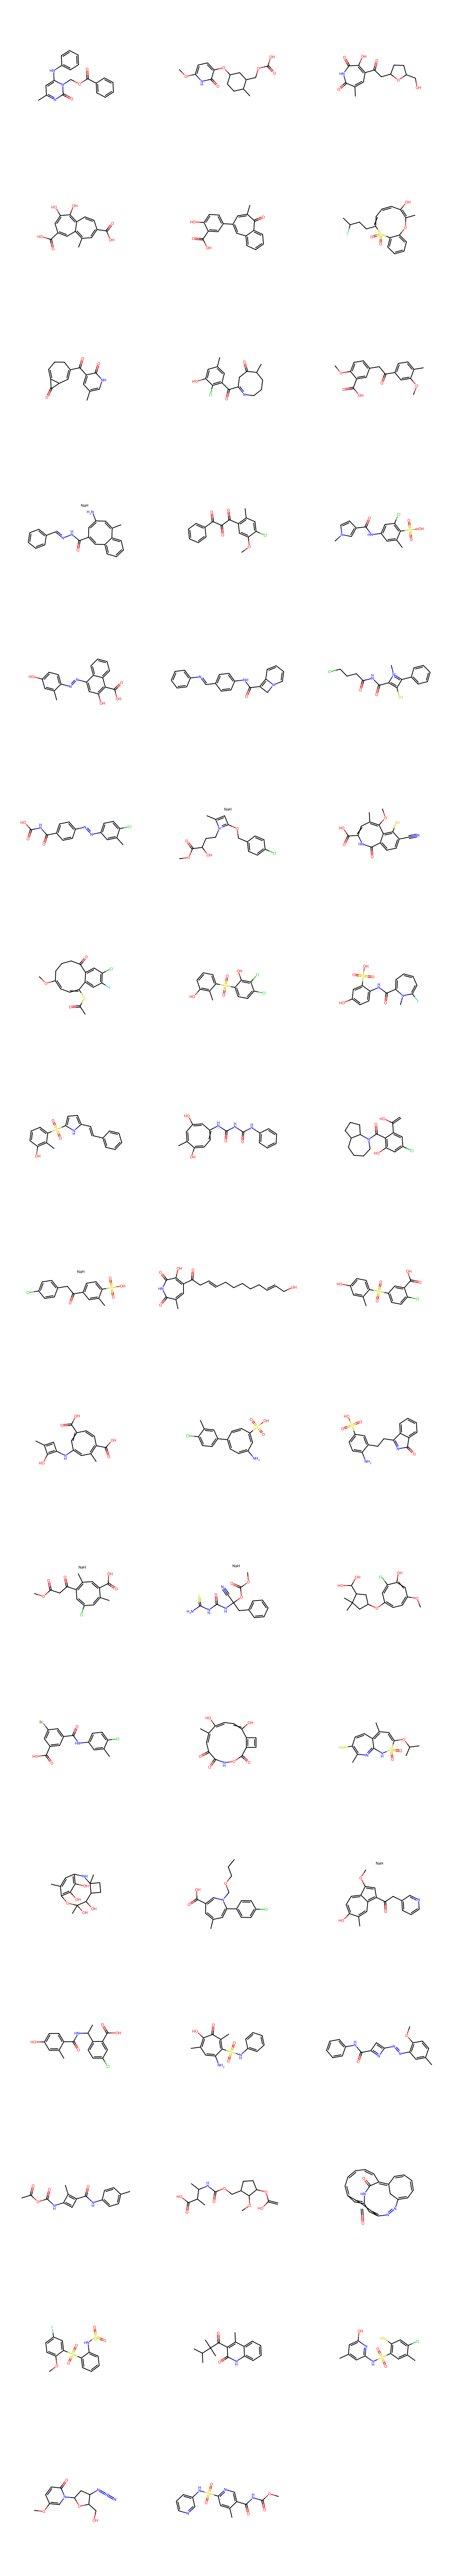

In [ ]:
Draw.MolsToGridImage(t_mols, molsPerRow=3, subImgSize=(400, 400))

In [ ]:
for i in t_smiles:
  print(i)

Cc1cc(Nc2ccccc2)n(COC(=O)c2ccccc2)c(=O)n1
COc1ccc(OC2CCC(C)C(COC(=O)O)c2)c(=O)[nH]1
Cc1cc(C(=O)CC2CCC(CO)O2)c(O)c(=O)[nH]c1=O
Cc1cc(C=Cc2c(O)c(O)cc(C(=O)O)cc12)C(=O)O
Cc1cc(-c2ccc(O)c(C(=O)O)c2)cc2ccccc2c1=O
Cc1c(O)cccc(S(=O)(=O)c2ccccc2o1)CCC(C)F
Cc1cc(C(=O)C2=CC3C(=O)C3=CCC2)c(=O)[nH]c1
Cc1cc(C(=O)C2=NCCCC(C)C(=O)c2)c(Cl)c(O)c1
COc1cc(C(=O)Cc2ccc(OC)c(C(=O)O)c2)ccc1C
Cc1cc(N)cc(C(=O)NN=Cc2ccccc2)cc2ccccc21.[NaH]
COc1cc(C(=O)C(=O)C(=O)c2ccccc2)c(C)cc1Cl
Cc1cc(NC(=O)c2cn(C)cc2)cc(Cl)c1S(=O)(=O)O
Cc1cc(O)ccc1N=Nc1cc(O)c(C(=O)O)c2ccccc12
C1n2ccccc2c1C(=O)Nc1ccc(C=Nc2ccccc2)cc1
C[n+]1c(-c2ccccc2)c(S)c1C(=O)NC(=O)CCCCl
Cc1cc(N=Nc2ccc(C(=O)NC(=O)O)cc2)ccc1Cl
Cc1cc(OCc2ccc(Cl)cc2)[n+]1CCC(O)C(=O)OC.[NaH]
Cc1cc(NC(=O)c2ccc(C#N)c(S)c2c1OC)C(=O)O
COc1ccc(-c2cc(F)c(Cl)cc2C(=O)CCC1)SC(C)=O
Cc1c(O)cccc1S(=O)(=O)c1ccc(Cl)c(Cl)c1O
Cn1c(F)ccccc1C(=O)Nc1ccc(O)cc1S(=O)(=O)O
Cc1c(O)cccc1S(=O)(=O)c1ccc(C=Cc2ccccc2)N1
Cc1cc(O)cc(NC(=O)NC(=O)Nc2ccccc2)ccc1O
C=C(O)c1cc(Cl)cc(O)c1C(=O)N1CCCCC2CCCC12
Cc1cc(C(

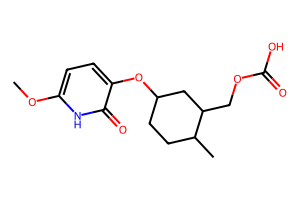

In [ ]:
Draw.MolsToGridImage([t_mols[1]], molsPerRow=1, subImgSize=(300, 200))